# load the data

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

train = pd.read_csv('../project/optiver-realized-volatility-prediction/train.csv')
train.head()

stock_id  time_id    target
0         0        5  0.004136
1         0       11  0.001445
2         0       16  0.002168
3         0       31  0.002195
4         0       62  0.001747

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428932 entries, 0 to 428931
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   stock_id  428932 non-null  int64  
 1   time_id   428932 non-null  int64  
 2   target    428932 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 9.8 MB


In [3]:
print('The total number of different stocks is', len(pd.unique(train['stock_id'])))
print('The total number of different time_id is', len(pd.unique(train['time_id'])))

The total number of different stocks is 112
The total number of different time_id is 3830


In [4]:
pd.unique(train['stock_id'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  46,  47,  48,  50,  51,  52,  53,  55,  56,  58,
        59,  60,  61,  62,  63,  64,  66,  67,  68,  69,  70,  72,  73,
        74,  75,  76,  77,  78,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       118, 119, 120, 122, 123, 124, 125, 126])

In [5]:
pd.unique(train['time_id'])

array([    5,    11,    16, ..., 32758, 32763, 32767])

Q: How to find the stocks which do not have full time_id?


# EDA

In [6]:
stock0 = train[train['stock_id']==0]

In [7]:
stock0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3830 entries, 0 to 3829
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   stock_id  3830 non-null   int64  
 1   time_id   3830 non-null   int64  
 2   target    3830 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 119.7 KB


In [8]:
stock0.time_id

0           5
1          11
2          16
3          31
4          62
        ...  
3825    32751
3826    32753
3827    32758
3828    32763
3829    32767
Name: time_id, Length: 3830, dtype: int64

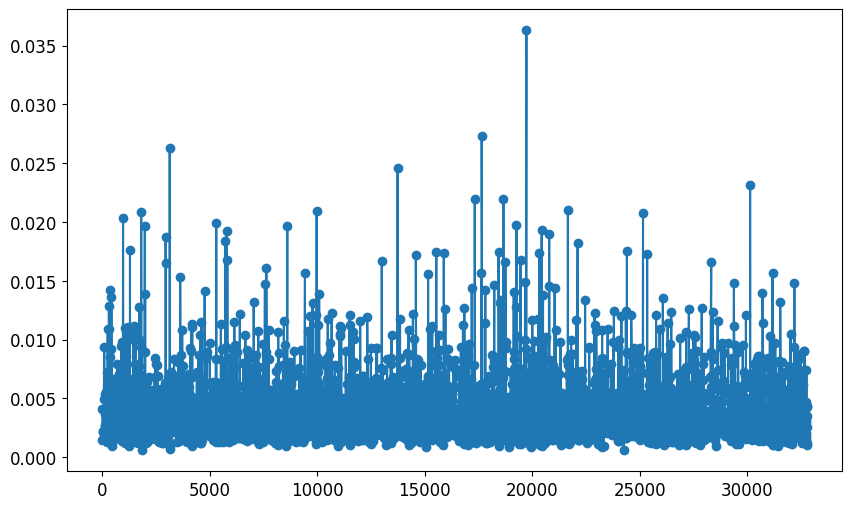

In [9]:
plt.figure(figsize=(10,6))

# plt.plot(stock0[stock0.time_id==11],
#             stock0[stock0.time_id==11].target, '-o')
plt.plot(stock0.time_id,
            stock0.target, '-o')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# The following line prevents dates from overlapping
# plt.gcf().autofmt_xdate()

plt.show()

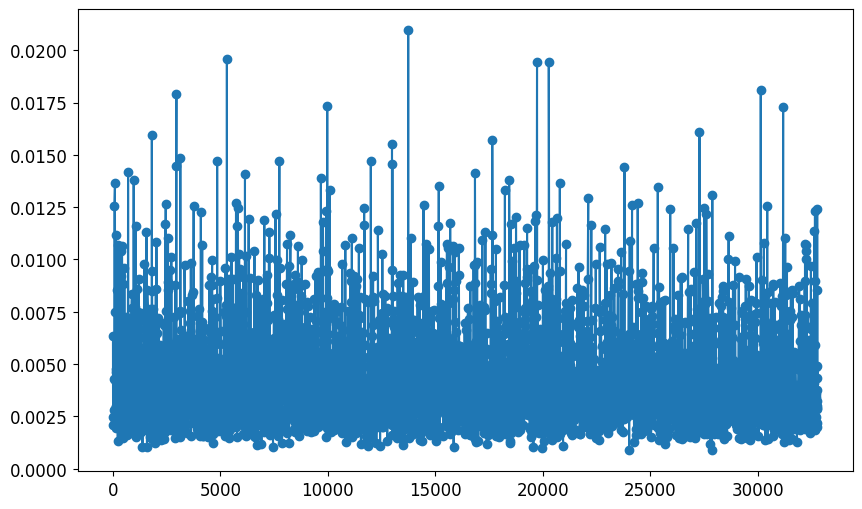

In [10]:
plt.figure(figsize=(10,6))

plt.plot(train[train.stock_id==1].time_id,
            train[train.stock_id==1].target, '-o')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### Explore with SARIMA


In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [12]:
y = stock0.target.values
y[1:] - y[:-1]

array([-2.691180e-03,  7.236020e-04,  2.707200e-05, ...,  3.073171e-03,
        8.837700e-05, -3.268373e-03])

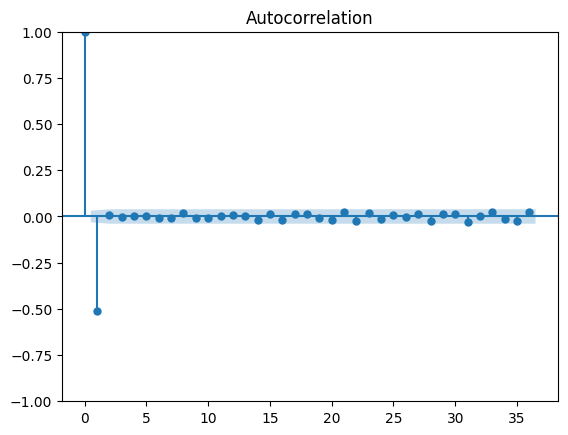

In [13]:
plot_acf(y[1:] - y[:-1])
plt.show()

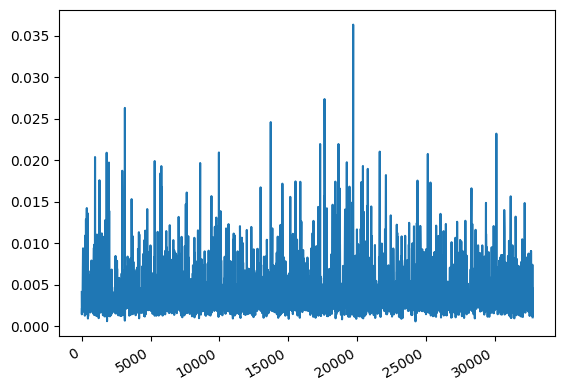

In [14]:
plt.plot(stock0.time_id.values, stock0.target.values)
plt.gcf().autofmt_xdate()

plt.show()

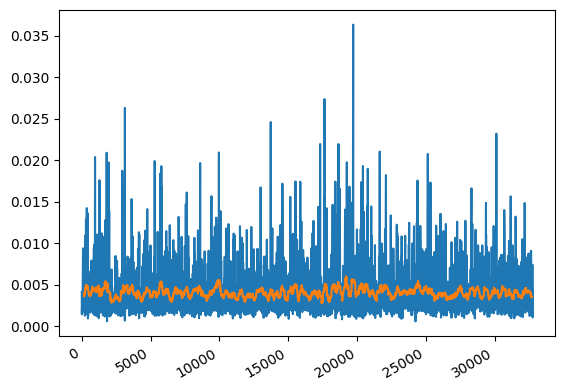

In [15]:
plt.plot(stock0.time_id.values, stock0.target.values)
plt.plot(stock0.time_id.iloc[15:-15], stock0.target.rolling(30).mean().iloc[30:])
plt.gcf().autofmt_xdate()

plt.show()

Ref: https://www.kaggle.com/code/gunesevitan/optiver-realized-volatility-prediction-eda

### EDA for train data

Evaluation from problem requirement: RMSPE
$\huge \text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ((y_i - \hat{y}_i)/y_i)^2}$

In [97]:
# Baselines:global target mean, target mean of stock_ids, target median of stock_ids
def root_mean_squared_percentage_error(y_true, y_pred, epsilon=1e-10):
    
    rmspe = np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + epsilon))))
    return rmspe

target_mean_rmspe = root_mean_squared_percentage_error(train.target, train.target.mean())
print(f'target Mean RMPSE: {target_mean_rmspe:.6}') # use global target mean as prediction
stock_id_target_mean_rmspe = root_mean_squared_percentage_error(train.target, train.groupby('stock_id').target.transform('mean')) # use each stock's target mean as their prediction
print(f'stock_id target Mean RMPSE: {stock_id_target_mean_rmspe:.6}')
stock_id_target_median_rmspe = root_mean_squared_percentage_error(train.target, train.groupby('stock_id').target.transform('median')) # use each stock's target median as their prediction
print(f'stock_id target Median RMPSE: {stock_id_target_median_rmspe:.6}')

target Mean RMPSE: 1.11033
stock_id target Mean RMPSE: 0.789618
stock_id target Median RMPSE: 0.589135


In [17]:
train.groupby('stock_id').target.mean()

stock_id
0      0.004028
1      0.004362
2      0.002385
3      0.006182
4      0.004197
         ...   
122    0.003762
123    0.002506
124    0.003691
125    0.002016
126    0.005321
Name: target, Length: 112, dtype: float64

In [18]:
train.groupby('stock_id').target.transform('mean')

0         0.004028
1         0.004028
2         0.004028
3         0.004028
4         0.004028
            ...   
428927    0.005321
428928    0.005321
428929    0.005321
428930    0.005321
428931    0.005321
Name: target, Length: 428932, dtype: float64

In [19]:
train['target']

0         0.004136
1         0.001445
2         0.002168
3         0.002195
4         0.001747
            ...   
428927    0.003461
428928    0.003113
428929    0.004070
428930    0.003357
428931    0.002090
Name: target, Length: 428932, dtype: float64

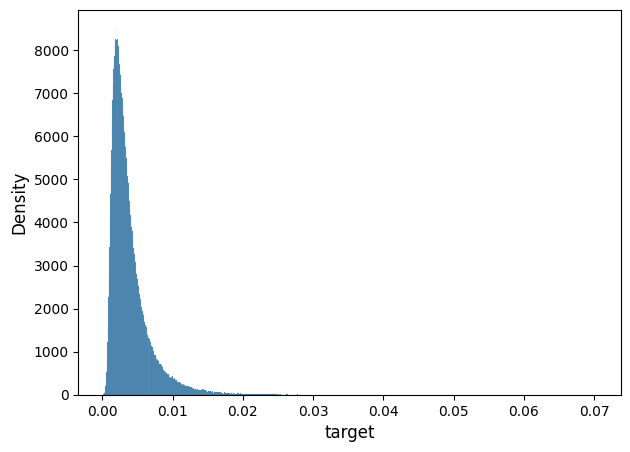

In [20]:
# A histogram is a classic visualization tool that
# represents the distribution of one or more variables by counting the number of observations that fall within discrete bins.
plt.figure(figsize=(7,5))
sns.histplot(train['target'], label='target', fill=True)
plt.ylabel("Density", fontsize=12)
plt.xlabel("target", fontsize=12)
plt.show()

In [21]:
print(f'Mean: {train.target.mean():.4f}')


Mean: 0.0039


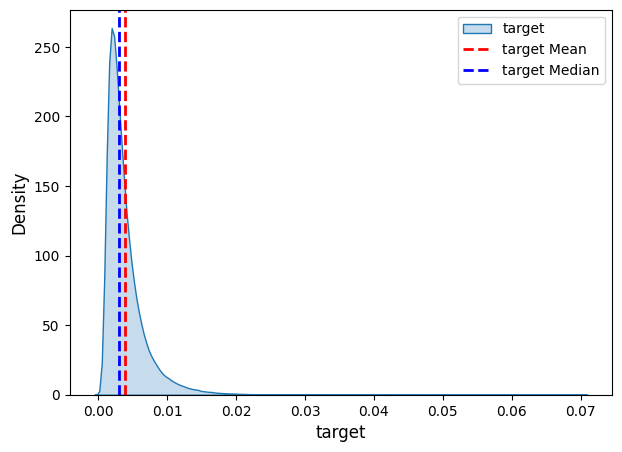

Mean: 0.0039  -  Median: 0.0030  -  Std: 0.0029
Min: 0.0001  -  25%: 0.0020  -  50%: 0.0030  -  75%: 0.0047  -  Max: 0.0703
Skew: 2.8226  -  Kurtosis: 14.9611


In [22]:
# A plot for visualizing the distribution of observations in a dataset, kernel density estimate (KDE) plot
plt.figure(figsize=(7,5))

sns.kdeplot(train['target'], label='target', fill=True)
plt.axvline(train['target'].mean(), label='target Mean', color='r', linewidth=2, linestyle='--')
plt.axvline(train['target'].median(), label='target Median', color='b', linewidth=2, linestyle='--')
plt.ylabel("Density", fontsize=12)
plt.xlabel("target", fontsize=12)
plt.legend()
plt.show()

print(f'Mean: {train.target.mean():.4f}  -  Median: {train.target.median():.4f}  -  Std: {train.target.std():.4f}')
print(f'Min: {train.target.min():.4f}  -  25%: {train.target.quantile(0.25):.4f}  -  50%: {train.target.quantile(0.5):.4f}  -  75%: {train.target.quantile(0.75):.4f}  -  Max: {train.target.max():.4f}')
print(f'Skew: {train.target.skew():.4f}  -  Kurtosis: {train.target.kurtosis():.4f}')


We observe a somewhat skewed distribution of the target.

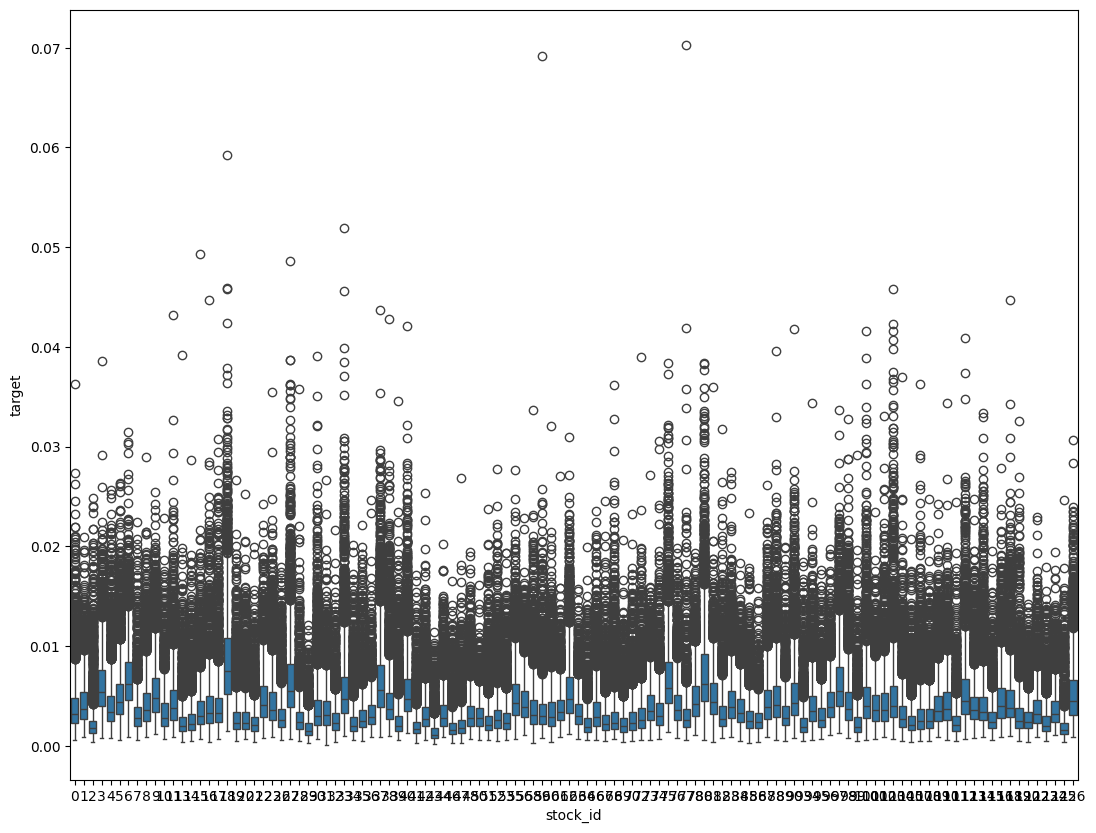

In [23]:
plt.figure(figsize=(13,10))
sns.boxplot(data=train, x='stock_id', y=train['target'])
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
# plt.ylabel("target", fontsize=12)
# plt.xlabel("Density", fontsize=12)
plt.show()

((array([-4.6554993 , -4.46936925, -4.36854335, ...,  4.36854335,
          4.46936925,  4.6554993 ]),
  array([0.00010526, 0.00010899, 0.00011278, ..., 0.05925642, 0.06916474,
         0.07032062])),
 (0.0025693236491163055, 0.0038804095369522435, 0.8750497198016297))

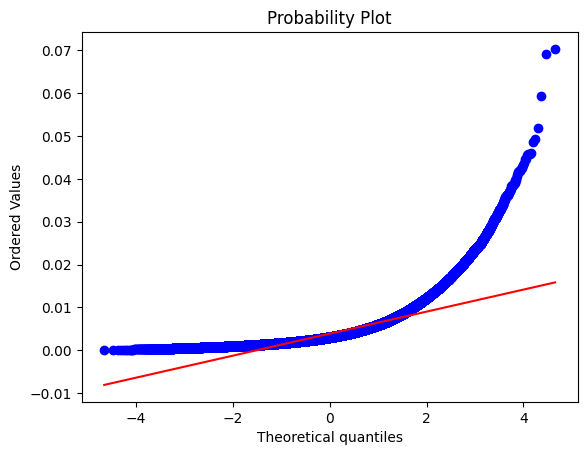

In [24]:
#Generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default)
from scipy.stats import probplot
probplot(train.target, plot=plt)

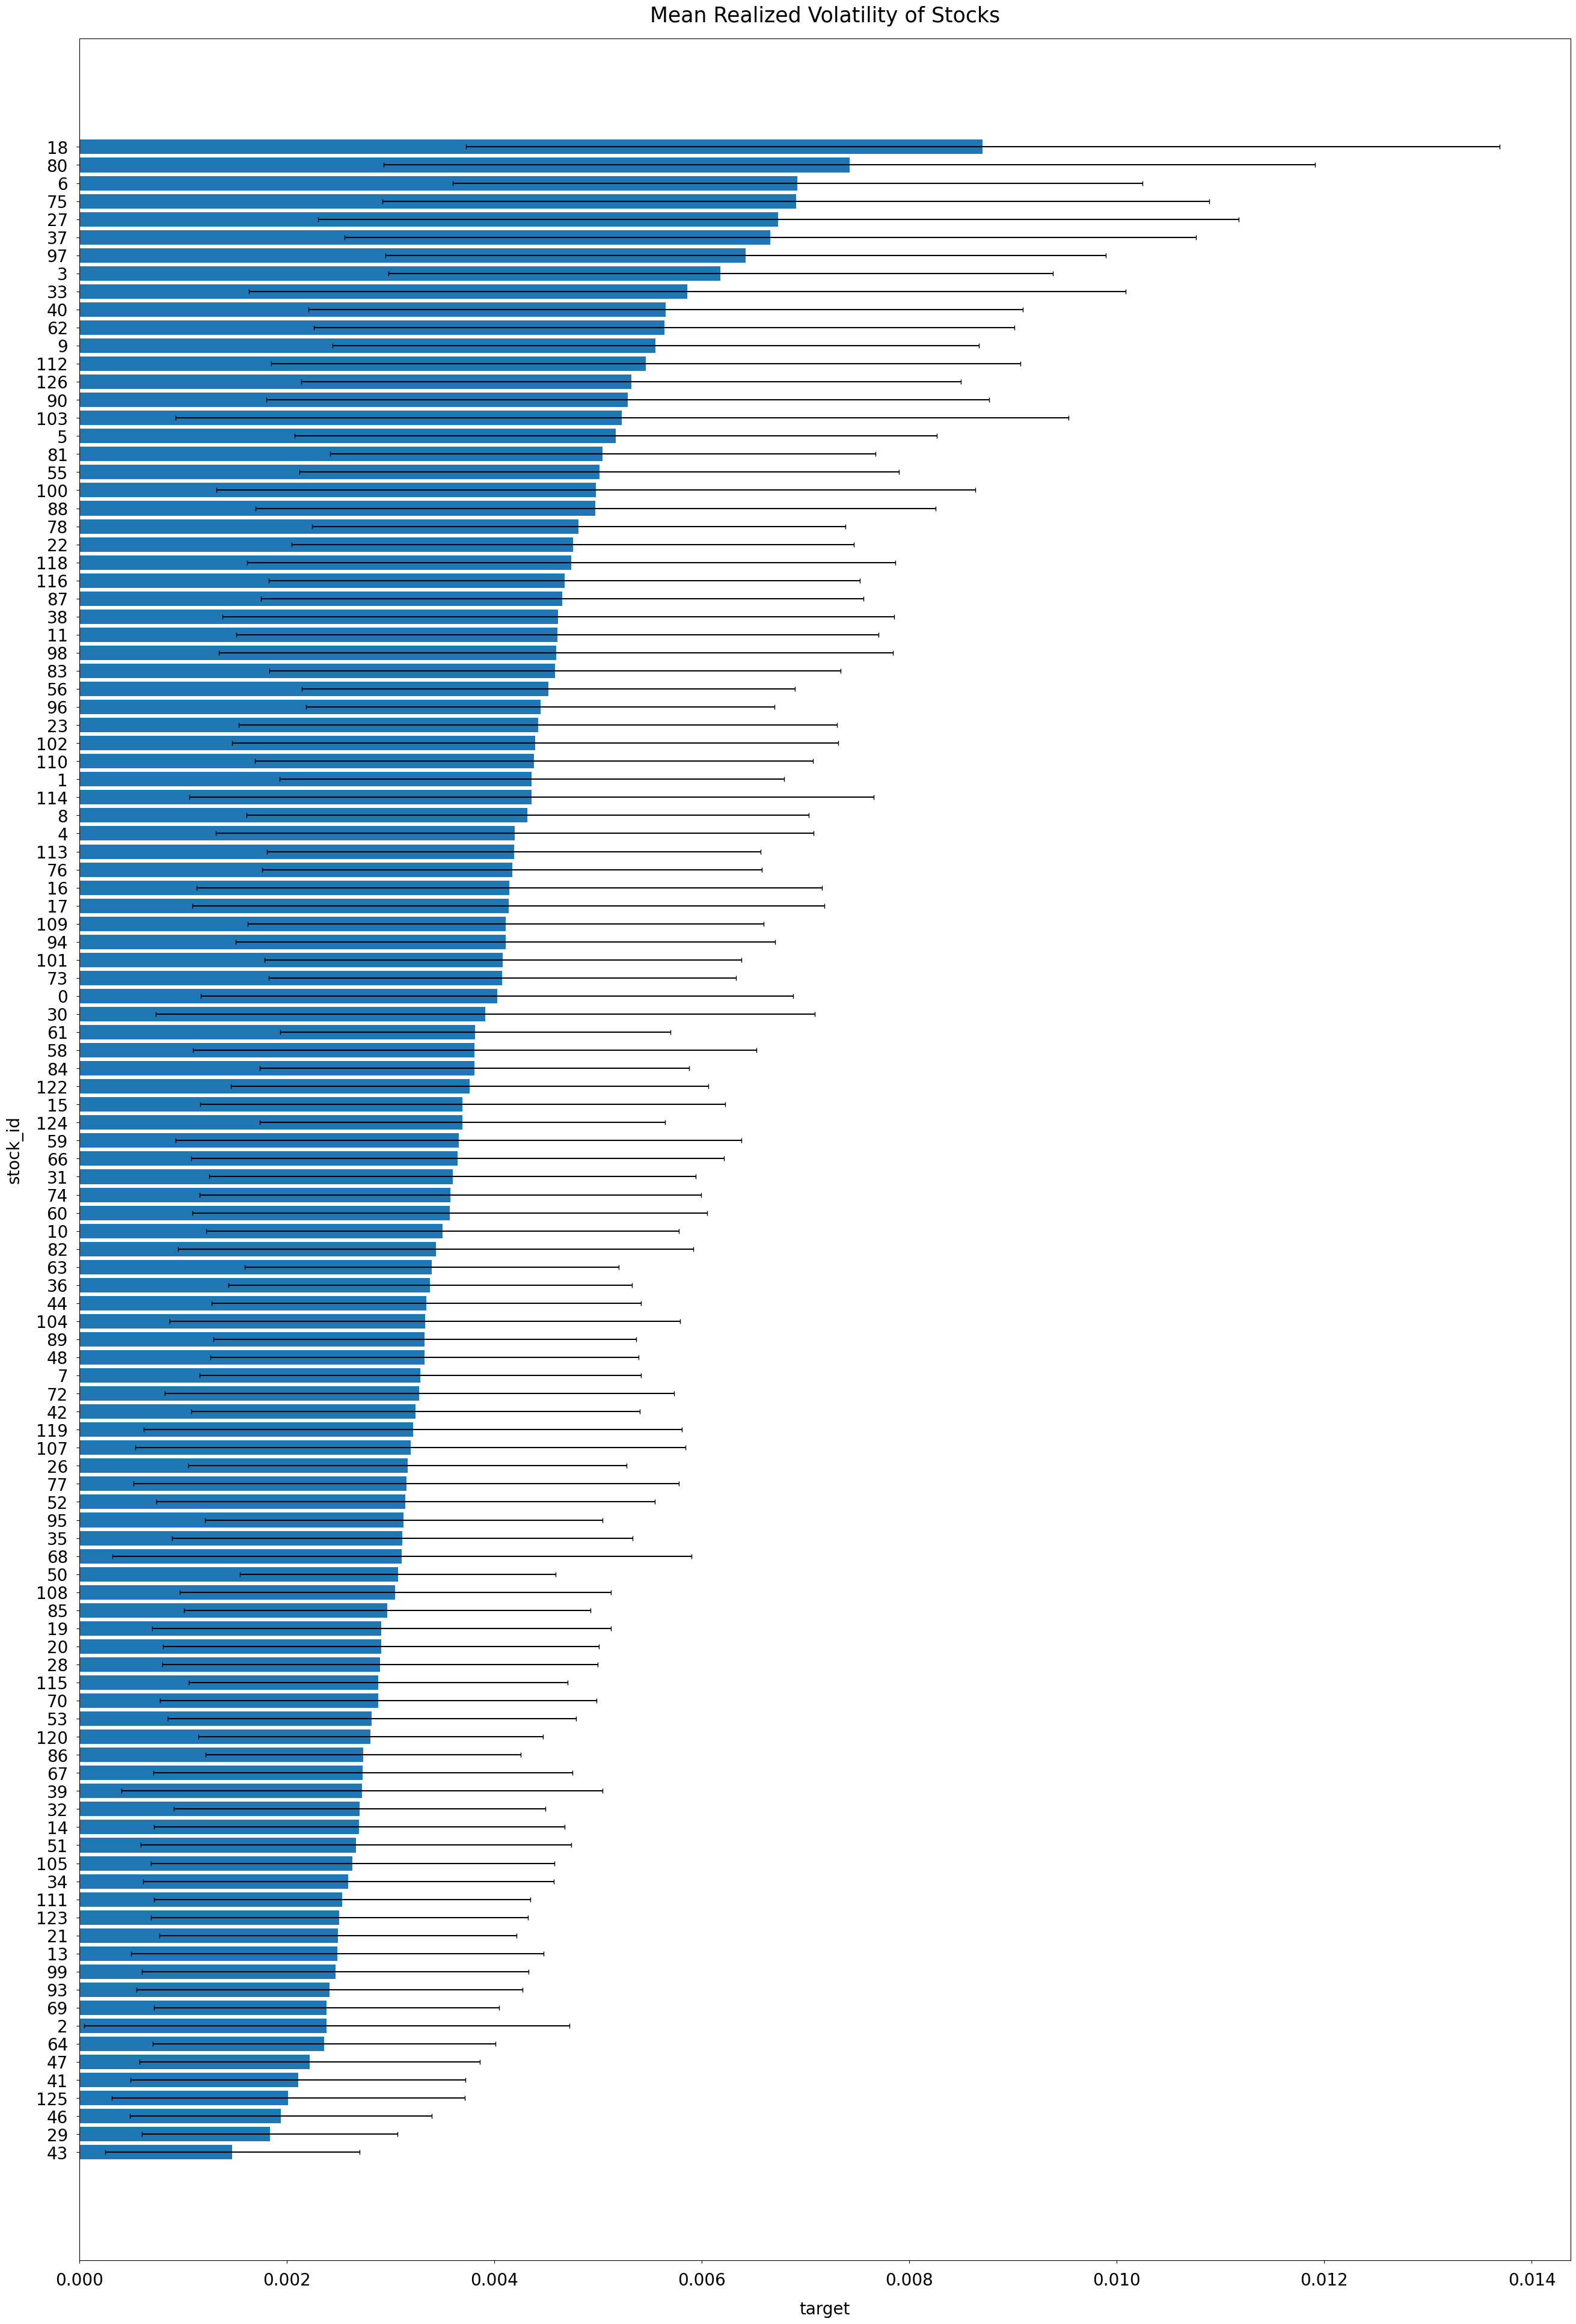

In [25]:
target_means = train.groupby('stock_id')['target'].mean()
target_stds = train.groupby('stock_id')['target'].std()

target_means_and_stds = pd.concat([target_means, target_stds], axis=1)
target_means_and_stds.columns = ['mean', 'std']
target_means_and_stds.sort_values(by='mean', ascending=True, inplace=True)

fig, ax = plt.subplots(figsize=(32, 48))
ax.barh(
    y=np.arange(len(target_means_and_stds)),
    width=target_means_and_stds['mean'],
    xerr=target_means_and_stds['std'],
    align='center',
    ecolor='black',
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_and_stds)))
ax.set_yticklabels(target_means_and_stds.index)
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Mean Realized Volatility of Stocks', size=25, pad=20)

plt.show()

del target_means, target_stds, target_means_and_stds
# They are ranked by their mean target value across multiple time_ids.
# Wide error bars show that even the realized volatility is volatile between multiple time buckets.

In [26]:
train.sample(10)

stock_id  time_id    target
423757       125    20563  0.001541
170870        48    19512  0.005323
327611        97    17305  0.006193
359224       105    25668  0.002941
197687        58    19554  0.003430
361886       107    15727  0.001858
69181         19     2006  0.001629
384541       113    13163  0.004302
404229       119    17448  0.001542
109607        31    19528  0.002925

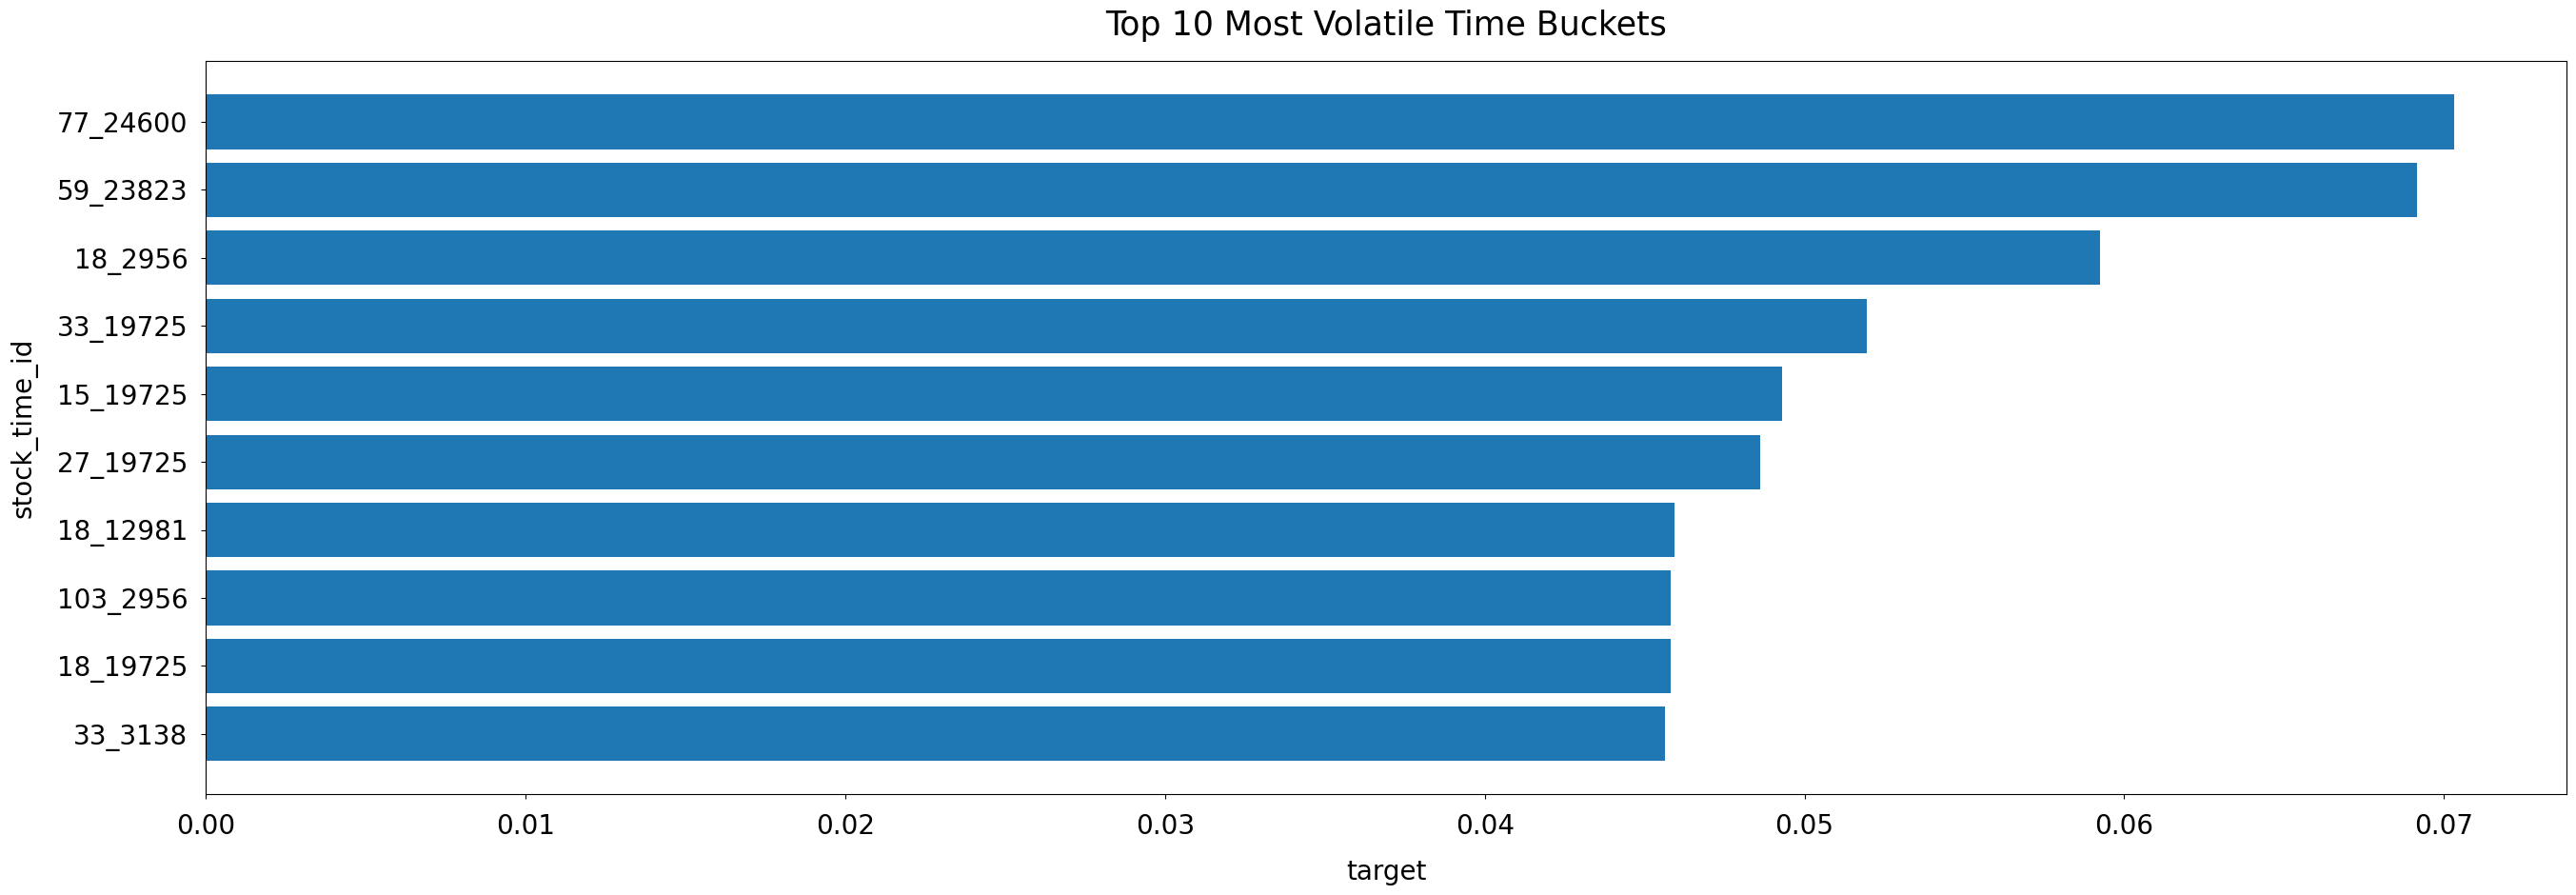

In [27]:
# sort via target value, find the hightest 10, which will be Top 10 Most Volatile Time Buckets.
train['stock_time_id'] = train['stock_id'].astype(str) + '_' + train['time_id'].astype(str)

fig, ax = plt.subplots(figsize=(32, 10))
ax.barh(
    y=np.arange(10),
    width=train.sort_values(by='target', ascending=True).tail(10)['target'],
    align='center',
    ecolor='black',
)

ax.set_yticks(np.arange(10))
ax.set_yticklabels(train.sort_values(by='target', ascending=True).tail(10)['stock_time_id'])
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_time_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Top 10 Most Volatile Time Buckets', size=25, pad=20)

plt.show()

train.drop(columns=['stock_time_id'], inplace=True)

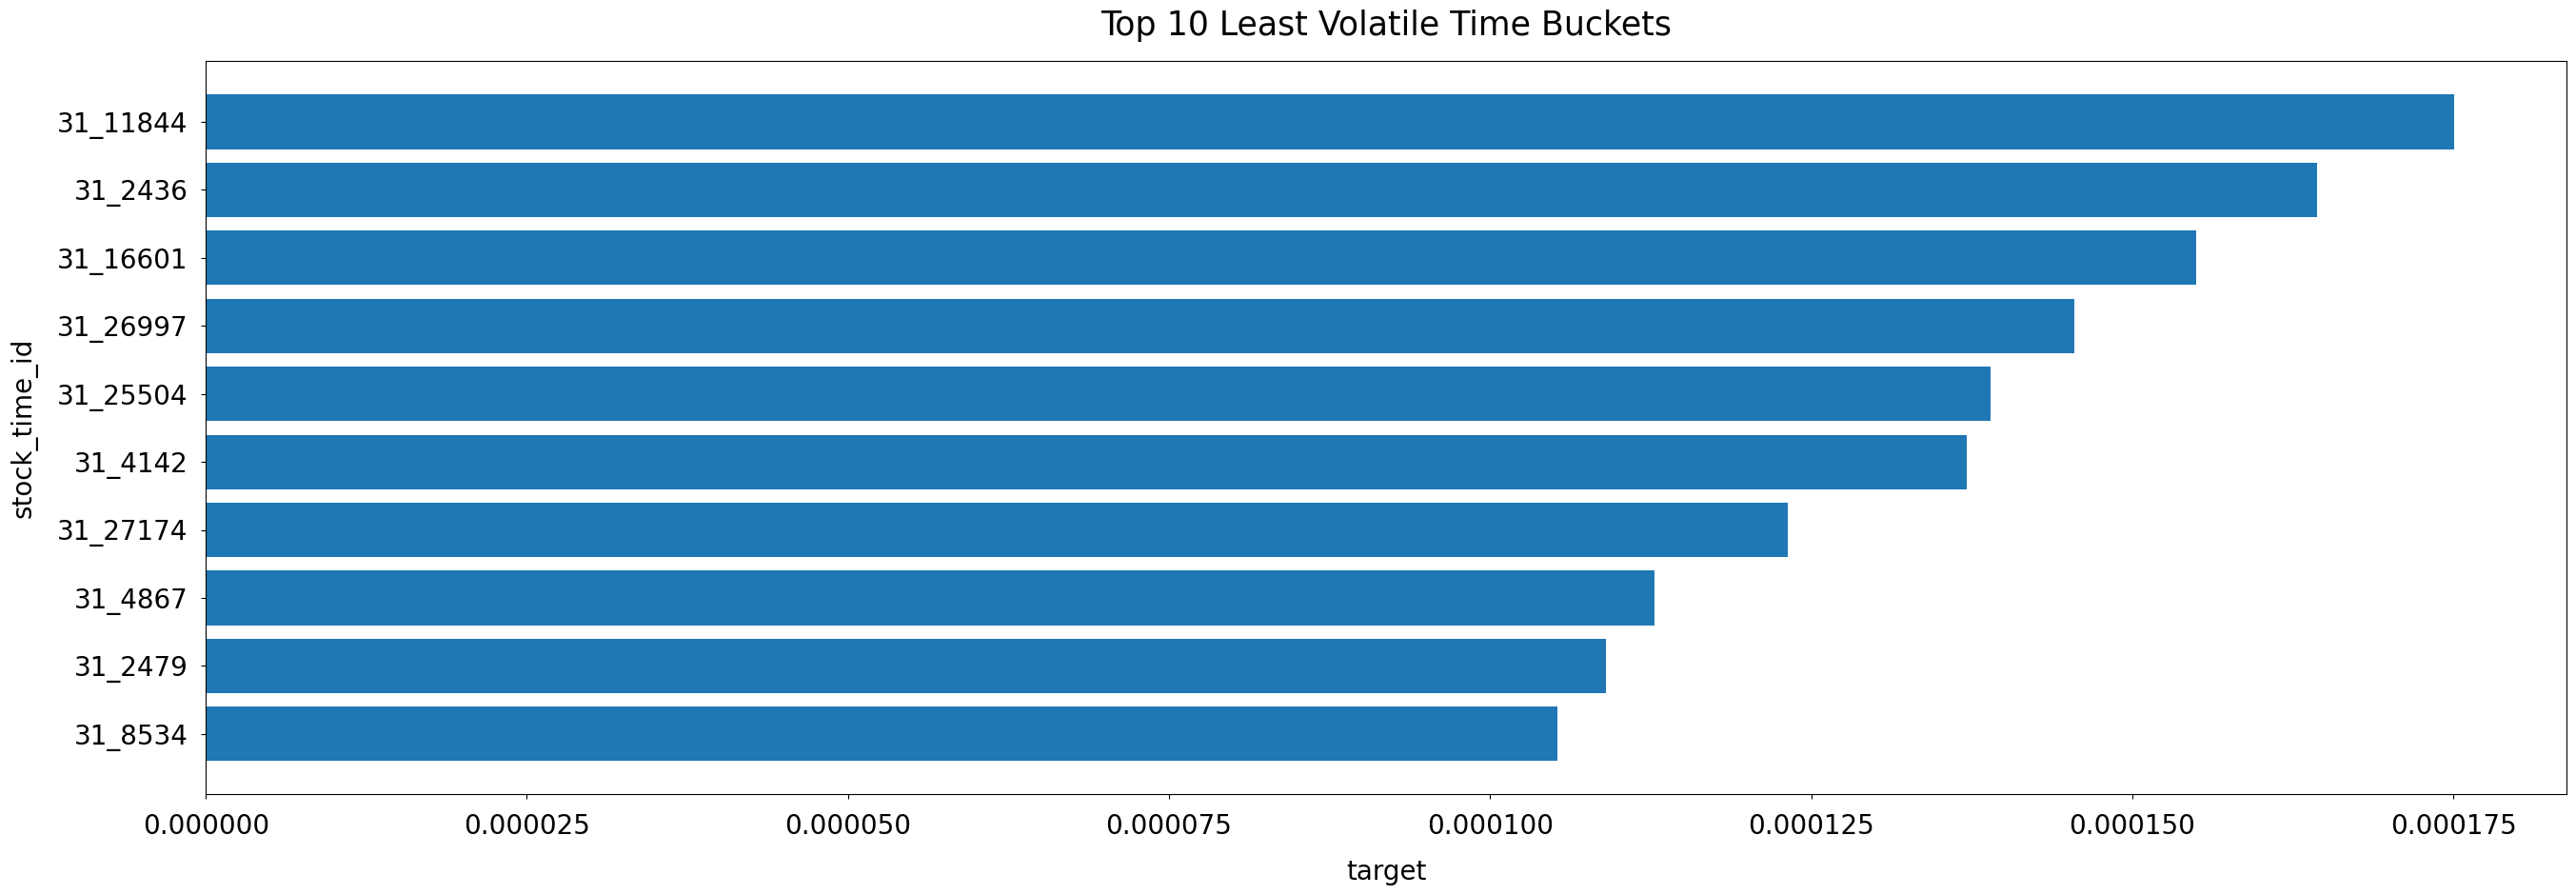

In [28]:
# sort via target value, find the hightest 10, which will be Top 10 Most Volatile Time Buckets.
train['stock_time_id'] = train['stock_id'].astype(str) + '_' + train['time_id'].astype(str)

fig, ax = plt.subplots(figsize=(32, 10))
ax.barh(
    y=np.arange(10),
    width=train.sort_values(by='target', ascending=True).head(10)['target'],
    align='center',
    ecolor='black',
)

ax.set_yticks(np.arange(10))
ax.set_yticklabels(train.sort_values(by='target', ascending=True).head(10)['stock_time_id'])
ax.set_xlabel('target', size=20, labelpad=15)
ax.set_ylabel('stock_time_id', size=20, labelpad=15)
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Top 10 Least Volatile Time Buckets', size=25, pad=20)

plt.show()

train.drop(columns=['stock_time_id'], inplace=True)

## EDA for order book

### load order book

In [29]:
def read_book_data(dataset, stock_id, sort=False, forward_fill=False):
        
    book_dtypes = {
        'time_id': np.uint16,
        'seconds_in_bucket': np.uint16,
        'bid_price1': np.float32,
        'ask_price1': np.float32,
        'bid_price2': np.float32,
        'ask_price2': np.float32,
        'bid_size1': np.uint32,
        'ask_size1': np.uint32,
        'bid_size2': np.uint32,
        'ask_size2': np.uint32,
    }

    df_book = pd.read_parquet(f'../project/optiver-realized-volatility-prediction/book_{dataset}.parquet/stock_id={stock_id}')
    for column, dtype in book_dtypes.items():
        df_book[column] = df_book[column].astype(dtype)
    
    if sort:
        df_book.sort_values(by=['time_id', 'seconds_in_bucket'], inplace=True)
        
    if forward_fill:
        df_book = df_book.set_index(['time_id', 'seconds_in_bucket'])
        df_book = df_book.reindex(pd.MultiIndex.from_product([df_book.index.levels[0], np.arange(0, 600)], names=['time_id', 'seconds_in_bucket']), method='ffill')
        df_book.reset_index(inplace=True)

    return df_book

$\huge WAP = \frac{BidPrice_{1}*AskSize_{1} + AskPrice_{1}*BidSize_{1}}{BidSize_{1} + AskSize_{1}}$

log return of a stock $S$ at time $t$ is
$\huge r_{t-1, t} = \log \left( \frac{S_{t-1}}{S_{t1}} \right)$

Realized volatility, $\sigma$, is the squared root of the sum of squared log returns which is denoted as
$\huge \sigma = \sqrt{\sum_{t}r_{t-1, t}^2}$, t is the time_id sequence

### Calculate WAP and realized volatility for stock 0

In [30]:
dataset = 'train'
stock_id=0
book0 = pd.read_parquet(f'../project/optiver-realized-volatility-prediction/book_{dataset}.parquet/stock_id={stock_id}')

In [31]:
book0['wap1'] = (book0['bid_price1'] * book0['ask_size1'] + book0['ask_price1'] * book0['bid_size1']) /\
                      (book0['bid_size1'] + book0['ask_size1'])
book0['wap2'] = (book0['bid_price2'] * book0['ask_size2'] + book0['ask_price2'] * book0['bid_size2']) /\
                      (book0['bid_size2'] + book0['ask_size2'])

In [32]:
book0.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.001422    1.002301     1.00137    1.002353   
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   
3        5                  6    1.001422    1.002301     1.00137    1.002405   
4        5                  7    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2      wap1      wap2  
0          3        226          2        100  1.001434  1.001390  
1          3        100          2        100  1.001448  1.001390  
2          3        100          2        100  1.001448  1.001391  
3          3        126          2        100  1.001443  1.001391  
4          3        126          2        100  1.001443  1.001391

In [33]:
book0['log_return_from_wap1'] = np.log(book0['wap1'] / book0.groupby('time_id')['wap1'].shift(1))
book0['log_return_from_wap2'] = np.log(book0['wap2'] / book0.groupby('time_id')['wap2'].shift(1))
book0.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.001422    1.002301     1.00137    1.002353   
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   
3        5                  6    1.001422    1.002301     1.00137    1.002405   
4        5                  7    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2      wap1      wap2  \
0          3        226          2        100  1.001434  1.001390   
1          3        100          2        100  1.001448  1.001390   
2          3        100          2        100  1.001448  1.001391   
3          3        126          2        100  1.001443  1.001391   
4          3        126          2        100  1.001443  1.001391   

   log_return_from_wap1  log_return_from_wap2  
0                   NaN                   NaN  
1              0.000014              0.000000  
2              0.000000              0.000001  
3             -0.000005              0.000000  
4              0.000000              0.000000

In [34]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 
book0.loc[:,'log_return_from_wap2_method2'] = log_return(book0['wap2'])
book0.head(20)

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
0         5                  0    1.001422    1.002301    1.001370   
1         5                  1    1.001422    1.002301    1.001370   
2         5                  5    1.001422    1.002301    1.001370   
3         5                  6    1.001422    1.002301    1.001370   
4         5                  7    1.001422    1.002301    1.001370   
5         5                 11    1.001422    1.002301    1.001370   
6         5                 12    1.001422    1.002301    1.001370   
7         5                 14    1.001422    1.002301    1.001370   
8         5                 15    1.001422    1.002301    1.001370   
9         5                 16    1.001422    1.002301    1.001370   
10        5                 17    1.001422    1.002301    1.001370   
11        5                 18    1.001422    1.002301    1.001370   
12        5                 19    1.001422    1.002301    1.001370   
13        5                 21    1.001422    1.002818    1.001370   
14        5                 24    1.001474    1.002818    1.001422   
15        5                 25    1.001732    1.002818    1.001422   
16        5                 44    1.001732    1.002818    1.001422   
17        5                 46    1.002818    1.003232    1.002301   
18        5                 47    1.002818    1.003232    1.002301   
19        5                 48    1.002818    1.003232    1.002353   

    ask_price2  bid_size1  ask_size1  bid_size2  ask_size2      wap1  \
0     1.002353          3        226          2        100  1.001434   
1     1.002353          3        100          2        100  1.001448   
2     1.002405          3        100          2        100  1.001448   
3     1.002405          3        126          2        100  1.001443   
4     1.002405          3        126          2        100  1.001443   
5     1.002405          3        100          2        100  1.001448   
6     1.002405          3        126          2        100  1.001443   
7     1.002405          3        126          2        100  1.001443   
8     1.002405          3        126          2        100  1.001443   
9     1.002405          3        126          2        100  1.001443   
10    1.002405          3        100          2        100  1.001448   
11    1.002405          3        126          2        100  1.001443   
12    1.002405          3        126          2        100  1.001443   
13    1.002922          3         30          2        100  1.001549   
14    1.002922        155         30          3        100  1.002600   
15    1.002922         83         30          3        100  1.002530   
16    1.002922         83         28          3        100  1.002545   
17    1.003801        155          1        200         34  1.003230   
18    1.003801         55          1        100         34  1.003225   
19    1.003749         55        101        103        100  1.002964   

        wap2  log_return_from_wap1  log_return_from_wap2  \
0   1.001390                   NaN                   NaN   
1   1.001390              0.000014              0.000000   
2   1.001391              0.000000              0.000001   
3   1.001391             -0.000005              0.000000   
4   1.001391              0.000000              0.000000   
5   1.001391              0.000005              0.000000   
6   1.001391             -0.000005              0.000000   
7   1.001391              0.000000              0.000000   
8   1.001391              0.000000              0.000000   
9   1.001391              0.000000              0.000000   
10  1.001391              0.000005              0.000000   
11  1.001391             -0.000005              0.000000   
12  1.001391              0.000000              0.000000   
13  1.001401              0.000106              0.000010   
14  1.001466              0.001049              0.000065   
15  1.001466             -0.000070              0.000000   


In [35]:
for wap in [1, 2]:
    book0[f'squared_log_return_from_wap{wap}'] = book0[f'log_return_from_wap{wap}'] ** 2
    book0[f'realized_volatility_from_wap{wap}'] = np.sqrt(book0.groupby('time_id')[f'squared_log_return_from_wap{wap}'].transform('sum'))
    book0.drop(columns=[f'squared_log_return_from_wap{wap}'], inplace=True)
    realized_volatilities = book0.groupby('time_id')[f'realized_volatility_from_wap{wap}'].first().to_dict() # what does this do?
    train.loc[train['stock_id'] == stock_id, f'realized_volatility_from_wap{wap}'] = train[train['stock_id'] == stock_id]['time_id'].map(realized_volatilities)
    # map the calculated realized_volatility_ to train dataset as baseline prediction. 

In [36]:
book0.head()

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    1.001422    1.002301     1.00137    1.002353   
1        5                  1    1.001422    1.002301     1.00137    1.002353   
2        5                  5    1.001422    1.002301     1.00137    1.002405   
3        5                  6    1.001422    1.002301     1.00137    1.002405   
4        5                  7    1.001422    1.002301     1.00137    1.002405   

   bid_size1  ask_size1  bid_size2  ask_size2      wap1      wap2  \
0          3        226          2        100  1.001434  1.001390   
1          3        100          2        100  1.001448  1.001390   
2          3        100          2        100  1.001448  1.001391   
3          3        126          2        100  1.001443  1.001391   
4          3        126          2        100  1.001443  1.001391   

   log_return_from_wap1  log_return_from_wap2  log_return_from_wap2_method2  \
0                   NaN                   NaN                           NaN   
1              0.000014              0.000000                      0.000000   
2              0.000000              0.000001                      0.000001   
3             -0.000005              0.000000                      0.000000   
4              0.000000              0.000000                      0.000000   

   realized_volatility_from_wap1  realized_volatility_from_wap2  
0                       0.004499                       0.006999  
1                       0.004499                       0.006999  
2                       0.004499                       0.006999  
3                       0.004499                       0.006999  
4                       0.004499                       0.006999

In [37]:
train.loc[train['stock_id'] == stock_id]

stock_id  time_id    target  realized_volatility_from_wap1  \
0            0        5  0.004136                       0.004499   
1            0       11  0.001445                       0.001204   
2            0       16  0.002168                       0.002369   
3            0       31  0.002195                       0.002574   
4            0       62  0.001747                       0.001894   
...        ...      ...       ...                            ...   
3825         0    32751  0.002611                       0.002579   
3826         0    32753  0.001190                       0.002206   
3827         0    32758  0.004264                       0.002913   
3828         0    32763  0.004352                       0.003046   
3829         0    32767  0.001084                       0.001901   

      realized_volatility_from_wap2  
0                          0.006999  
1                          0.002476  
2                          0.004801  
3                          0.003637  
4                          0.003257  
...                             ...  
3825                       0.003821  
3826                       0.002847  
3827                       0.003266  
3828                       0.005105  
3829                       0.002541  

[3830 rows x 5 columns]

In [38]:
realized_volatility_wap1_rmspe_stock0 = root_mean_squared_percentage_error(train.loc[train['stock_id']==stock_id, 'target'], train.loc[train['stock_id']==stock_id, 'realized_volatility_from_wap1'])
print(f'Realized Volatility from WAP1 RMPSE: {realized_volatility_wap1_rmspe_stock0:.6}')
realized_volatility_wap2_rmspe_stock0 = root_mean_squared_percentage_error(train.loc[train['stock_id']==stock_id, 'target'], train.loc[train['stock_id']==stock_id, 'realized_volatility_from_wap2'])
print(f'Realized Volatility from WAP2 RMPSE: {realized_volatility_wap2_rmspe_stock0:.6}')

Realized Volatility from WAP1 RMPSE: 0.393227
Realized Volatility from WAP2 RMPSE: 0.986774


### Calculate WAP and realized volatility for each stock

In [40]:
for stock_id in tqdm(sorted(train['stock_id'].unique())):
            
    df_book = read_book_data('train', stock_id)

    # Weighted averaged prices
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])

    # Realized volatilities
    for wap in [1, 2]:
        df_book[f'log_return_from_wap{wap}'] = np.log(df_book[f'wap{wap}'] / df_book.groupby('time_id')[f'wap{wap}'].shift(1))
        df_book[f'squared_log_return_from_wap{wap}'] = df_book[f'log_return_from_wap{wap}'] ** 2
        df_book[f'realized_volatility_from_wap{wap}'] = np.sqrt(df_book.groupby('time_id')[f'squared_log_return_from_wap{wap}'].transform('sum'))
        df_book.drop(columns=[f'squared_log_return_from_wap{wap}'], inplace=True)
        realized_volatilities = df_book.groupby('time_id')[f'realized_volatility_from_wap{wap}'].first().to_dict() # what does this do?
        train.loc[train['stock_id'] == stock_id, f'realized_volatility_from_wap{wap}'] = train[train['stock_id'] == stock_id]['time_id'].map(realized_volatilities)
        # map the calculated realized_volatility_ to train dataset as baseline prediction. 

  0%|          | 0/112 [00:00<?, ?it/s]

In [98]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042049 entries, 0 to 1042048
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   time_id              1042049 non-null  uint16 
 1   seconds_in_bucket    1042049 non-null  uint16 
 2   bid_price1           1042049 non-null  float32
 3   ask_price1           1042049 non-null  float32
 4   bid_price2           1042049 non-null  float32
 5   ask_price2           1042049 non-null  float32
 6   bid_size1            1042049 non-null  uint32 
 7   ask_size1            1042049 non-null  uint32 
 8   bid_size2            1042049 non-null  uint32 
 9   ask_size2            1042049 non-null  uint32 
 10  bid_ask_price_ratio  1042049 non-null  float32
 11  wap1                 1042049 non-null  float64
 12  wap2                 1042049 non-null  float64
dtypes: float32(5), float64(2), uint16(2), uint32(4)
memory usage: 55.7 MB


In [41]:
df_book.head(10)

time_id  seconds_in_bucket  bid_price1  ask_price1  bid_price2  ask_price2  \
0        5                  0    0.999775    1.001836    0.999613    1.002255   
1        5                  3    0.999775    1.001836    0.999613    1.002255   
2        5                  9    0.999775    1.001836    0.999613    1.002255   
3        5                 10    0.999839    1.001836    0.999807    1.002255   
4        5                 11    0.999903    1.001868    0.999807    1.002255   
5        5                 12    0.999903    1.002190    0.999807    1.002255   
6        5                 13    1.000032    1.002255    1.000000    1.002416   
7        5                 14    1.000290    1.002416    1.000258    1.002609   
8        5                 17    1.000290    1.002352    1.000258    1.002416   
9        5                 19    1.000290    1.002352    1.000258    1.002416   

   bid_size1  ask_size1  bid_size2  ask_size2      wap1      wap2  \
0        134        117        100        232  1.000875  1.000409   
1        132        117        100        232  1.000867  1.000409   
2        132         17        100        232  1.001601  1.000409   
3        459         17        295        232  1.001765  1.001177   
4       1216          2        216        232  1.001865  1.000987   
5       1267          2        116        200  1.002187  1.000705   
6        800          1        380          1  1.002252  1.002410   
7        500          1         18         17  1.002412  1.001467   
8        500         44         18          1  1.002185  1.002302   
9        730         44         18          1  1.002234  1.002302   

   log_return_from_wap1  realized_volatility_from_wap1  log_return_from_wap2  \
0                   NaN                       0.007255                   NaN   
1             -0.000008                       0.007255              0.000000   
2              0.000733                       0.007255              0.000000   
3              0.000164                       0.007255              0.000767   
4              0.000100                       0.007255             -0.000190   
5              0.000321                       0.007255             -0.000281   
6              0.000065                       0.007255              0.001702   
7              0.000159                       0.007255             -0.000941   
8             -0.000226                       0.007255              0.000834   
9              0.000049                       0.007255              0.000000   

   realized_volatility_from_wap2  
0                       0.010902  
1                       0.010902  
2                       0.010902  
3                       0.010902  
4                       0.010902  
5                       0.010902  
6                       0.010902  
7                       0.010902  
8                       0.010902  
9                       0.010902

In [42]:
df_book.seconds_in_bucket.max()

599

In [43]:
train.head()

stock_id  time_id    target  realized_volatility_from_wap1  \
0         0        5  0.004136                       0.004499   
1         0       11  0.001445                       0.001204   
2         0       16  0.002168                       0.002369   
3         0       31  0.002195                       0.002574   
4         0       62  0.001747                       0.001894   

   realized_volatility_from_wap2  
0                       0.006999  
1                       0.002476  
2                       0.004801  
3                       0.003637  
4                       0.003257

#### RMPSE for baseline model

In [44]:
realized_volatility_wap1_rmspe = root_mean_squared_percentage_error(train['target'], train['realized_volatility_from_wap1'])
print(f'Realized Volatility from WAP1 RMPSE: {realized_volatility_wap1_rmspe:.6}')
realized_volatility_wap2_rmspe = root_mean_squared_percentage_error(train['target'], train['realized_volatility_from_wap2'])
print(f'Realized Volatility from WAP2 RMPSE: {realized_volatility_wap2_rmspe:.6}')

Realized Volatility from WAP1 RMPSE: 0.341354
Realized Volatility from WAP2 RMPSE: 0.705453


In [45]:
# use realized_volatility_from_wap1 as current volatility
def visualize_book_time_bucket(stock_id, time_id):
    
    time_bucket = (train['stock_id'] == stock_id) & (train['time_id'] == time_id)
    
    target = train.loc[time_bucket, 'target'].iloc[0]
    realized_volatility = train.loc[time_bucket, 'realized_volatility_from_wap1'].iloc[0]
    df_book = read_book_data('train', stock_id, sort=True, forward_fill=True)
    df_book = df_book.set_index('seconds_in_bucket')
    
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])
    
    fig, axes = plt.subplots(figsize=(32, 30), nrows=2)
    
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_price1'], label='bid_price1', lw=2, color='tab:green')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_price1'], label='ask_price1', lw=2, color='tab:red')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_price2'], label='bid_price2', alpha=0.3, color='tab:green')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_price2'], label='ask_price2', alpha=0.3, color='tab:red')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'wap1'], label='wap1', lw=2, linestyle='--', color='tab:blue')
    axes[0].plot(df_book.loc[df_book['time_id'] == time_id, 'wap2'], label='wap2', alpha=0.3, linestyle='--',  color='tab:blue')
    
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_size1'], label='bid_size1', lw=2, color='tab:green')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_size1'], label='ask_size1', lw=2, color='tab:red')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'bid_size2'], label='bid_size2', alpha=0.3, color='tab:green')
    axes[1].plot(df_book.loc[df_book['time_id'] == time_id, 'ask_size2'], label='ask_size2', alpha=0.3, color='tab:red')
    
    for i in range(2):
        axes[i].legend(prop={'size': 18})
        axes[i].tick_params(axis='x', labelsize=20, pad=10)
        axes[i].tick_params(axis='y', labelsize=20, pad=10)
    axes[0].set_ylabel('price', size=20, labelpad=15)
    axes[1].set_ylabel('size', size=20, labelpad=15)
    
    axes[0].set_title(
        f'Prices of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[1].set_title(
        f'Sizes of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    
    plt.show()


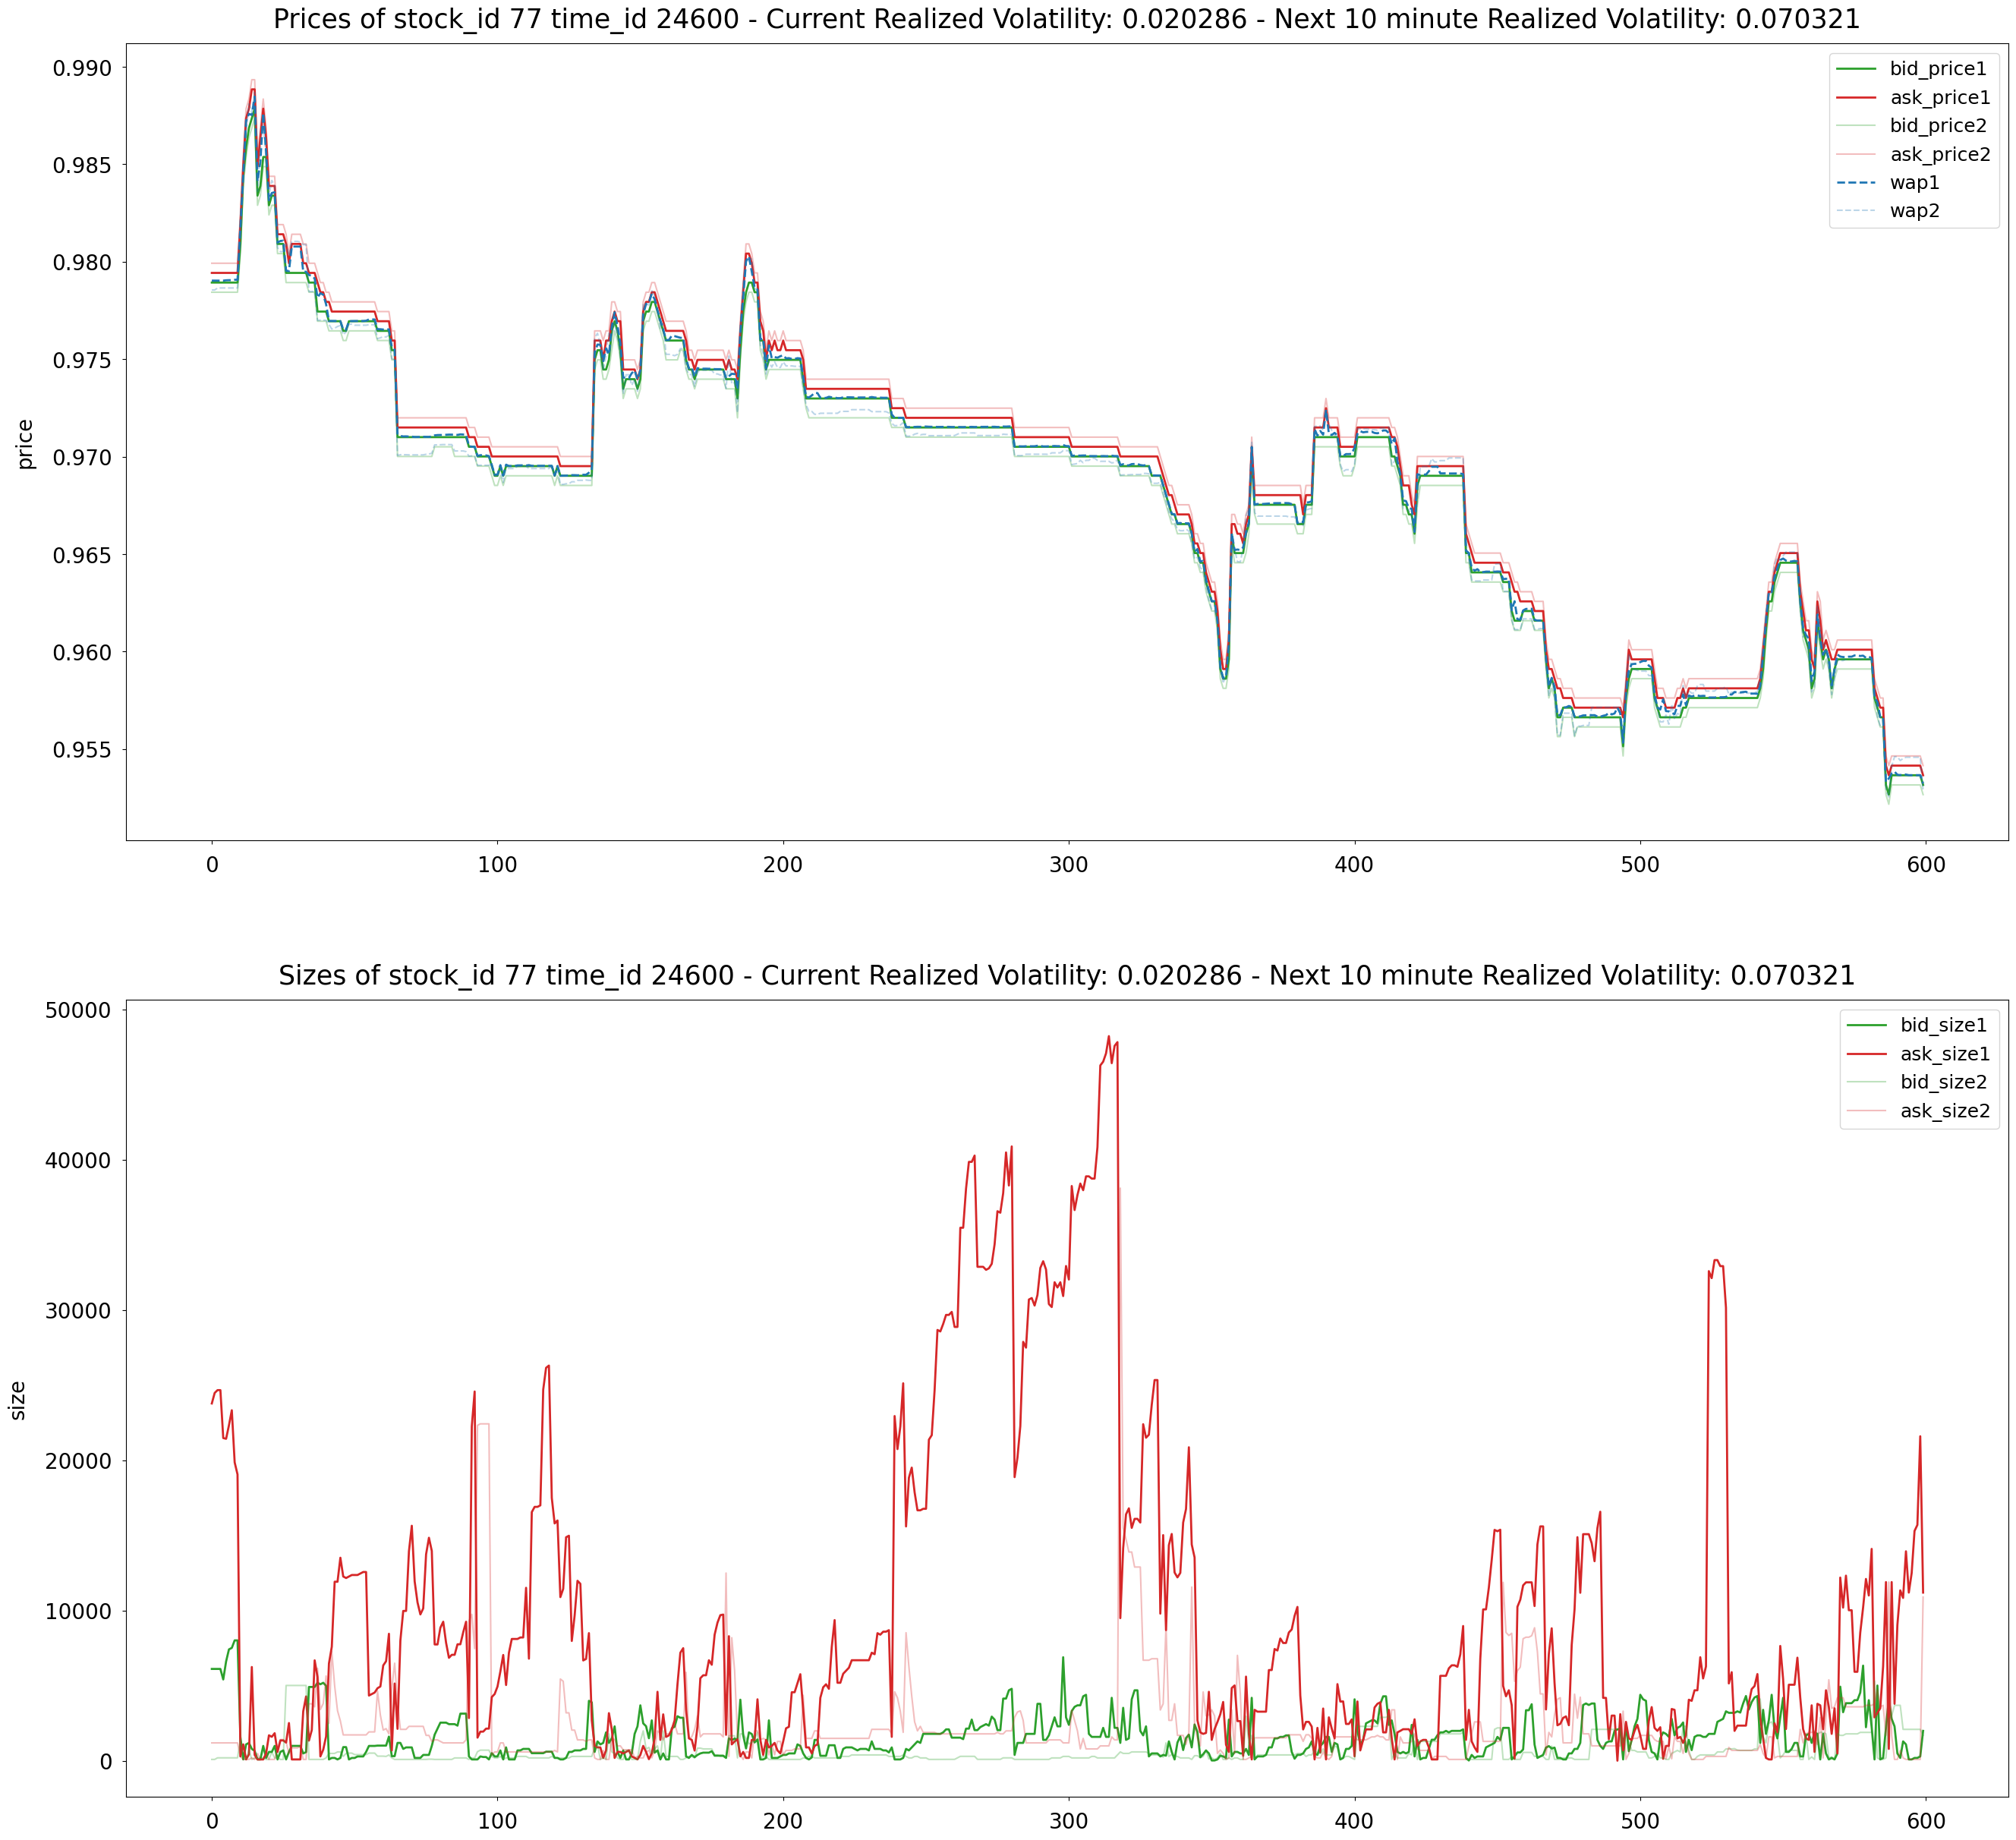

In [92]:
visualize_book_time_bucket(stock_id=77, time_id=24600)

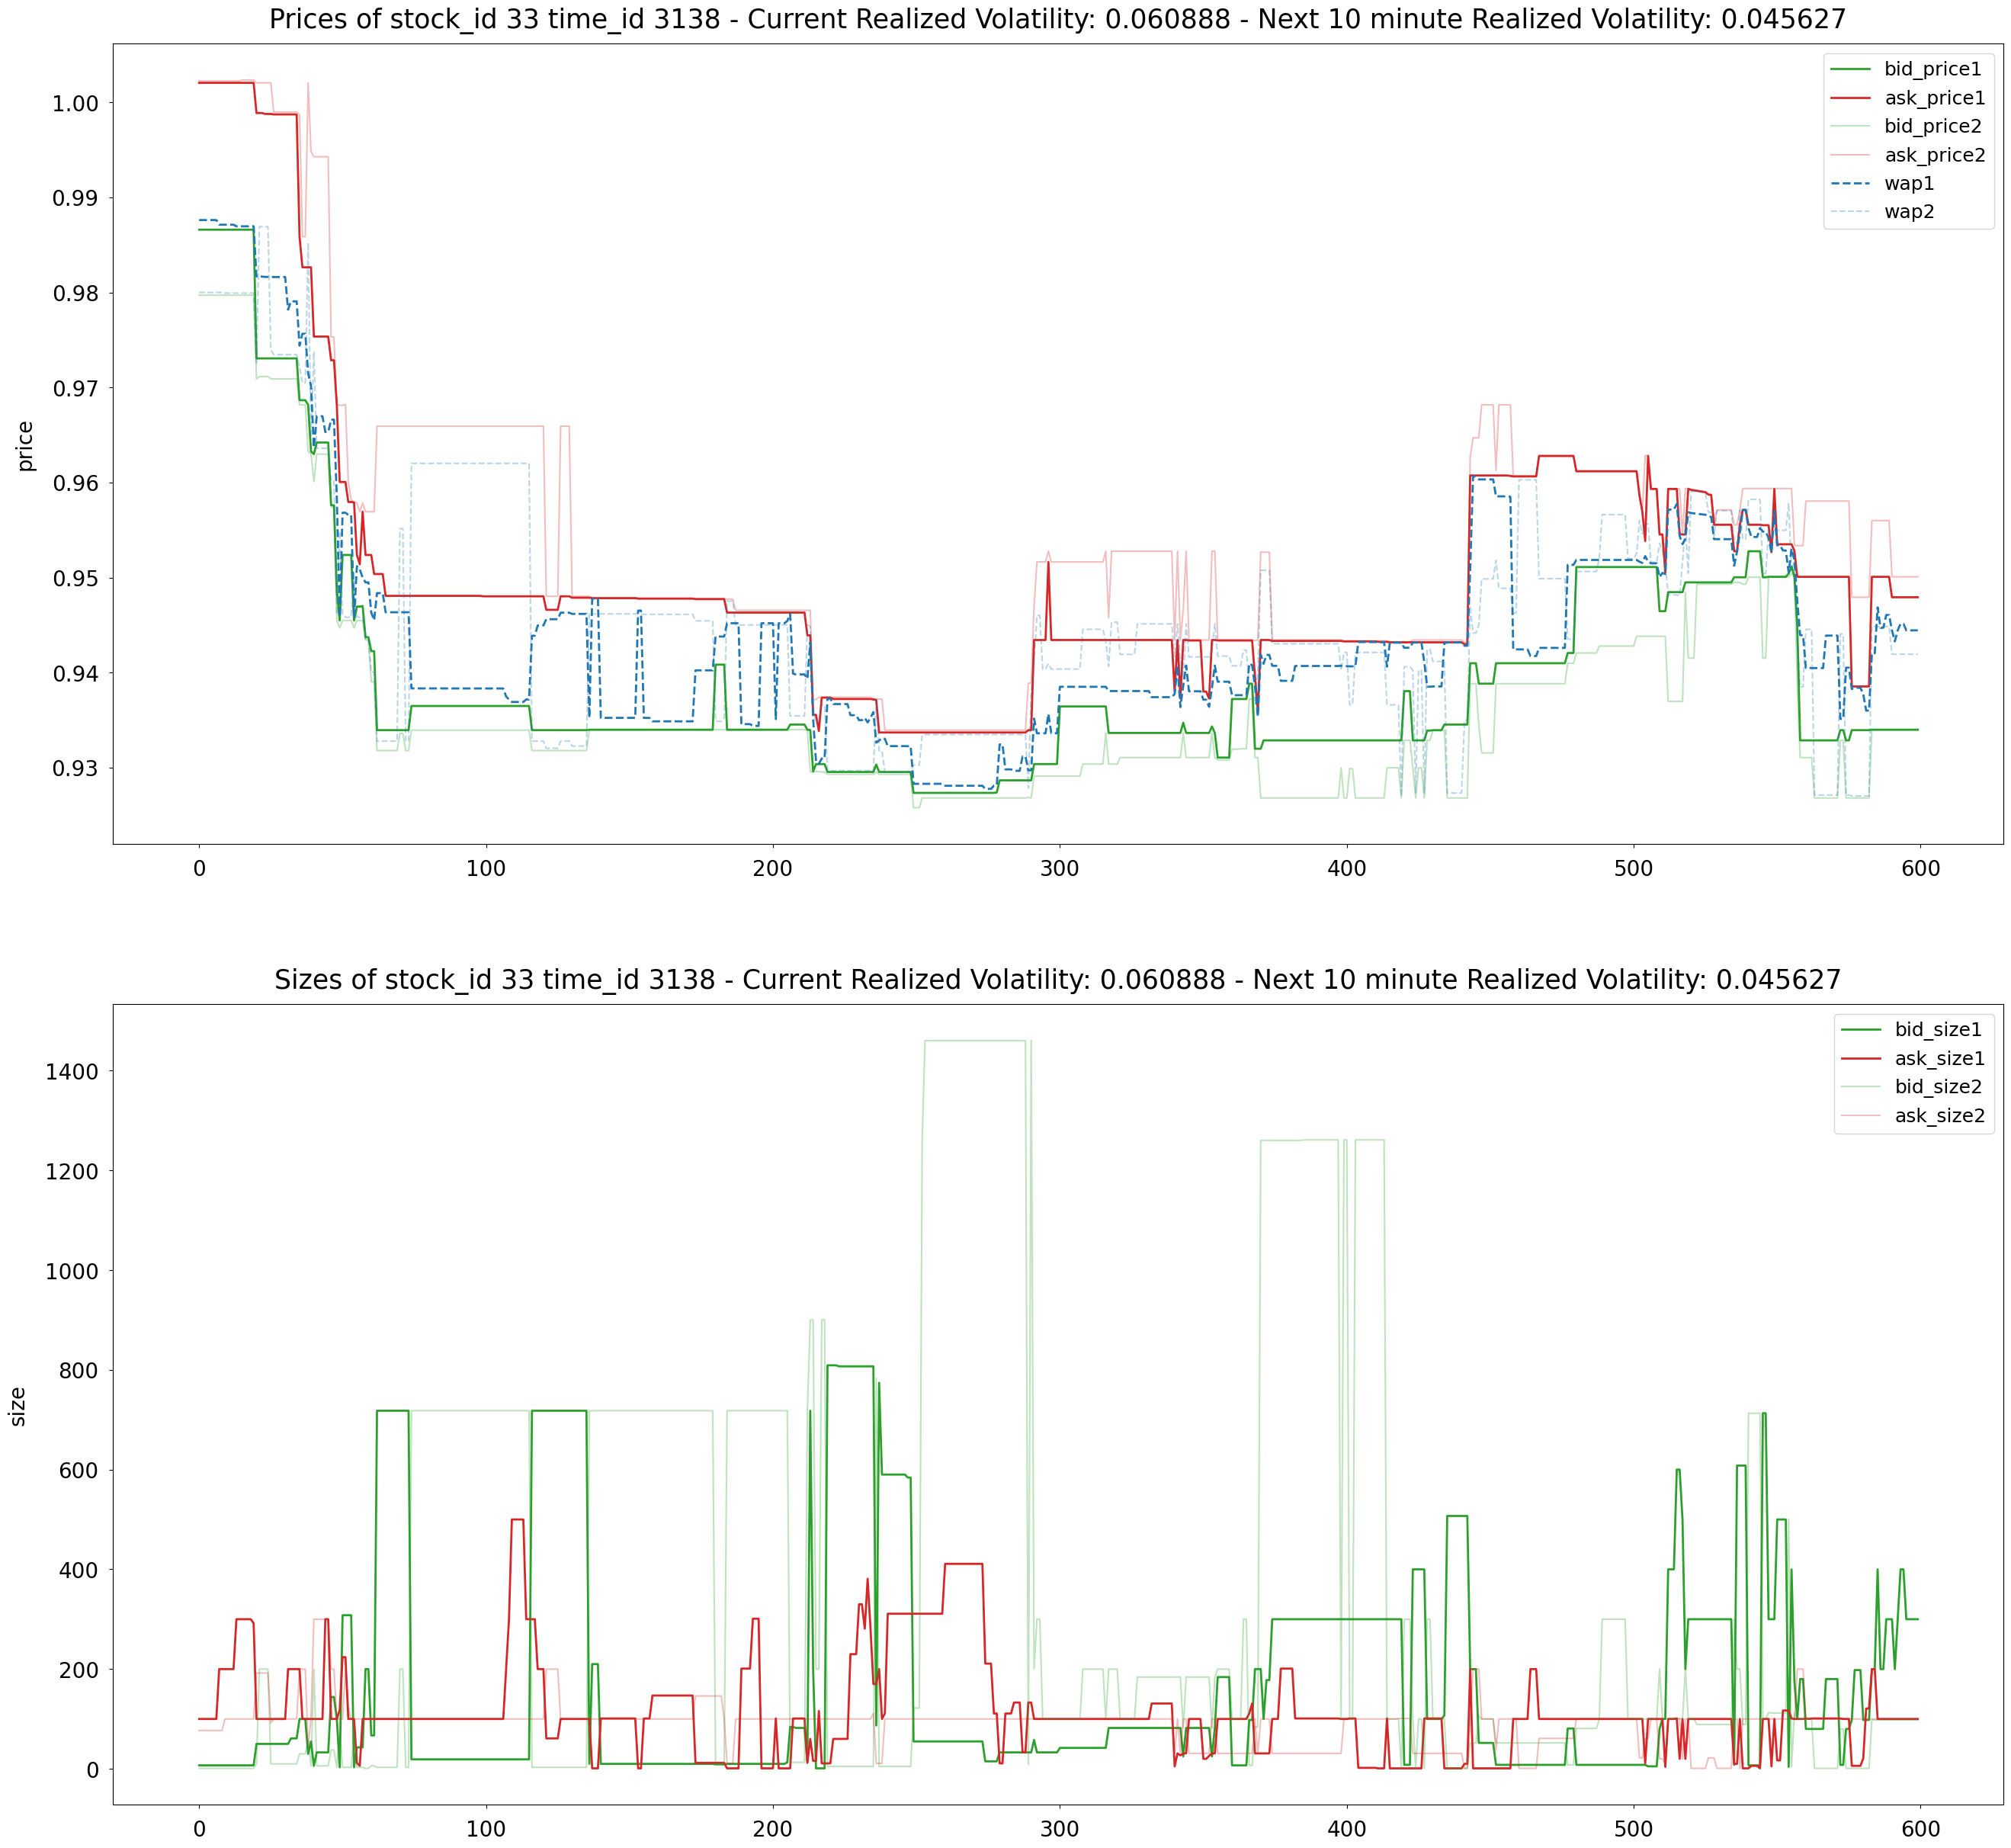

In [93]:
visualize_book_time_bucket(stock_id=33, time_id=3138)
# x axis is the seconds_in_bucket

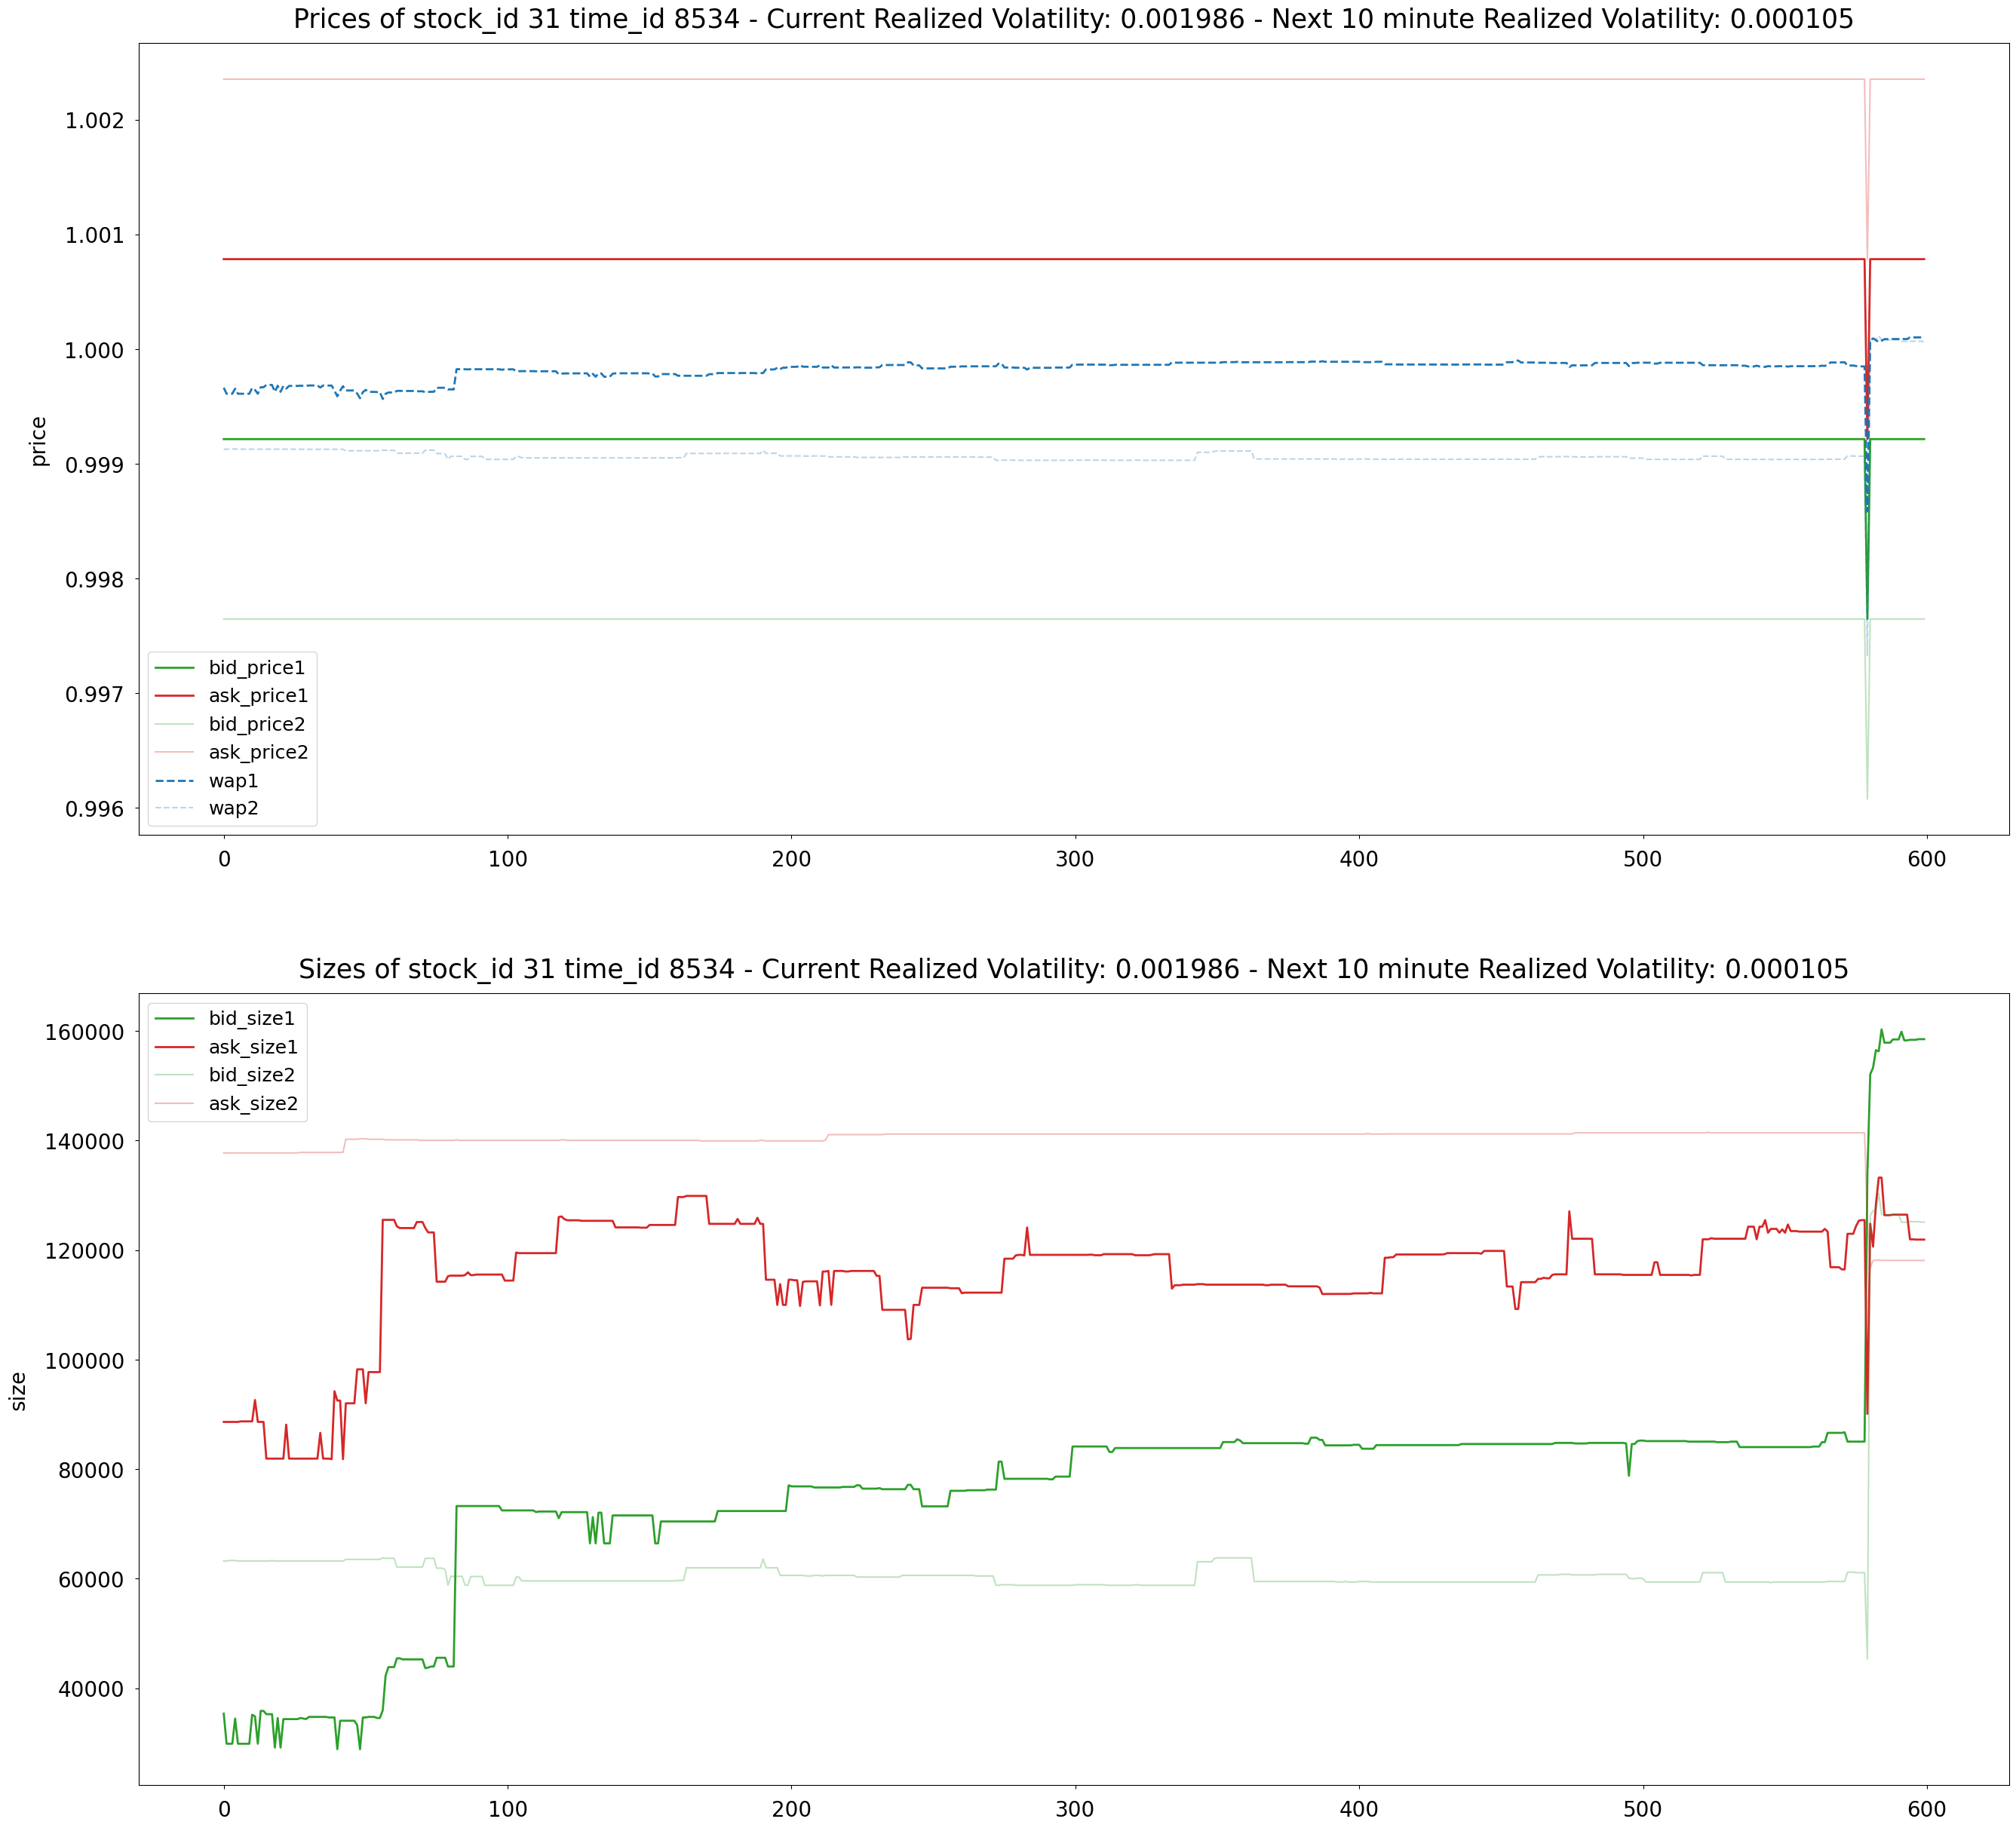

In [94]:
visualize_book_time_bucket(stock_id=31, time_id=8534)

# EDA for trade book

In [49]:
def read_trade_data(df, dataset, stock_id, sort=False, zero_fill=False):
        
    trade_dtypes = {
        'time_id': np.uint16,
        'seconds_in_bucket': np.uint16,
        'price': np.float32,
        'size': np.uint16,
        'order_count': np.uint16
    }

    df_trade = pd.read_parquet(f'../project/optiver-realized-volatility-prediction/trade_{dataset}.parquet/stock_id={stock_id}')
    
    # if zero_fill:
    #     stock_time_buckets = df.loc[df['stock_id'] == stock_id, 'time_id'].reset_index(drop=True)
    #     missing_time_buckets = stock_time_buckets[~stock_time_buckets.isin(df_trade['time_id'])]
    #     df_trade = df_trade.merge(missing_time_buckets, how='outer')
    
    if sort:
        df_trade.sort_values(by=['time_id', 'seconds_in_bucket'], inplace=True)
        
    # if zero_fill:
    #     df_trade = df_trade.set_index(['time_id', 'seconds_in_bucket'])
    #     df_trade = df_trade.reindex(
    #         pd.MultiIndex.from_product([df_trade.index.levels[0], np.arange(0, 600)], names=['time_id', 'seconds_in_bucket']),
    #     )
    #     df_trade.fillna(0, inplace=True)
    #     df_trade.reset_index(inplace=True)
    
    for column, dtype in trade_dtypes.items():
        df_trade[column] = df_trade[column].astype(dtype)

    return df_trade


In [50]:
df_trade0 = read_trade_data(train, 'train', 0)
df_trade0.head()

time_id  seconds_in_bucket     price  size  order_count
0        5                 21  1.002301   326           12
1        5                 46  1.002778   128            4
2        5                 50  1.002818    55            1
3        5                 57  1.003155   121            5
4        5                 68  1.003646     4            1

In [51]:
df_trade0.loc[df_trade0['time_id']==5]

time_id  seconds_in_bucket     price  size  order_count
0         5                 21  1.002301   326           12
1         5                 46  1.002778   128            4
2         5                 50  1.002818    55            1
3         5                 57  1.003155   121            5
4         5                 68  1.003646     4            1
5         5                 78  1.003762   134            5
6         5                122  1.004207   102            3
7         5                127  1.004577     1            1
8         5                144  1.004370     6            1
9         5                147  1.003964   233            4
10        5                177  1.003853     1            1
11        5                183  1.003956     2            1
12        5                187  1.004267   165            2
13        5                207  1.003543    72            4
14        5                218  1.004155    33            5
15        5                254  1.003905   100            1
16        5                263  1.003905     1            1
17        5                265  1.004111     2            2
18        5                278  1.004370   106            2
19        5                331  1.004680     3            2
20        5                366  1.004215     6            2
21        5                380  1.004116   432            9
22        5                389  1.004422     1            1
23        5                398  1.004215   100            1
24        5                430  1.003853     2            1
25        5                435  1.003905     1            1
26        5                464  1.003749     2            1
27        5                470  1.003465   200            7
28        5                471  1.003646   101            2
29        5                488  1.003905     2            1
30        5                514  1.004012    29            3
31        5                523  1.004008     1            1
32        5                540  1.003543     4            1
33        5                549  1.003129     2            1
34        5                550  1.002799    13            3
35        5                551  1.002561   154            5
36        5                562  1.002715     1            1
37        5                572  1.003191   499            6
38        5                581  1.003478     8            3
39        5                585  1.003646    26            2

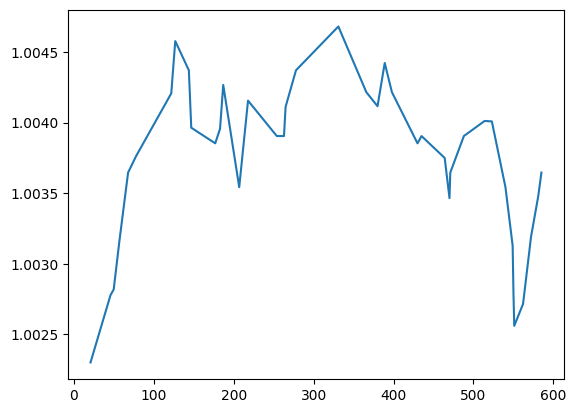

In [52]:
plt.plot(df_trade0.loc[df_trade0['time_id']==5, 'seconds_in_bucket'], df_trade0.loc[df_trade0['time_id']==5, 'price'])

In [53]:
df_trade0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123443 entries, 0 to 123442
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            123443 non-null  uint16 
 1   seconds_in_bucket  123443 non-null  uint16 
 2   price              123443 non-null  float32
 3   size               123443 non-null  uint16 
 4   order_count        123443 non-null  uint16 
dtypes: float32(1), uint16(4)
memory usage: 1.4 MB


In [54]:
df_trade100 = read_trade_data(train, 'train', 100)
df_trade100.head()

time_id  seconds_in_bucket     price  size  order_count
0        5                  5  1.000103     7            2
1        5                  6  1.000239   201            4
2        5                  9  1.000444     1            1
3        5                 28  1.000376    12            3
4        5                 30  1.000444     3            1

In [55]:

df_trade100.info()
len(pd.unique(df_trade100['time_id']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293993 entries, 0 to 293992
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            293993 non-null  uint16 
 1   seconds_in_bucket  293993 non-null  uint16 
 2   price              293993 non-null  float32
 3   size               293993 non-null  uint16 
 4   order_count        293993 non-null  uint16 
dtypes: float32(1), uint16(4)
memory usage: 3.4 MB


3829

In [56]:
for stock_id in tqdm(sorted(train['stock_id'].unique())):
            
    df_trade = read_trade_data(train, 'train', stock_id)

    # Realized volatility
    for wap in [1, 2]:
        df_trade['log_return_from_price'] = np.log(df_trade['price'] / df_trade.groupby('time_id')['price'].shift(1))
        df_trade['squared_log_return_from_price'] = df_trade['log_return_from_price'] ** 2
        df_trade['realized_volatility_from_price'] = np.sqrt(df_trade.groupby('time_id')['squared_log_return_from_price'].transform('sum'))
        df_trade.drop(columns=['squared_log_return_from_price'], inplace=True)            
        realized_volatilities = df_trade.groupby('time_id')['realized_volatility_from_price'].first().to_dict()
        train.loc[train['stock_id'] == stock_id, 'realized_volatility_from_price'] = train[train['stock_id'] == stock_id]['time_id'].map(realized_volatilities)


  0%|          | 0/112 [00:00<?, ?it/s]

In [57]:
train.head()

stock_id  time_id    target  realized_volatility_from_wap1  \
0         0        5  0.004136                       0.004499   
1         0       11  0.001445                       0.001204   
2         0       16  0.002168                       0.002369   
3         0       31  0.002195                       0.002574   
4         0       62  0.001747                       0.001894   

   realized_volatility_from_wap2  realized_volatility_from_price  
0                       0.006999                        0.002006  
1                       0.002476                        0.000901  
2                       0.004801                        0.001961  
3                       0.003637                        0.001561  
4                       0.003257                        0.000871

In [58]:
realized_volatility_price_rmspe = root_mean_squared_percentage_error(train['target'], train['realized_volatility_from_price'])
print(f'Realized Volatility from price RMPSE: {realized_volatility_price_rmspe:.6}')

Realized Volatility from price RMPSE: 0.380267


In [60]:
def visualize_trade_time_bucket(stock_id, time_id):
    
    time_bucket = (train['stock_id'] == stock_id) & (train['time_id'] == time_id)
    
    target = train.loc[time_bucket, 'target'].iloc[0]
    realized_volatility = train.loc[time_bucket, 'realized_volatility_from_wap1'].iloc[0]
    # df_trade = read_trade_data(train, 'train', stock_id, sort=True, zero_fill=True)
    df_trade = read_trade_data(train, 'train', stock_id, sort=True)
    df_trade = df_trade.set_index('seconds_in_bucket')
    
    fig, axes = plt.subplots(figsize=(32, 35), nrows=3)

    axes[0].plot(df_trade.loc[(df_trade['time_id'] == time_id), 'price'], label='price', lw=2, linestyle='-', color='tab:blue')
    axes[1].plot(df_trade.loc[(df_trade['time_id'] == time_id), 'size'], label='size', lw=2, linestyle='-', color='tab:blue')
    axes[2].plot(df_trade.loc[(df_trade['time_id'] == time_id), 'order_count'], label='order_count', lw=2, linestyle='-', color='tab:blue')
    
    for i in range(3):
        axes[i].legend(prop={'size': 18})
        axes[i].tick_params(axis='x', labelsize=20, pad=10)
        axes[i].tick_params(axis='y', labelsize=20, pad=10)
    axes[0].set_ylabel('price', size=20, labelpad=15)
    axes[1].set_ylabel('size', size=20, labelpad=15)
    axes[2].set_ylabel('order_count', size=20, labelpad=15)

    axes[0].set_title(
        f'Price of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[1].set_title(
        f'Size of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )
    axes[2].set_title(
        f'Size of stock_id {stock_id} time_id {time_id} - Current Realized Volatility: {realized_volatility:.6f} - Next 10 minute Realized Volatility: {target:.6f}',
        size=25,
        pad=15
    )

    plt.show()


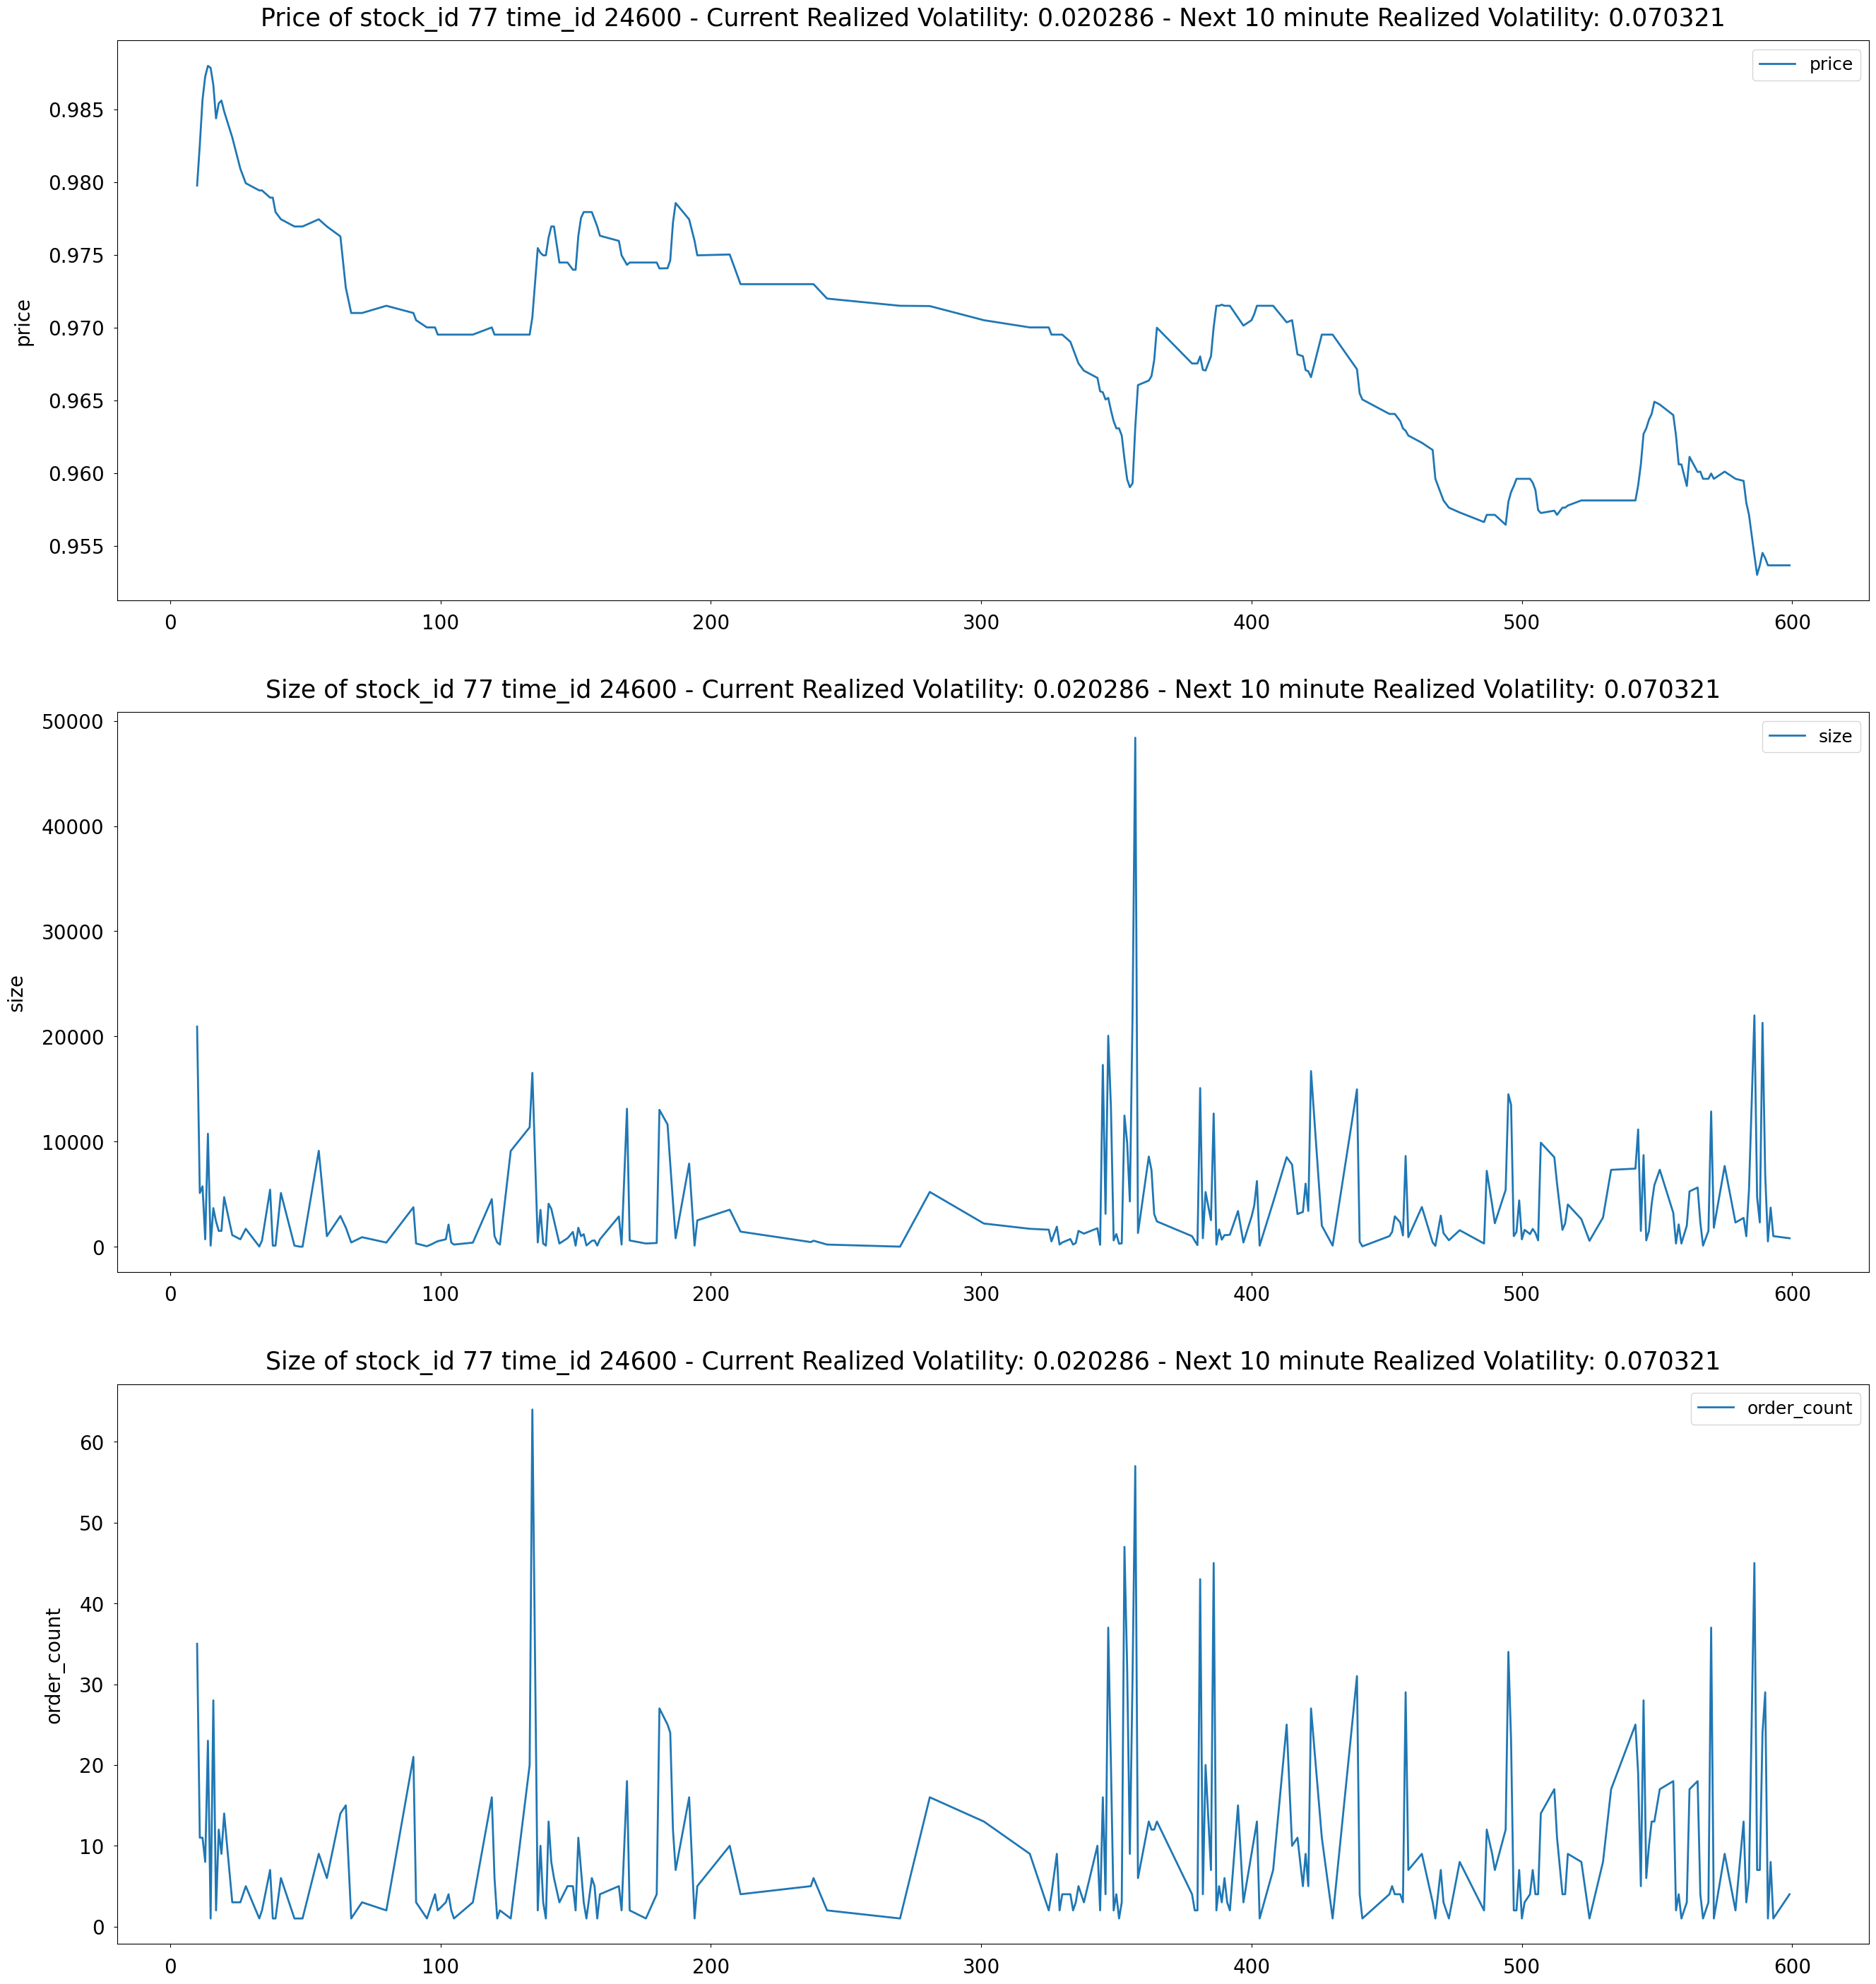

In [95]:
visualize_trade_time_bucket(stock_id=77, time_id=24600)

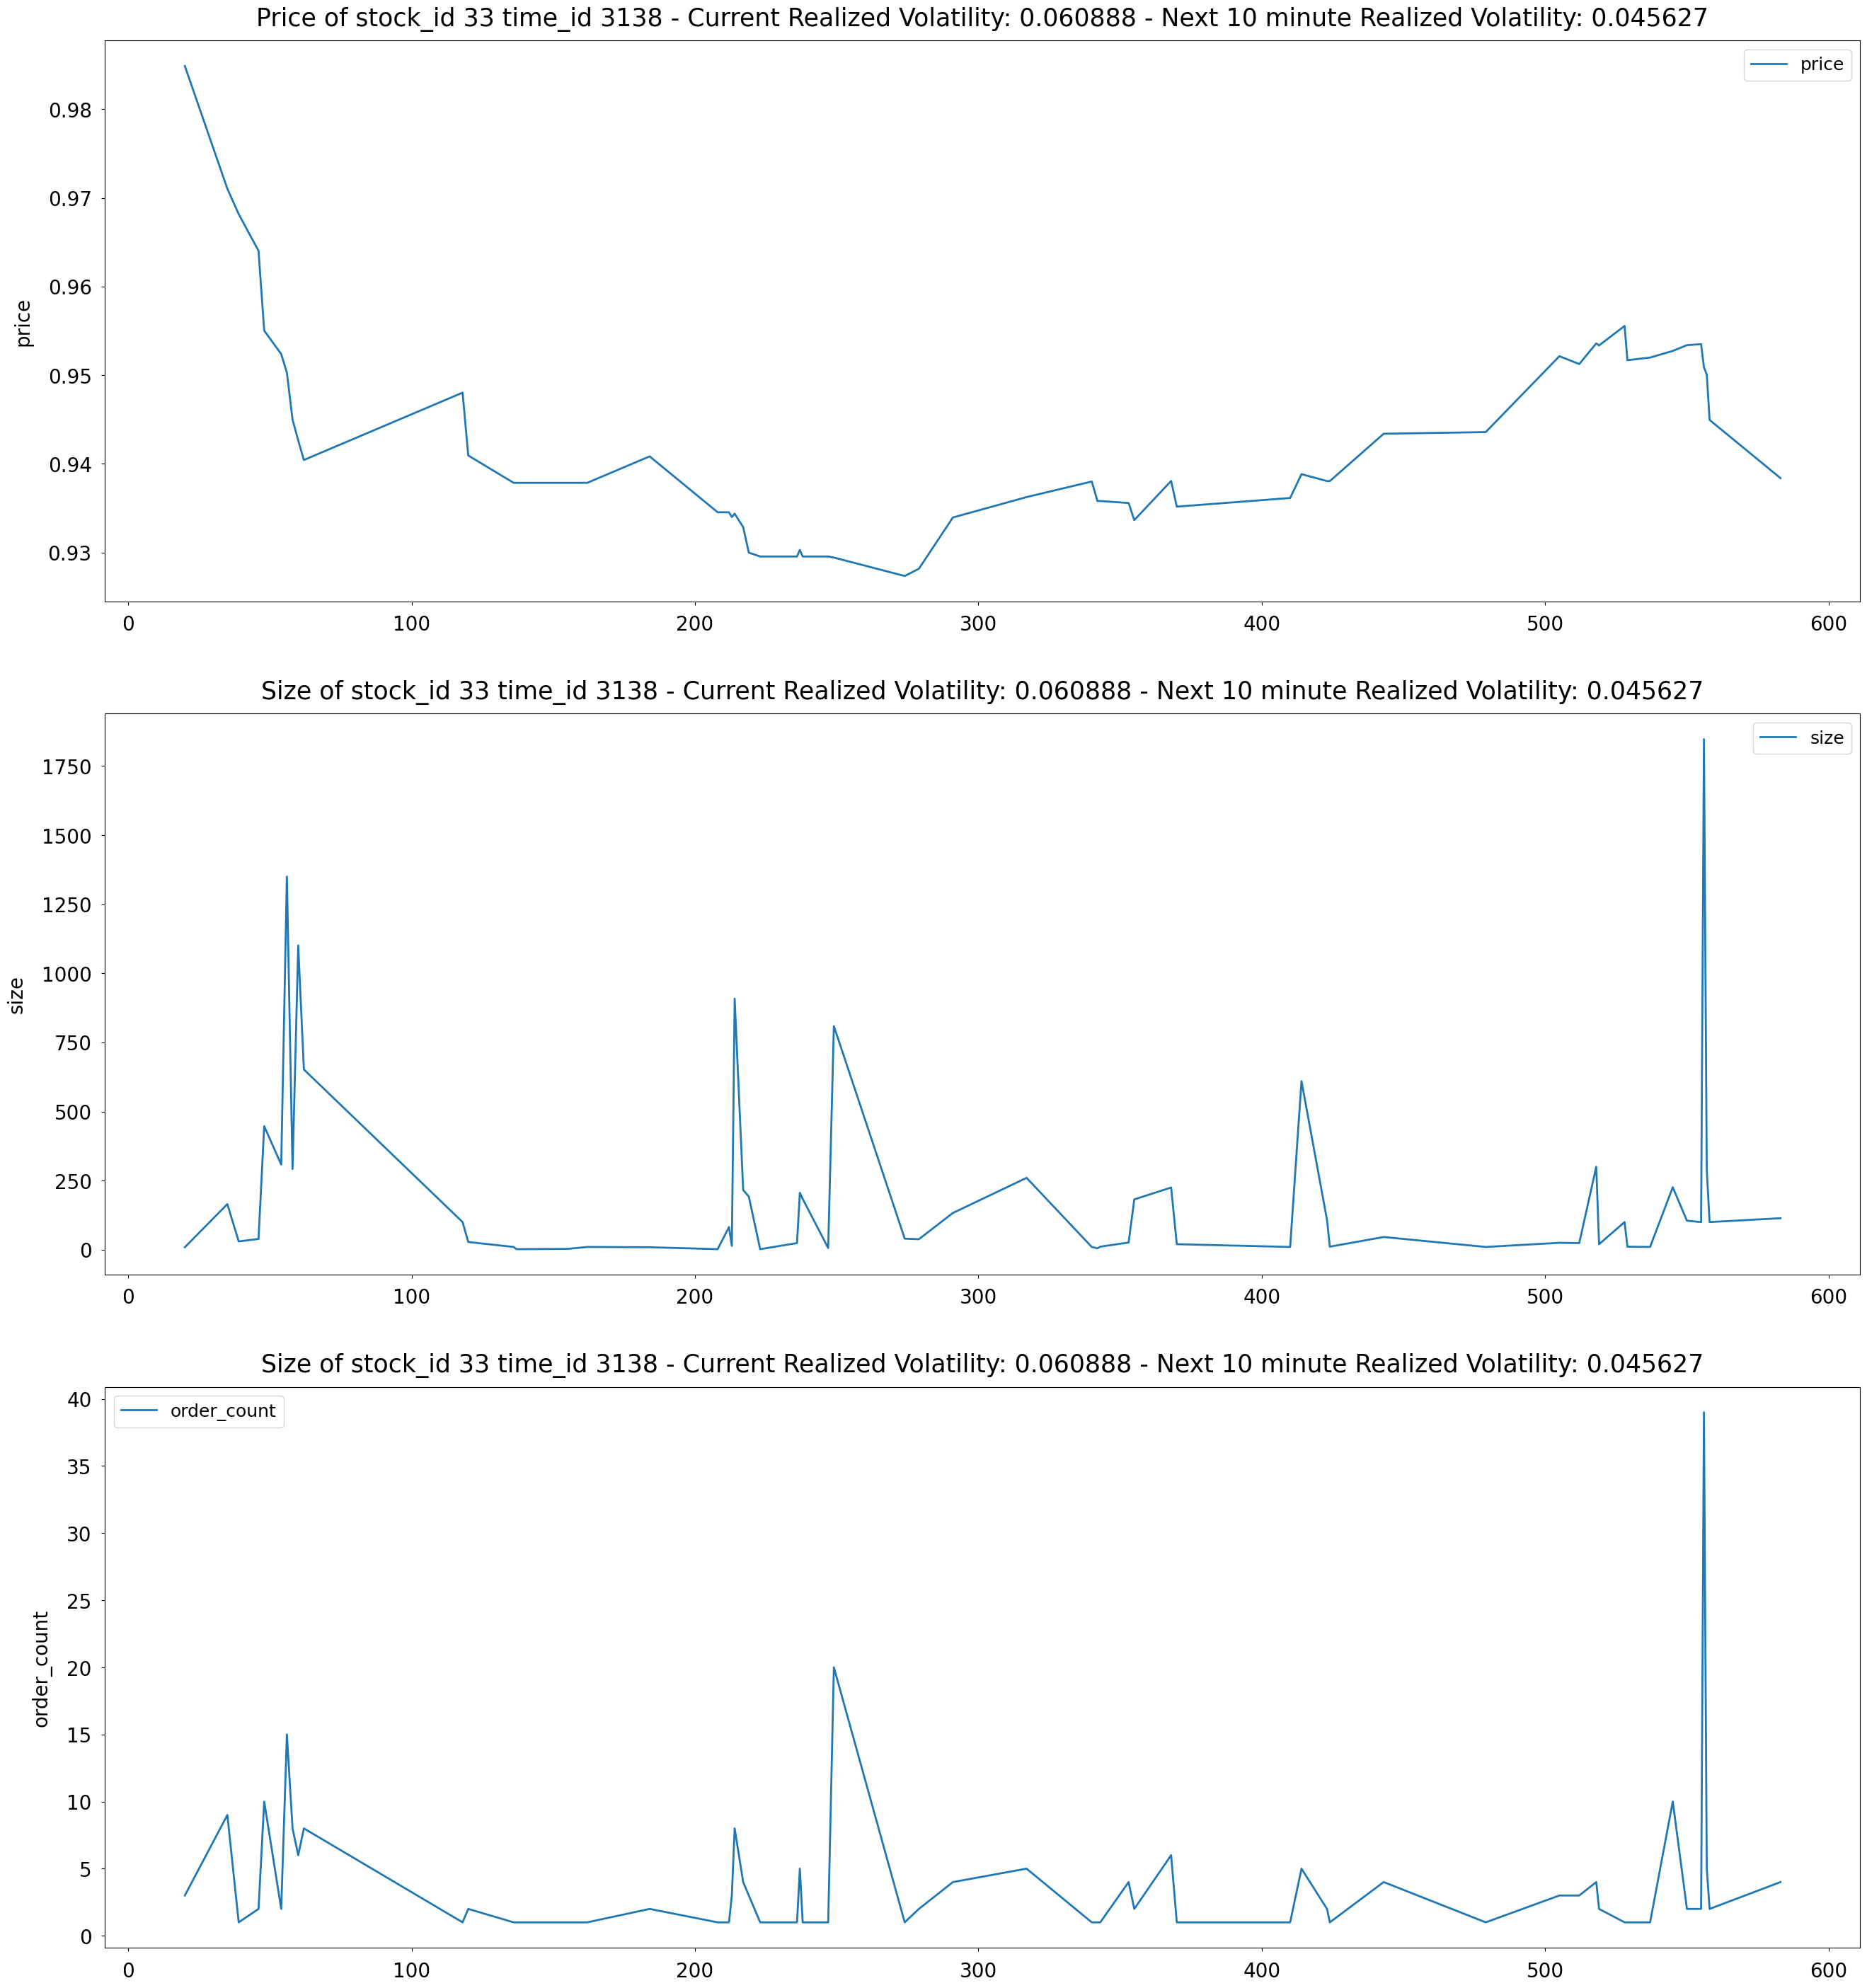

In [96]:
visualize_trade_time_bucket(stock_id=33, time_id=3138)

# Feature Engineering
bid_ask_price_ratio, mean, standard deviation, min and max
groupby.agg() is a function to use for aggregating the data, for example sum(), mean(), count(), max(), and min(), std(). Same as groupby.apply(func)

In [63]:
def log_return(x):
    return np.log(x).diff()

def realized_volatility(x):
    return np.sqrt(np.sum(log_return(x) ** 2))

for stock_id in tqdm(sorted(train['stock_id'].unique())):

    df_book = read_book_data('train', stock_id)

    # Bid/Ask ratio aggregations
    df_book['bid_ask_price_ratio'] = df_book['bid_price1'] / df_book['ask_price1']
    for agg in ['mean', 'std', 'min', 'max', realized_volatility]:
        bid_ask_price_ratio_aggregation = df_book.groupby('time_id')['bid_ask_price_ratio'].agg(agg)
        feature_name = agg.__name__ if callable(agg) else agg
        train.loc[train['stock_id'] == stock_id, f'book_bid_ask_price_ratio_{feature_name}'] = train[train['stock_id'] == stock_id]['time_id'].map(bid_ask_price_ratio_aggregation)
        
    # Weighted averaged prices
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) /\
                      (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) /\
                      (df_book['bid_size2'] + df_book['ask_size2'])

    for wap in [1, 2]:
        for agg in ['mean', 'std', 'min', 'max', realized_volatility]:
            wap_aggregation = df_book.groupby('time_id')[f'wap{wap}'].agg(agg)
            feature_name = agg.__name__ if callable(agg) else agg
            train.loc[train['stock_id'] == stock_id, f'wap{wap}_{feature_name}'] = train[train['stock_id'] == stock_id]['time_id'].map(wap_aggregation)


  0%|          | 0/112 [00:00<?, ?it/s]

In [64]:
train.head()

stock_id  time_id    target  realized_volatility_from_wap1  \
0         0        5  0.004136                       0.004499   
1         0       11  0.001445                       0.001204   
2         0       16  0.002168                       0.002369   
3         0       31  0.002195                       0.002574   
4         0       62  0.001747                       0.001894   

   realized_volatility_from_wap2  realized_volatility_from_price  \
0                       0.006999                        0.002006   
1                       0.002476                        0.000901   
2                       0.004801                        0.001961   
3                       0.003637                        0.001561   
4                       0.003257                        0.000871   

   book_bid_ask_price_ratio_mean  book_bid_ask_price_ratio_std  \
0                       0.999149                      0.000211   
1                       0.999606                      0.000157   
2                       0.999275                      0.000163   
3                       0.999140                      0.000280   
4                       0.999603                      0.000130   

   book_bid_ask_price_ratio_min  book_bid_ask_price_ratio_max  ...  wap1_mean  \
0                      0.998608                      0.999640  ...   1.003725   
1                      0.999097                      0.999849  ...   1.000239   
2                      0.998852                      0.999616  ...   0.999542   
3                      0.998379                      0.999676  ...   0.998832   
4                      0.999208                      0.999907  ...   0.999619   

   wap1_std  wap1_min  wap1_max  wap1_realized_volatility  wap2_mean  \
0  0.000693  1.001434  1.004920                  0.004499   1.003661   
1  0.000262  0.999700  1.000834                  0.001204   1.000206   
2  0.000864  0.997224  1.000878                  0.002369   0.999680   
3  0.000757  0.997447  1.000412                  0.002574   0.998633   
4  0.000258  0.999231  1.000159                  0.001894   0.999626   

   wap2_std  wap2_min  wap2_max  wap2_realized_volatility  
0  0.000781  1.001390  1.005124                  0.006999  
1  0.000272  0.999575  1.001067                  0.002476  
2  0.000862  0.996896  1.000876                  0.004801  
3  0.000656  0.997430  1.000116                  0.003637  
4  0.000317  0.999102  1.000249                  0.003257  

[5 rows x 21 columns]

book_bid_ask_price_ratio_mean
-----------------------------
Training Mean: 0.9993  - Training Median: 0.9996 - Training Std: 0.0006739
Training Min: 0.9813  - Training Max: 1.0
Training Skew: -3.975  - Training Kurtosis: 32.48


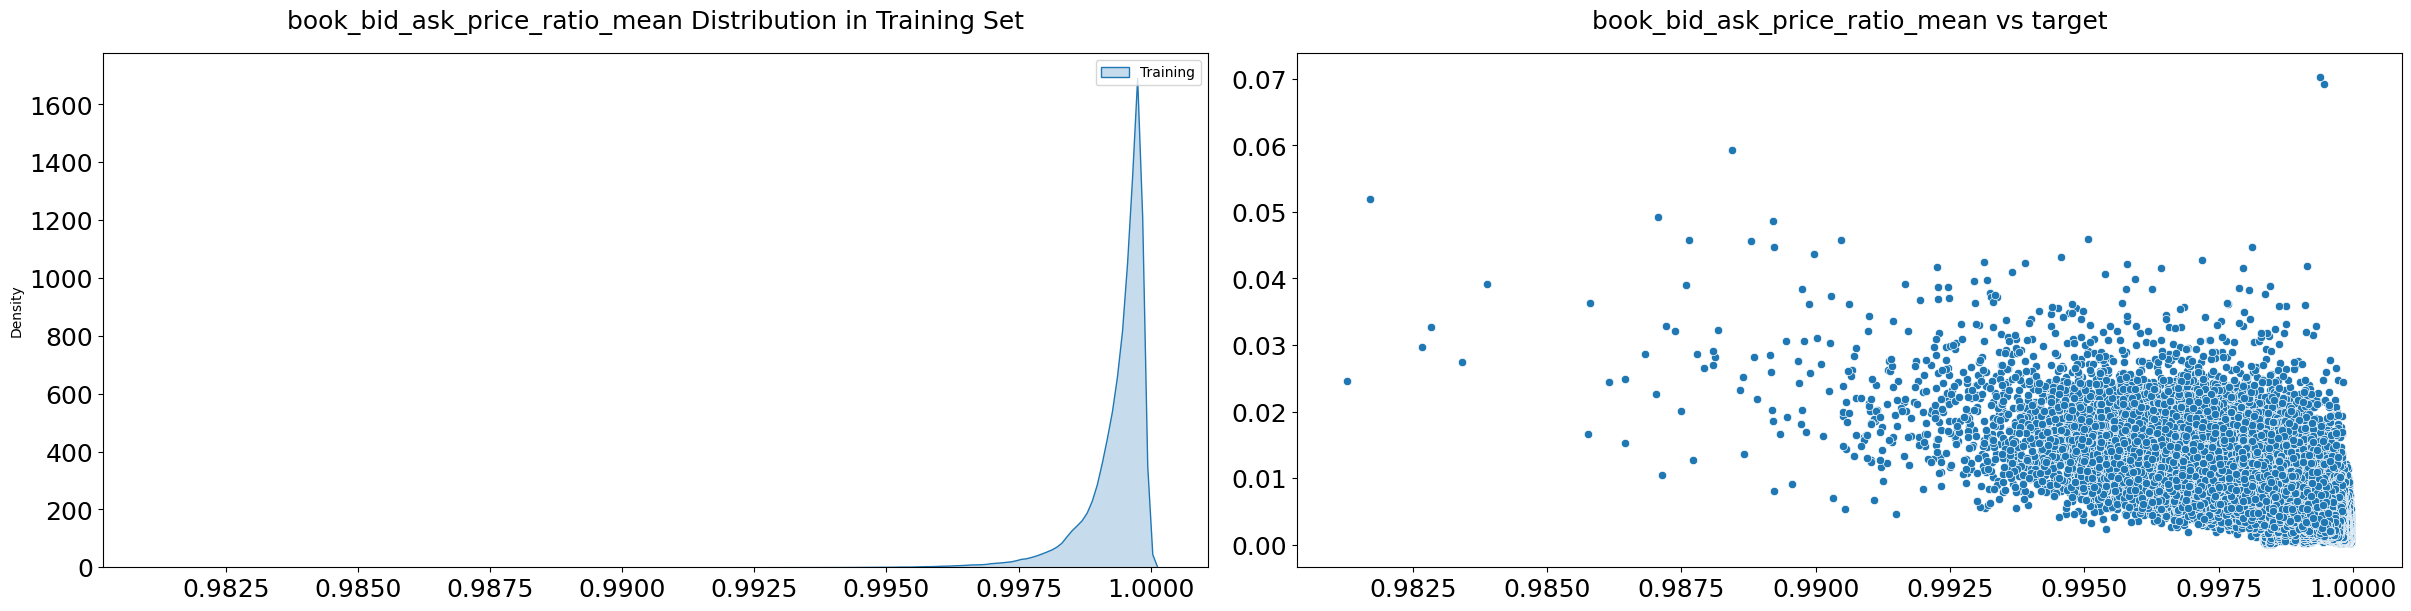

book_bid_ask_price_ratio_std
----------------------------
Training Mean: 0.0002196  - Training Median: 0.0001479 - Training Std: 0.0002727
Training Min: 0.0  - Training Max: 0.01006
Training Skew: 5.675  - Training Kurtosis: 64.22


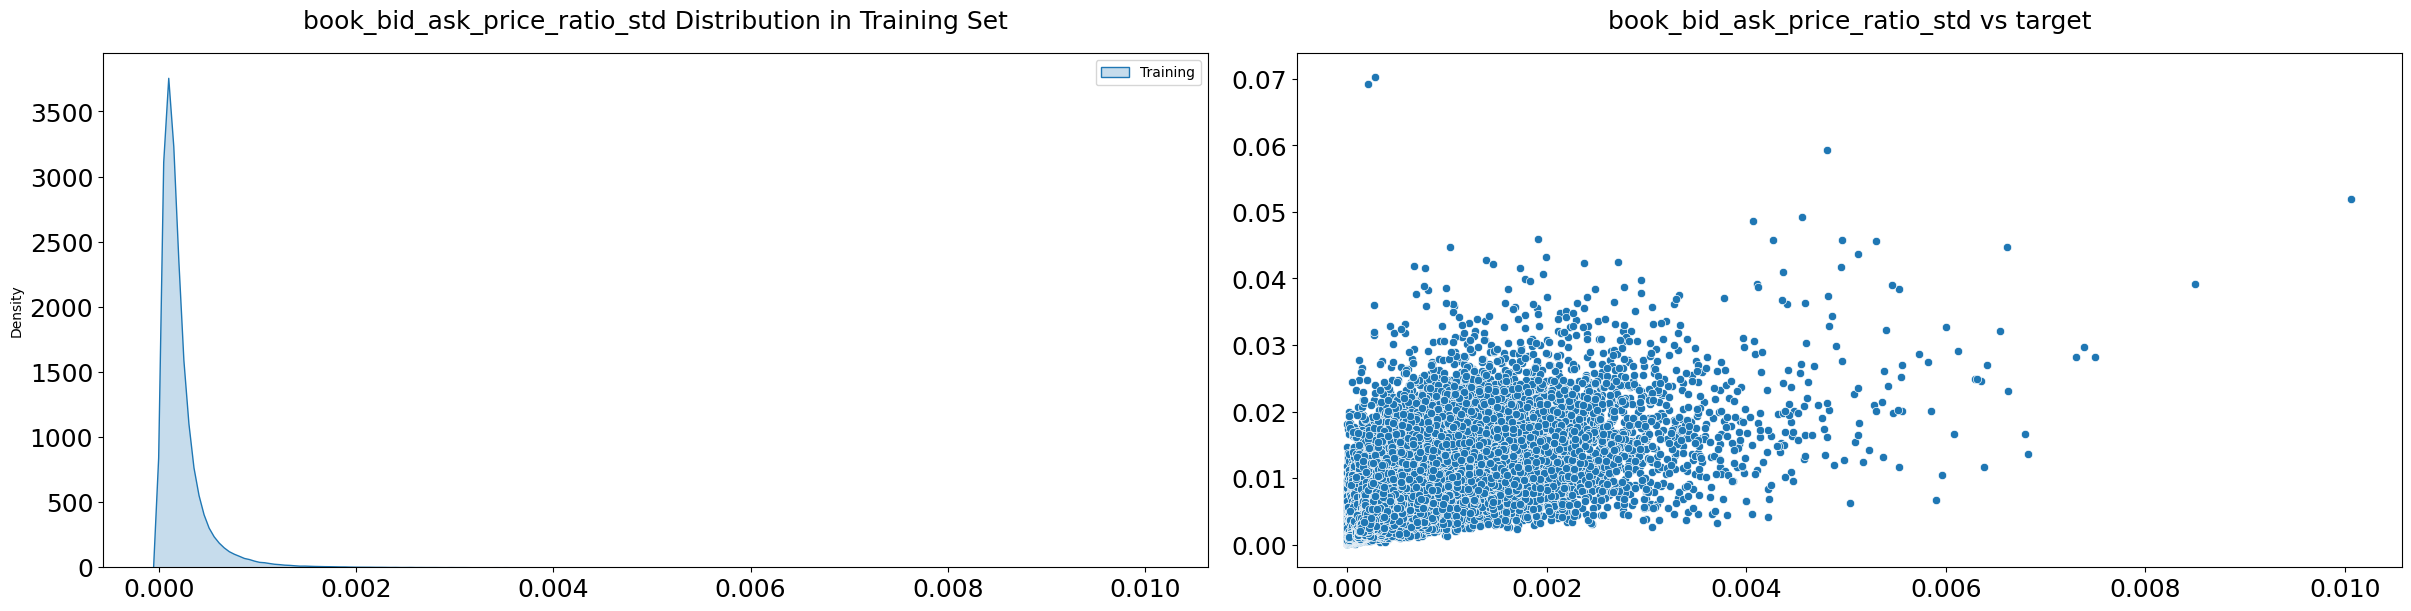

book_bid_ask_price_ratio_min
----------------------------
Training Mean: 0.9986  - Training Median: 0.9991 - Training Std: 0.00158
Training Min: 0.9522  - Training Max: 0.9999
Training Skew: -4.826  - Training Kurtosis: 44.94


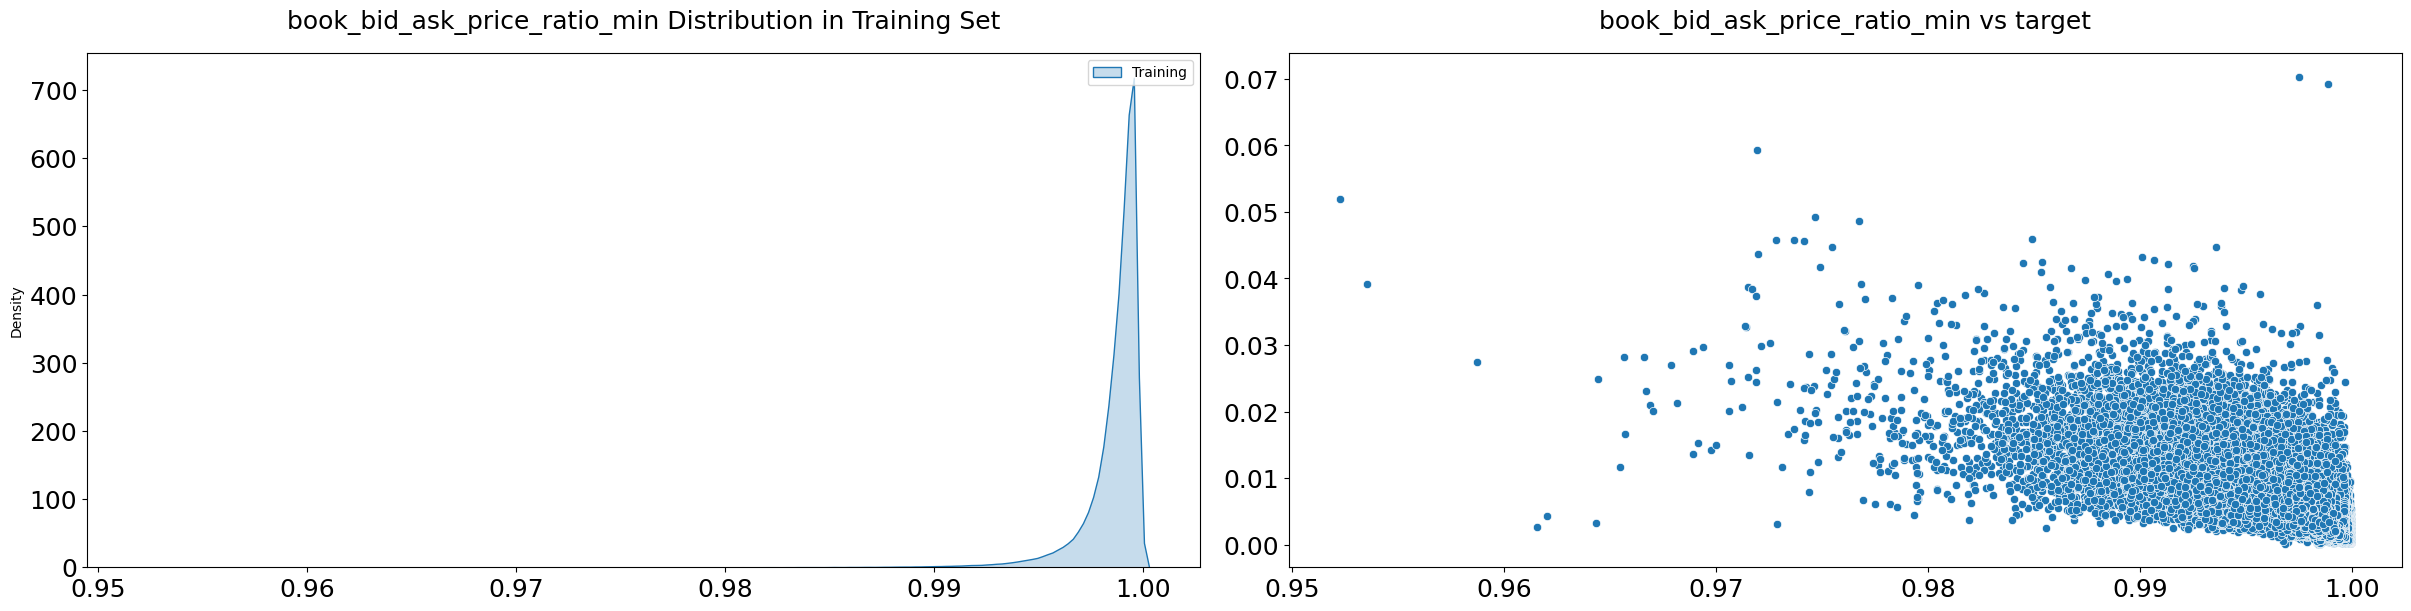

book_bid_ask_price_ratio_max
----------------------------
Training Mean: 0.9998  - Training Median: 0.9998 - Training Std: 0.0002473
Training Min: 0.992  - Training Max: 1.0
Training Skew: -3.949  - Training Kurtosis: 30.06


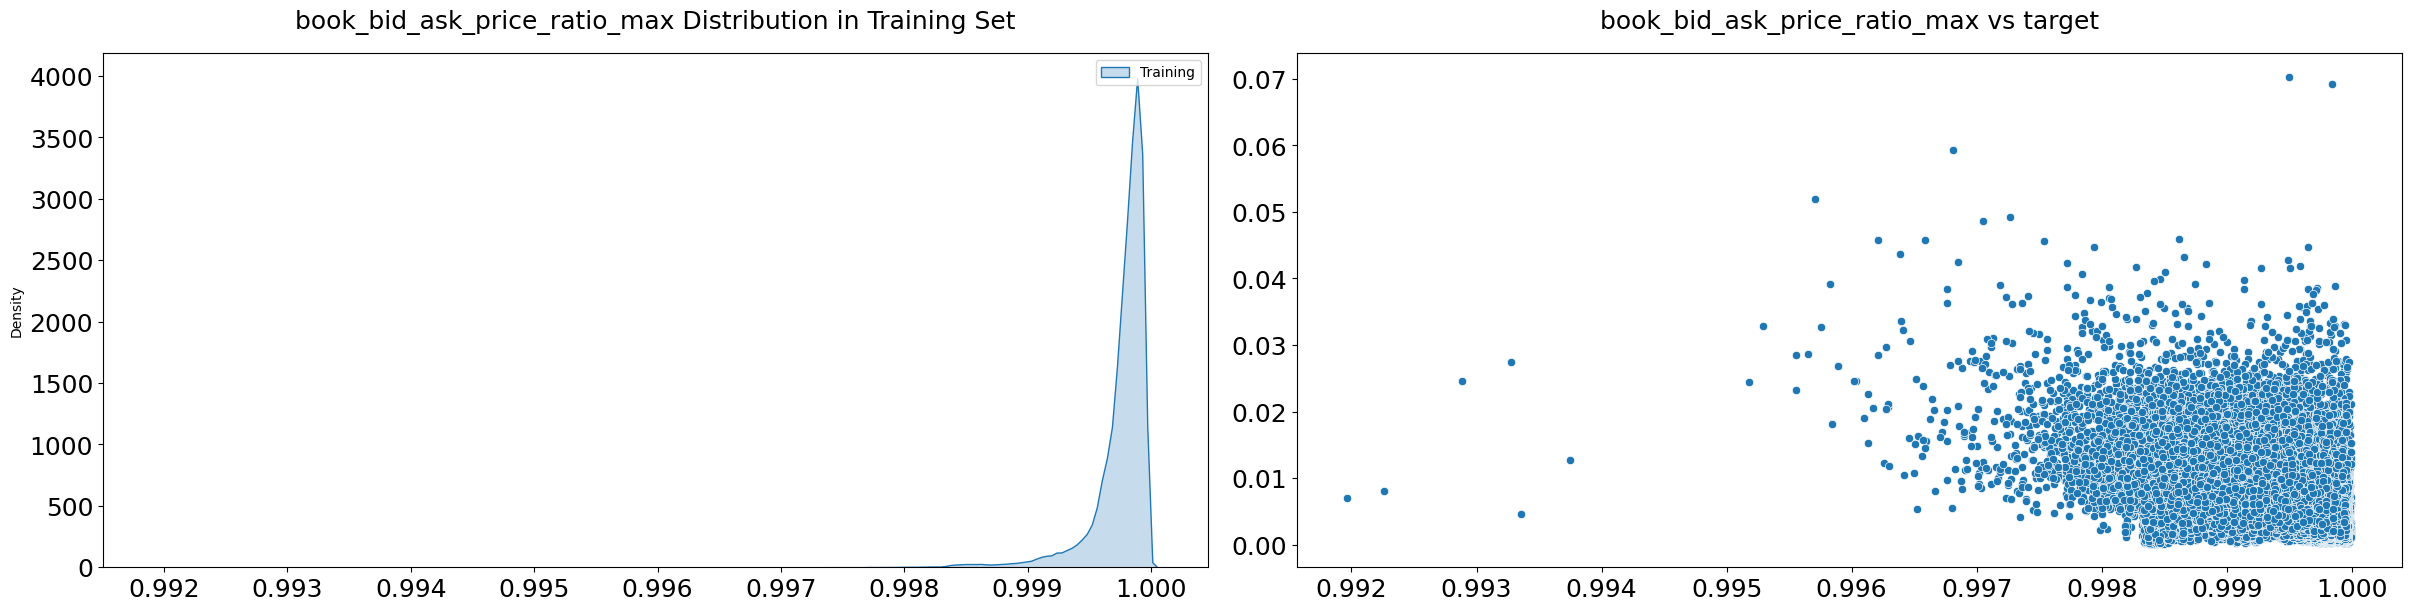

book_bid_ask_price_ratio_realized_volatility
--------------------------------------------
Training Mean: 0.002893  - Training Median: 0.002083 - Training Std: 0.002879
Training Min: 0.0  - Training Max: 0.06794
Training Skew: 4.321  - Training Kurtosis: 35.27


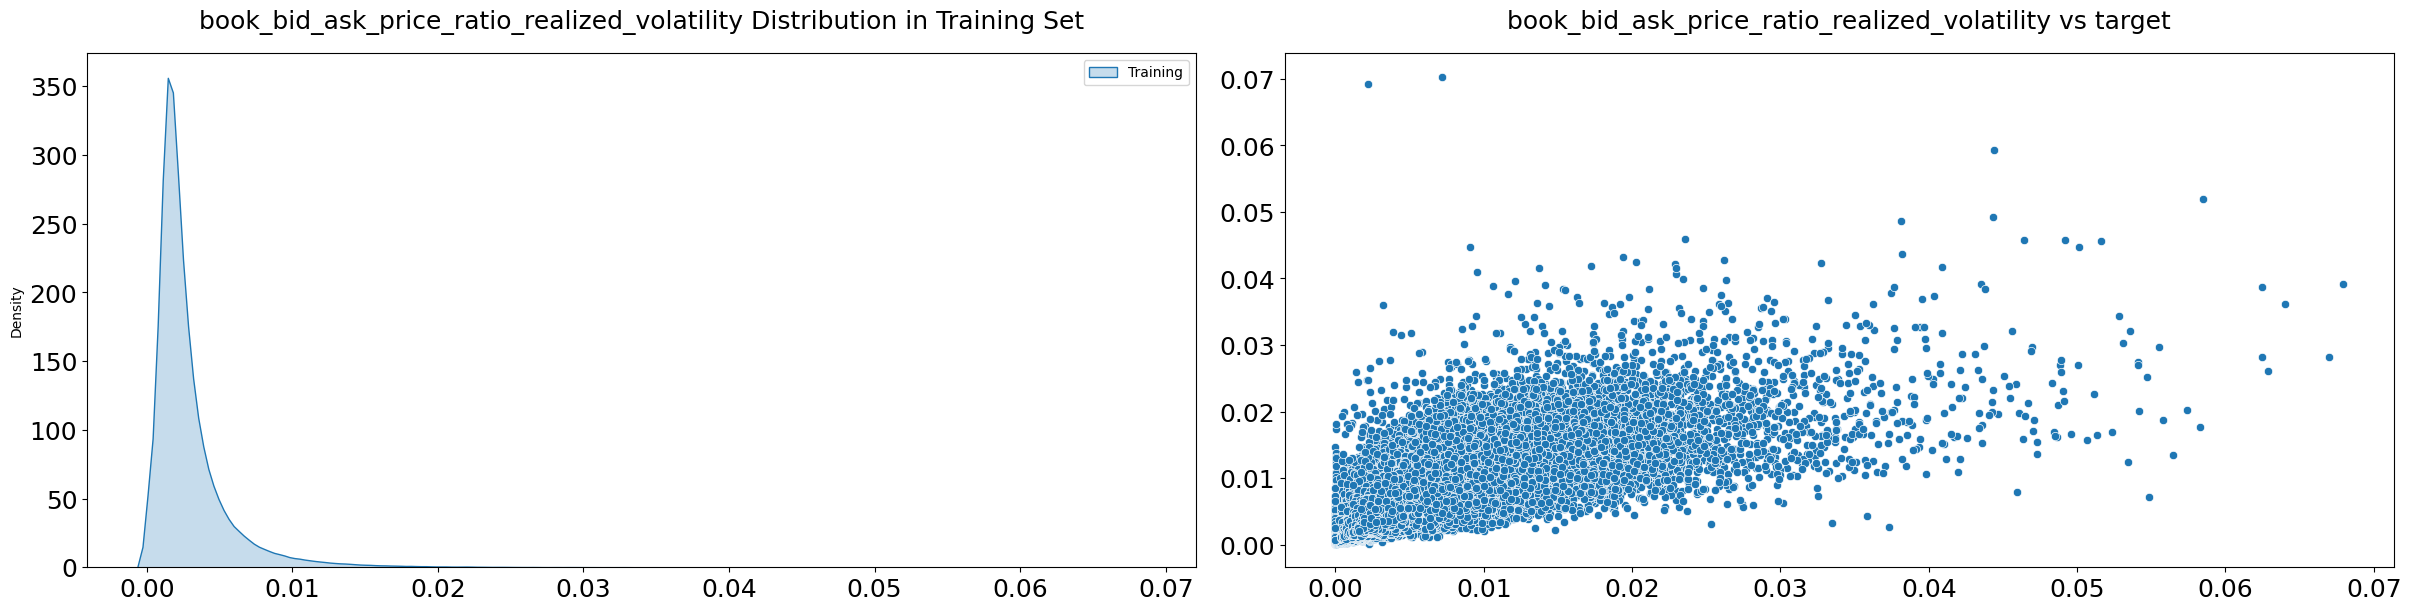

wap1_mean
---------
Training Mean: 1.0  - Training Median: 1.0 - Training Std: 0.00337
Training Min: 0.9173  - Training Max: 1.079
Training Skew: -0.2131  - Training Kurtosis: 29.89


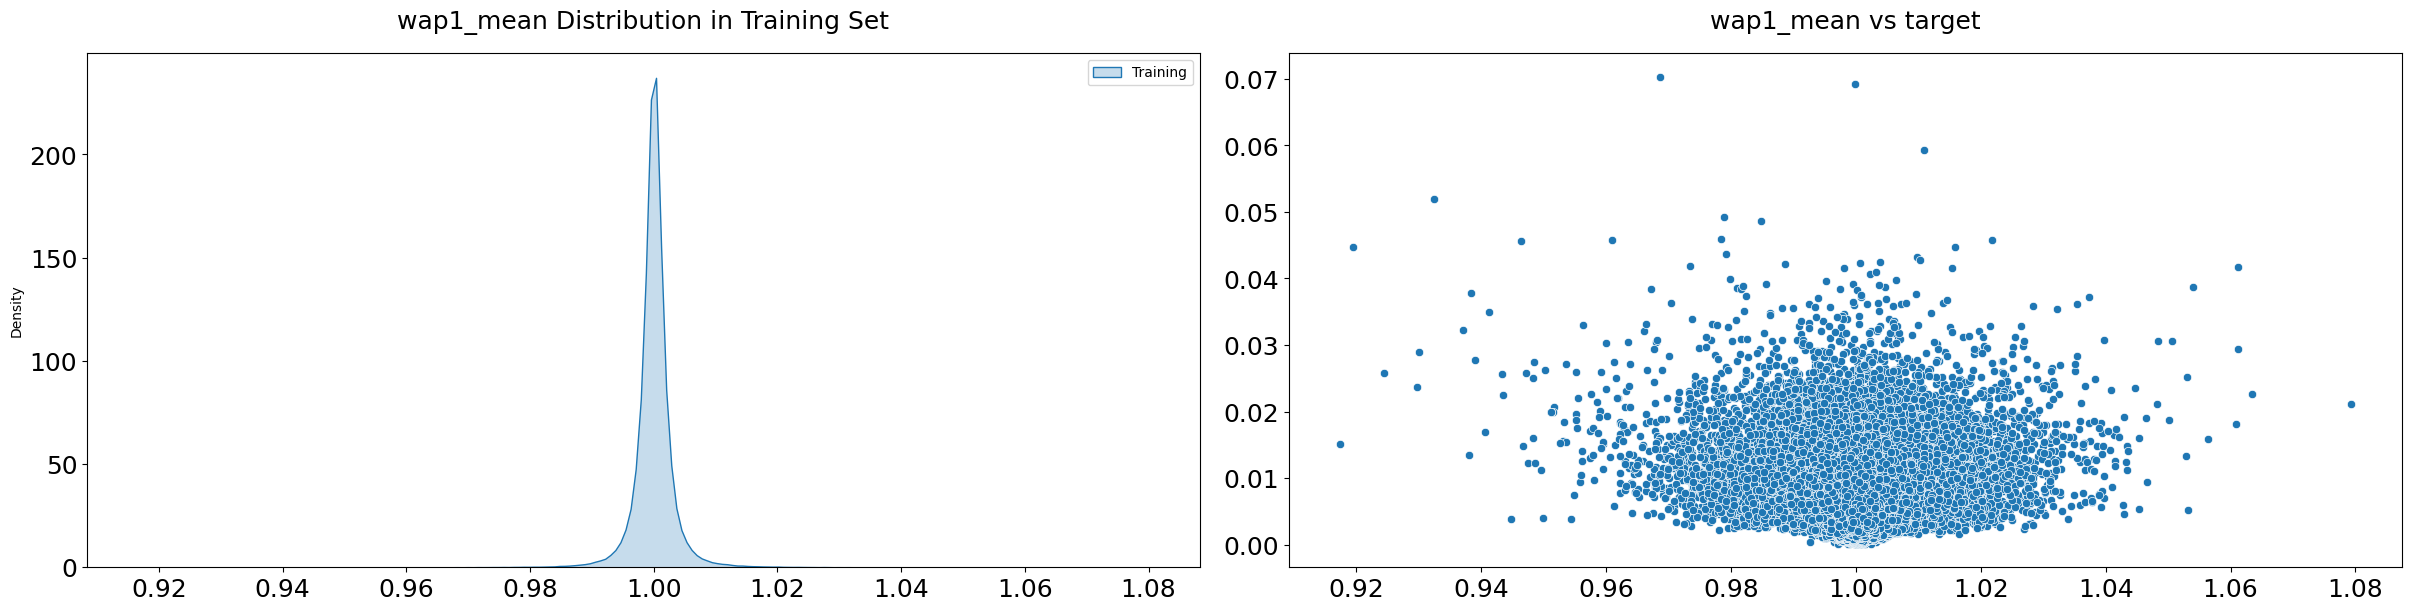

wap1_std
--------
Training Mean: 0.00111  - Training Median: 0.0008073 - Training Std: 0.001052
Training Min: 1.631e-05  - Training Max: 0.03437
Training Skew: 4.461  - Training Kurtosis: 42.59


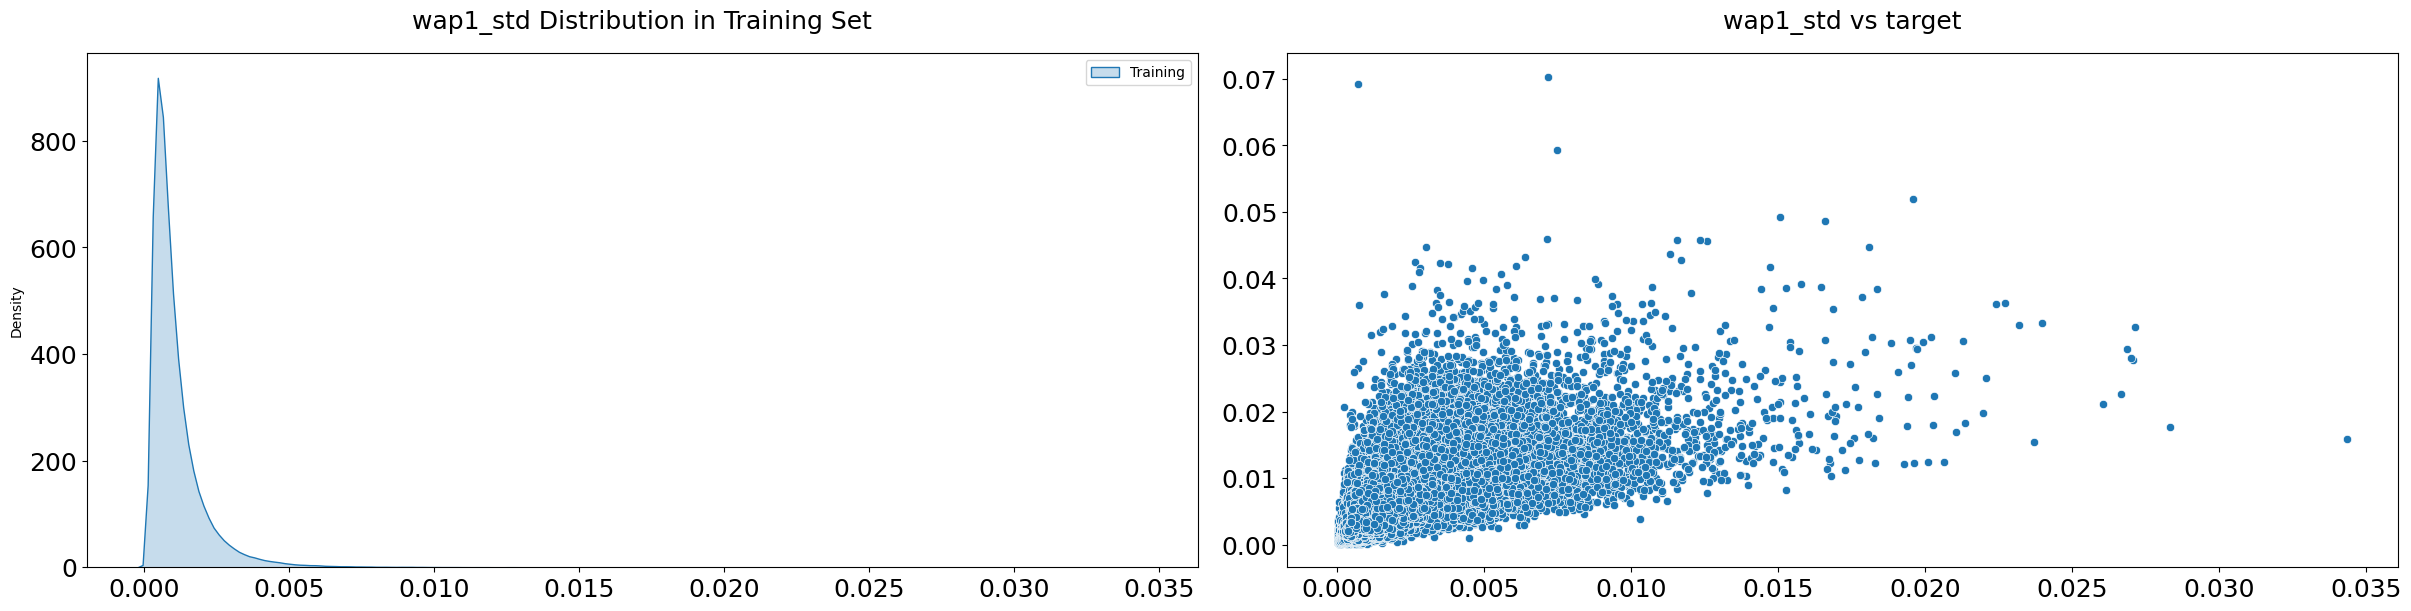

wap1_min
--------
Training Mean: 0.9977  - Training Median: 0.9985 - Training Std: 0.003891
Training Min: 0.8831  - Training Max: 1.049
Training Skew: -3.839  - Training Kurtosis: 43.12


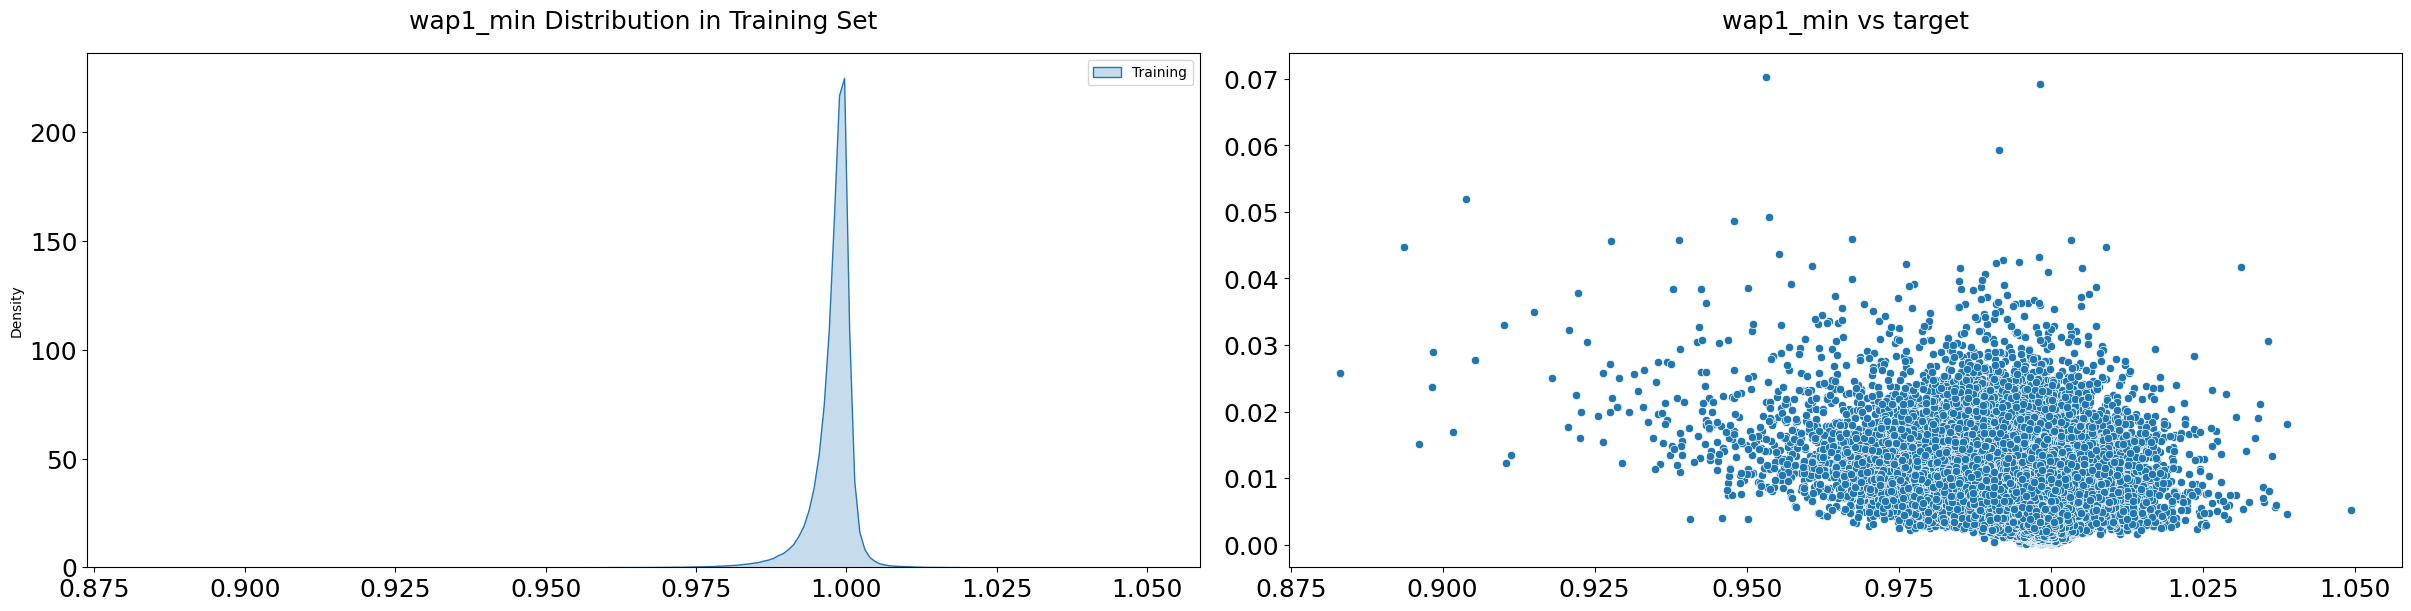

wap1_max
--------
Training Mean: 1.002  - Training Median: 1.001 - Training Std: 0.003804
Training Min: 0.9479  - Training Max: 1.127
Training Skew: 3.534  - Training Kurtosis: 37.32


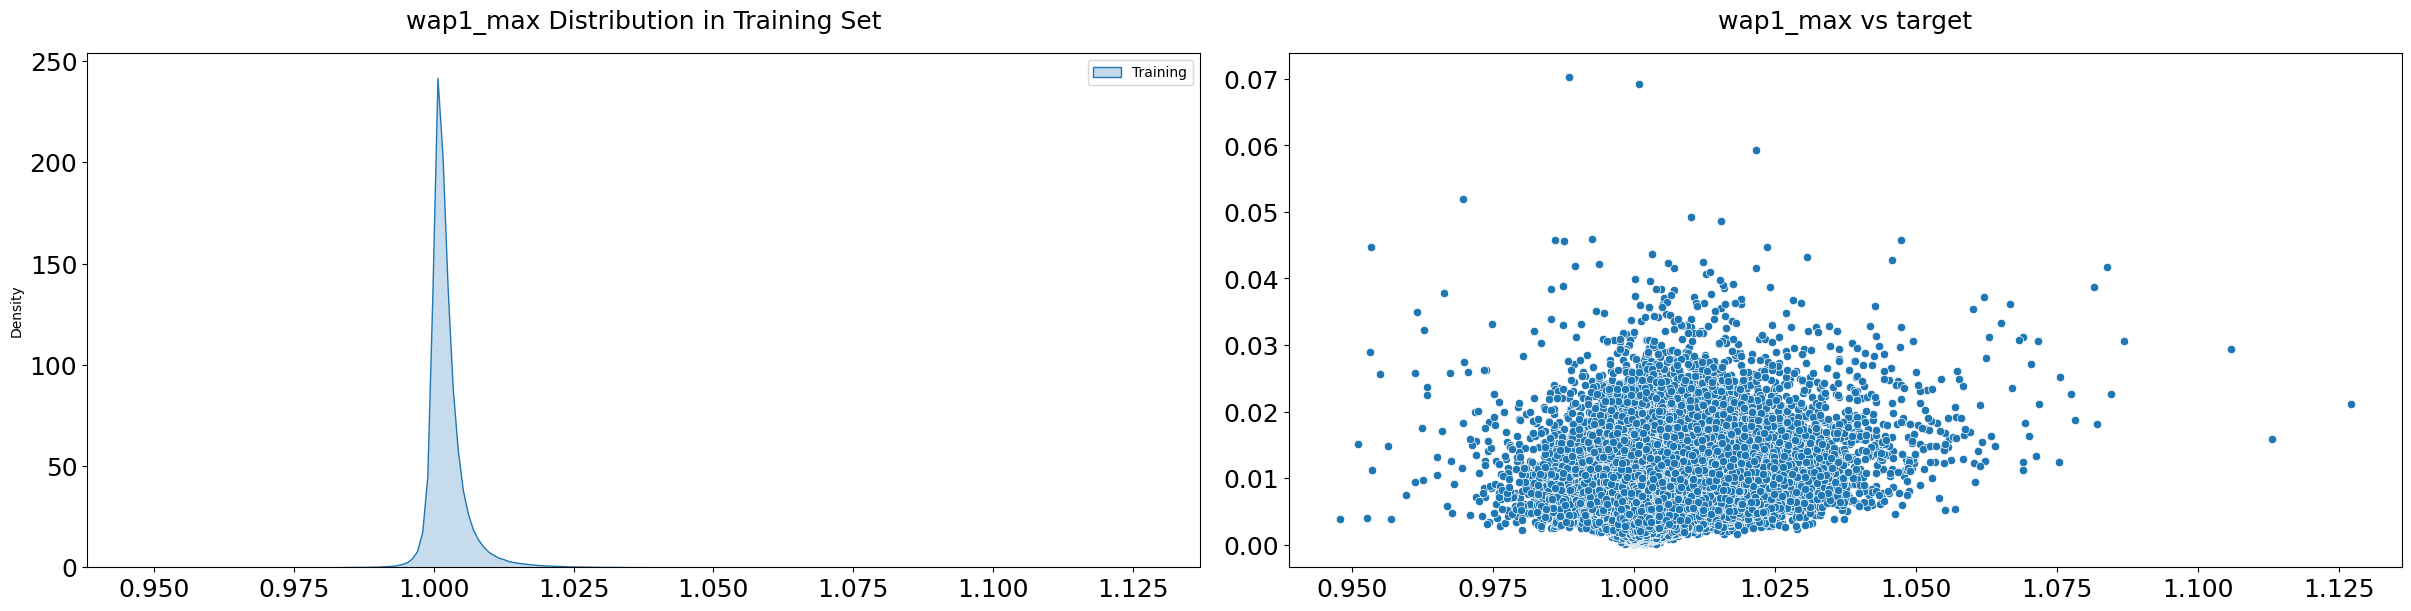

wap1_realized_volatility
------------------------
Training Mean: 0.004233  - Training Median: 0.003159 - Training Std: 0.003586
Training Min: 8.066e-05  - Training Max: 0.08642
Training Skew: 3.386  - Training Kurtosis: 22.65


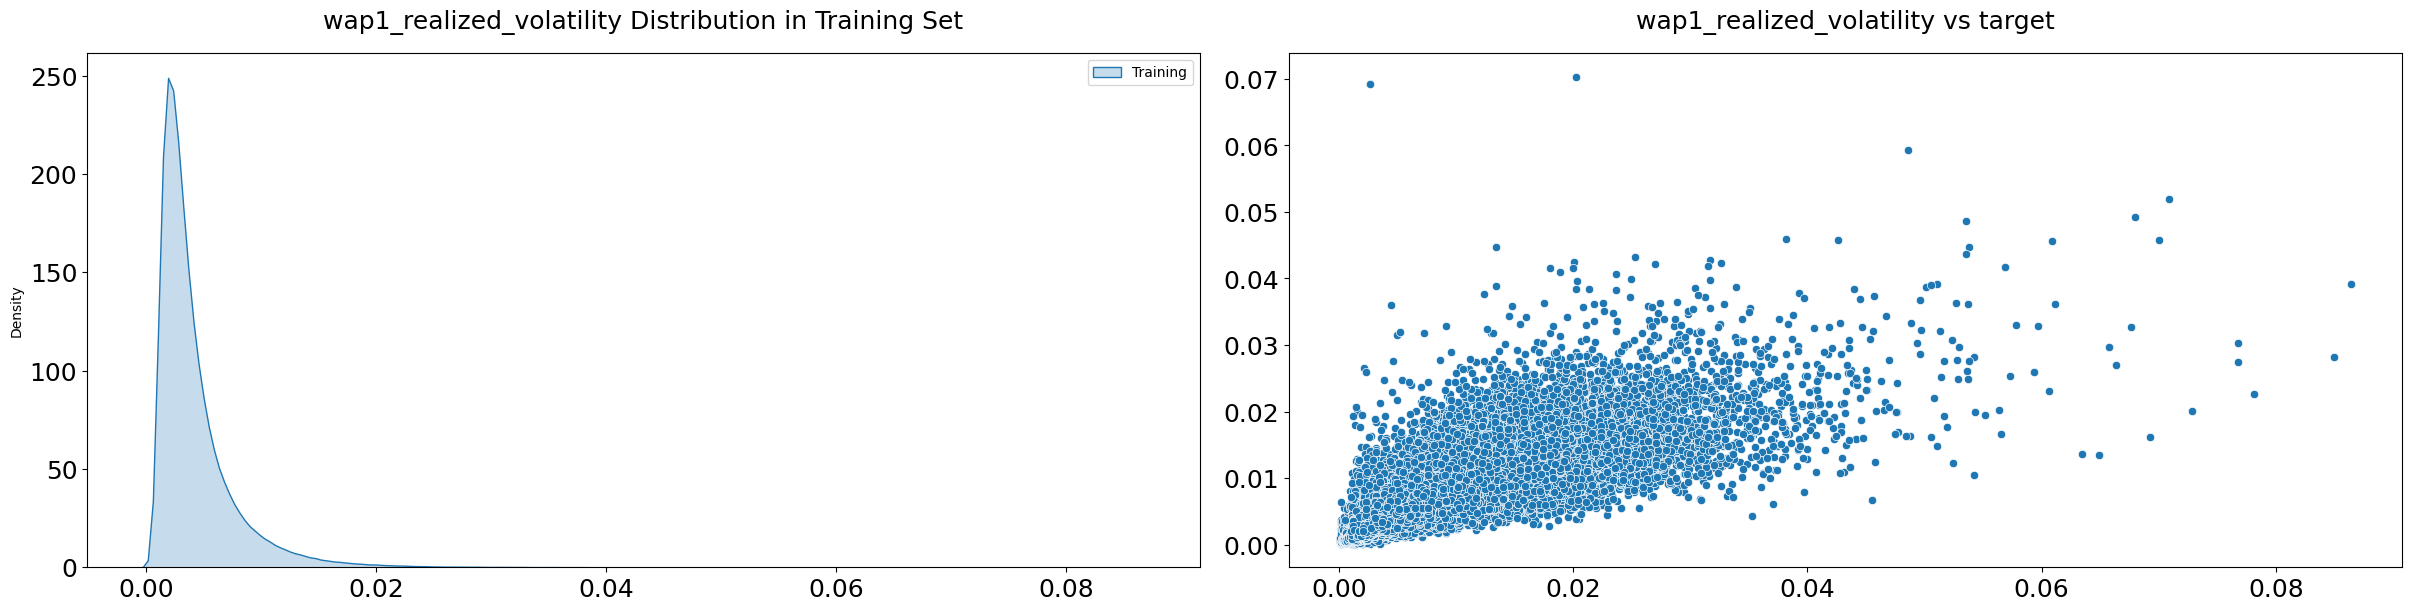

wap2_mean
---------
Training Mean: 1.0  - Training Median: 1.0 - Training Std: 0.003374
Training Min: 0.9173  - Training Max: 1.079
Training Skew: -0.2179  - Training Kurtosis: 29.88


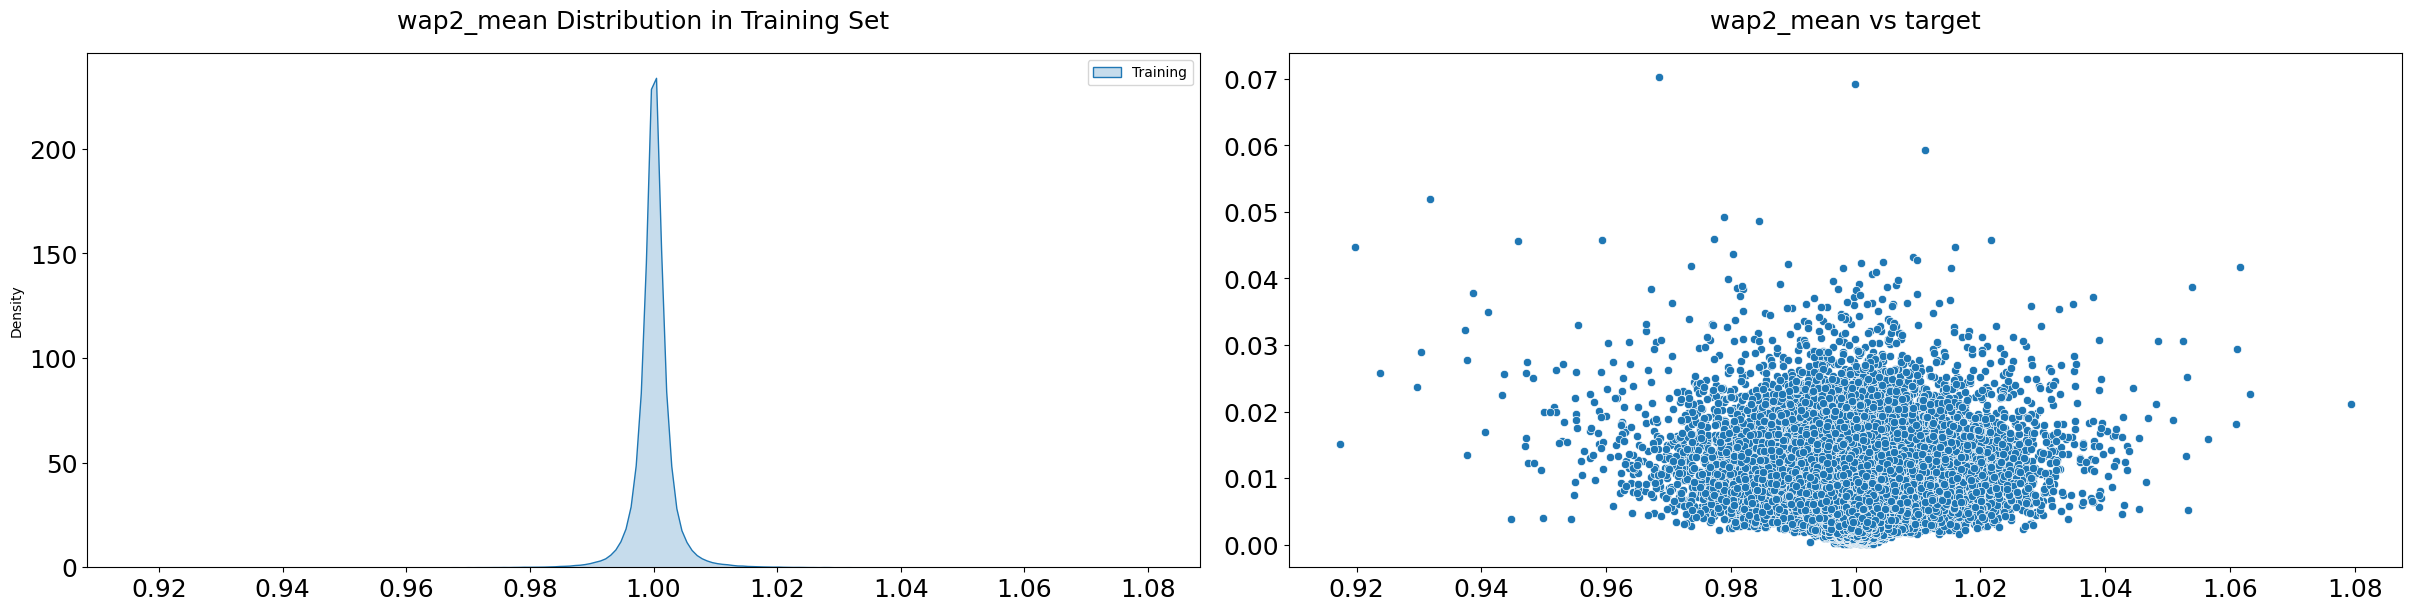

wap2_std
--------
Training Mean: 0.001149  - Training Median: 0.0008419 - Training Std: 0.001065
Training Min: 1.155e-06  - Training Max: 0.03441
Training Skew: 4.397  - Training Kurtosis: 41.1


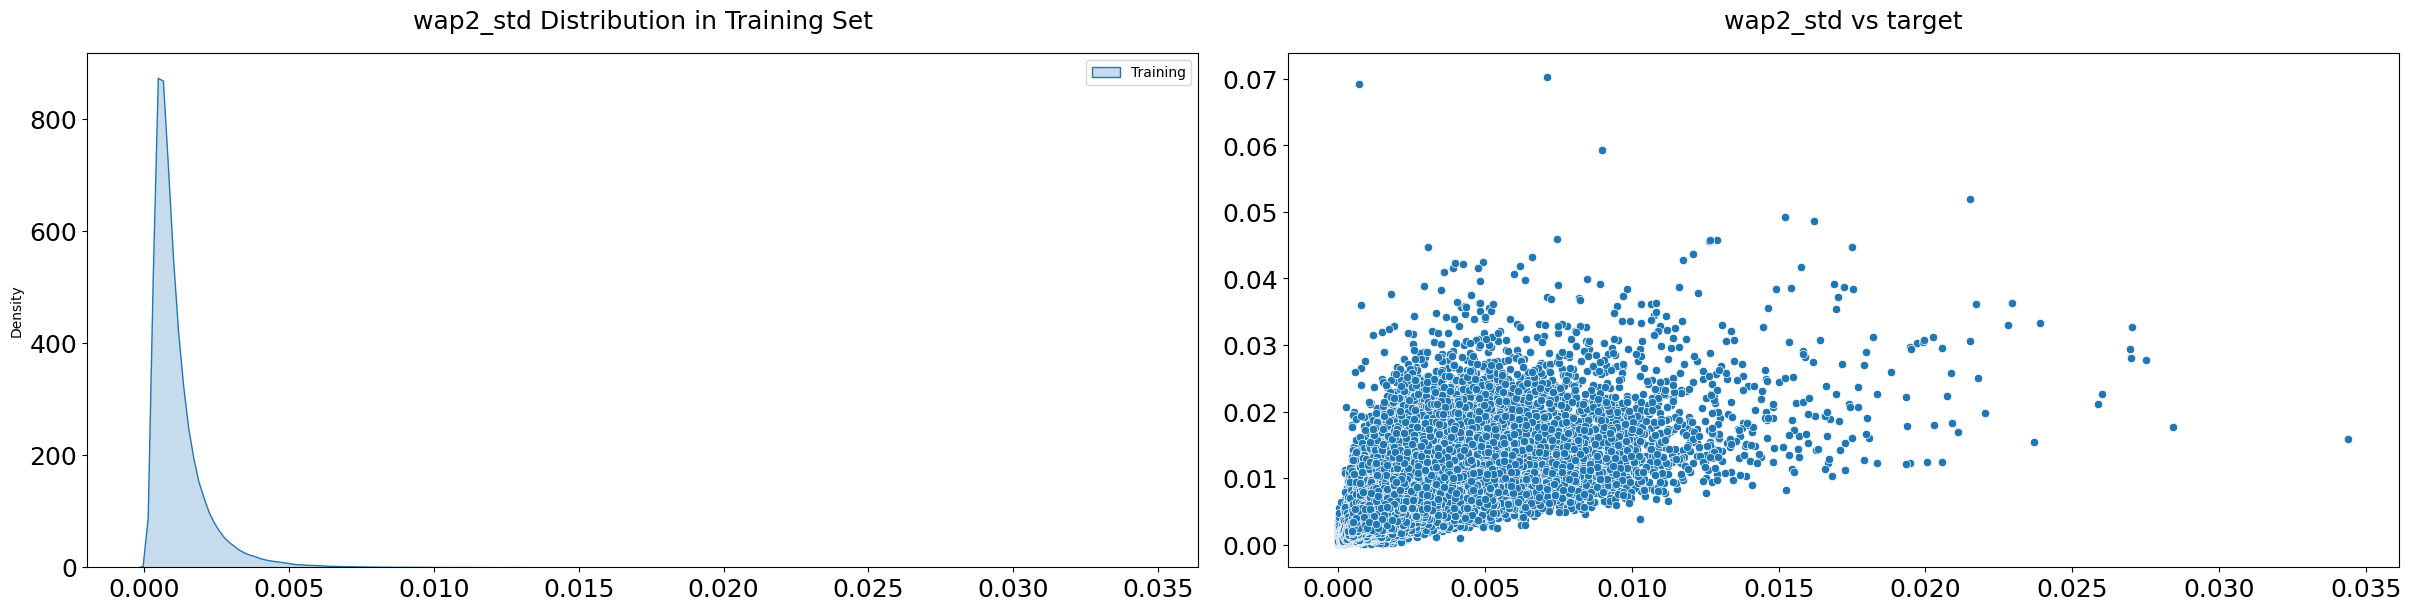

wap2_min
--------
Training Mean: 0.9976  - Training Median: 0.9984 - Training Std: 0.003933
Training Min: 0.8815  - Training Max: 1.044
Training Skew: -3.873  - Training Kurtosis: 42.63


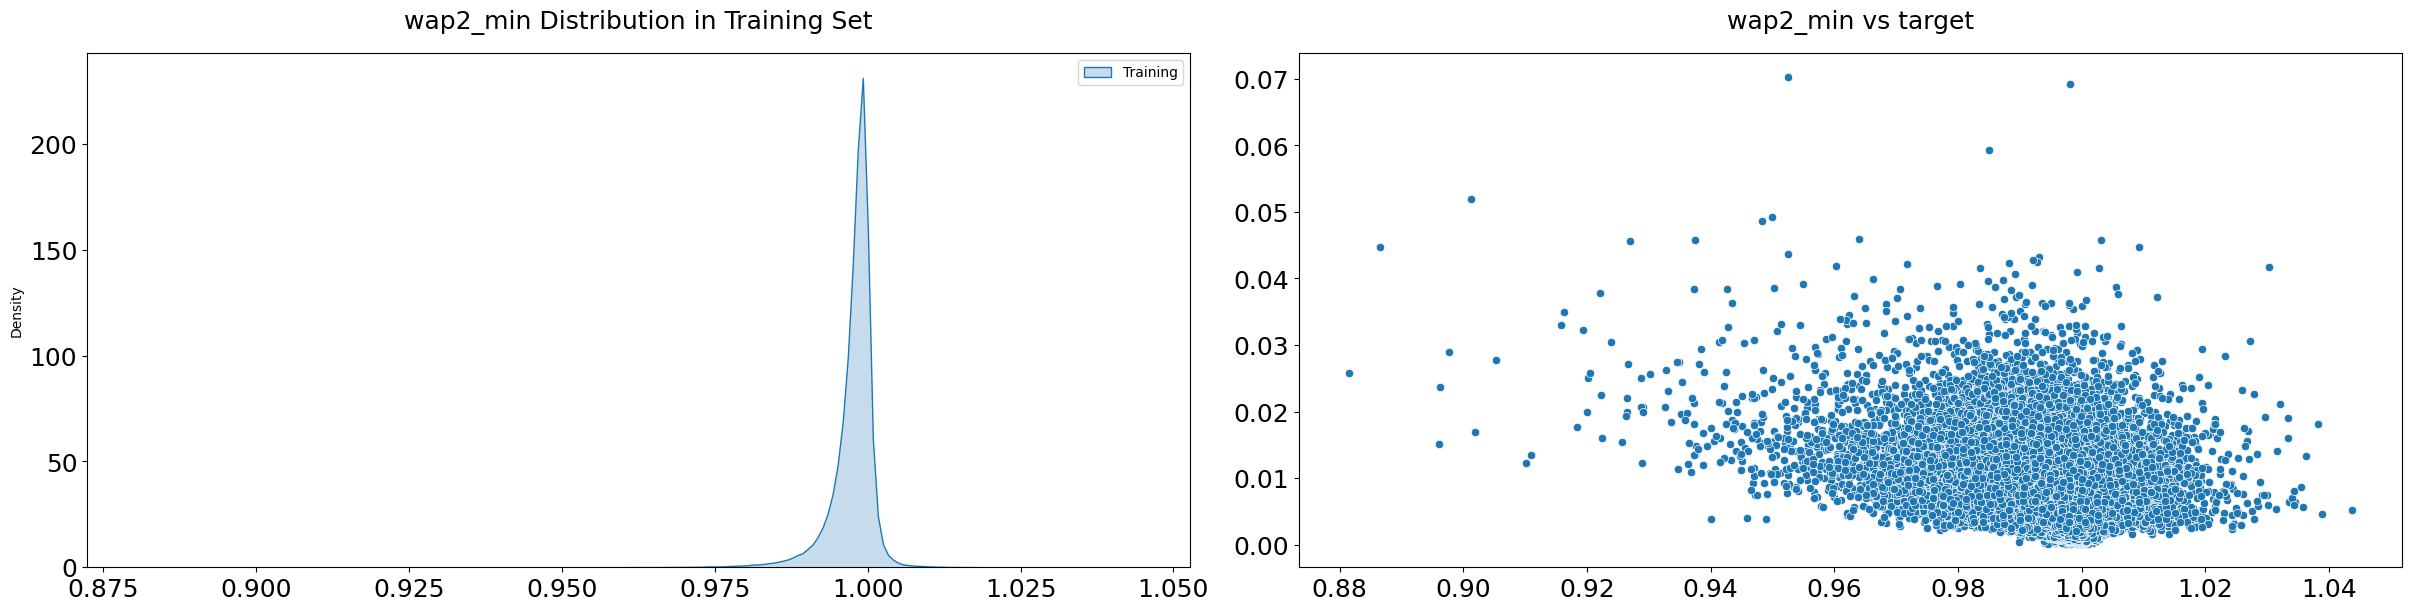

wap2_max
--------
Training Mean: 1.002  - Training Median: 1.002 - Training Std: 0.003849
Training Min: 0.9482  - Training Max: 1.126
Training Skew: 3.569  - Training Kurtosis: 36.6


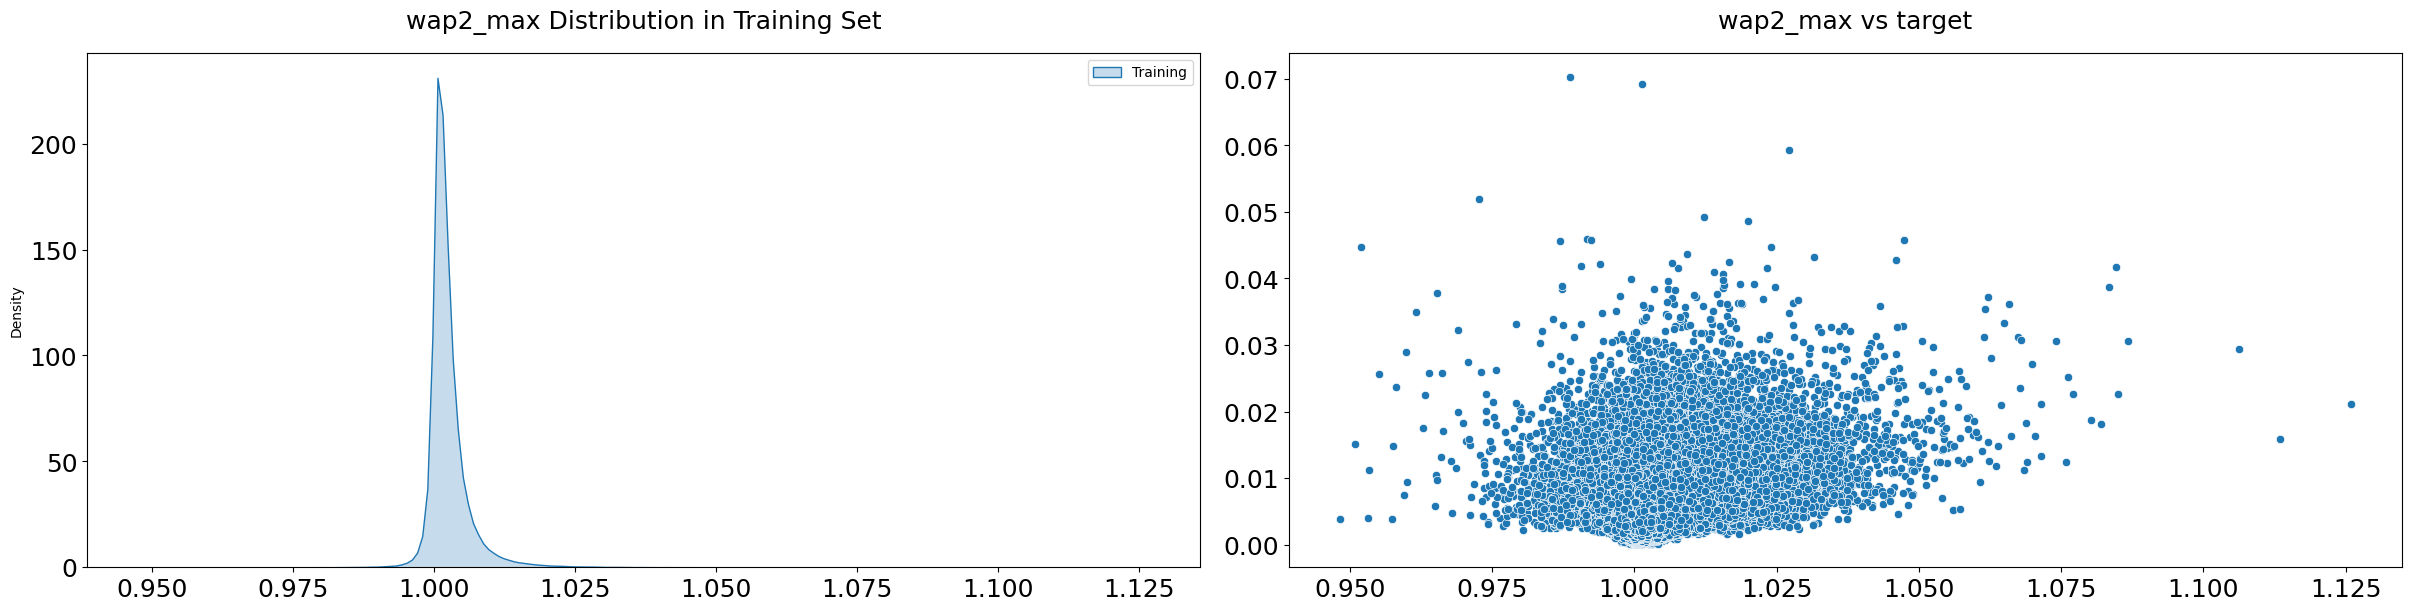

wap2_realized_volatility
------------------------
Training Mean: 0.005808  - Training Median: 0.004347 - Training Std: 0.005026
Training Min: 7.879e-06  - Training Max: 0.1359
Training Skew: 3.591  - Training Kurtosis: 25.17


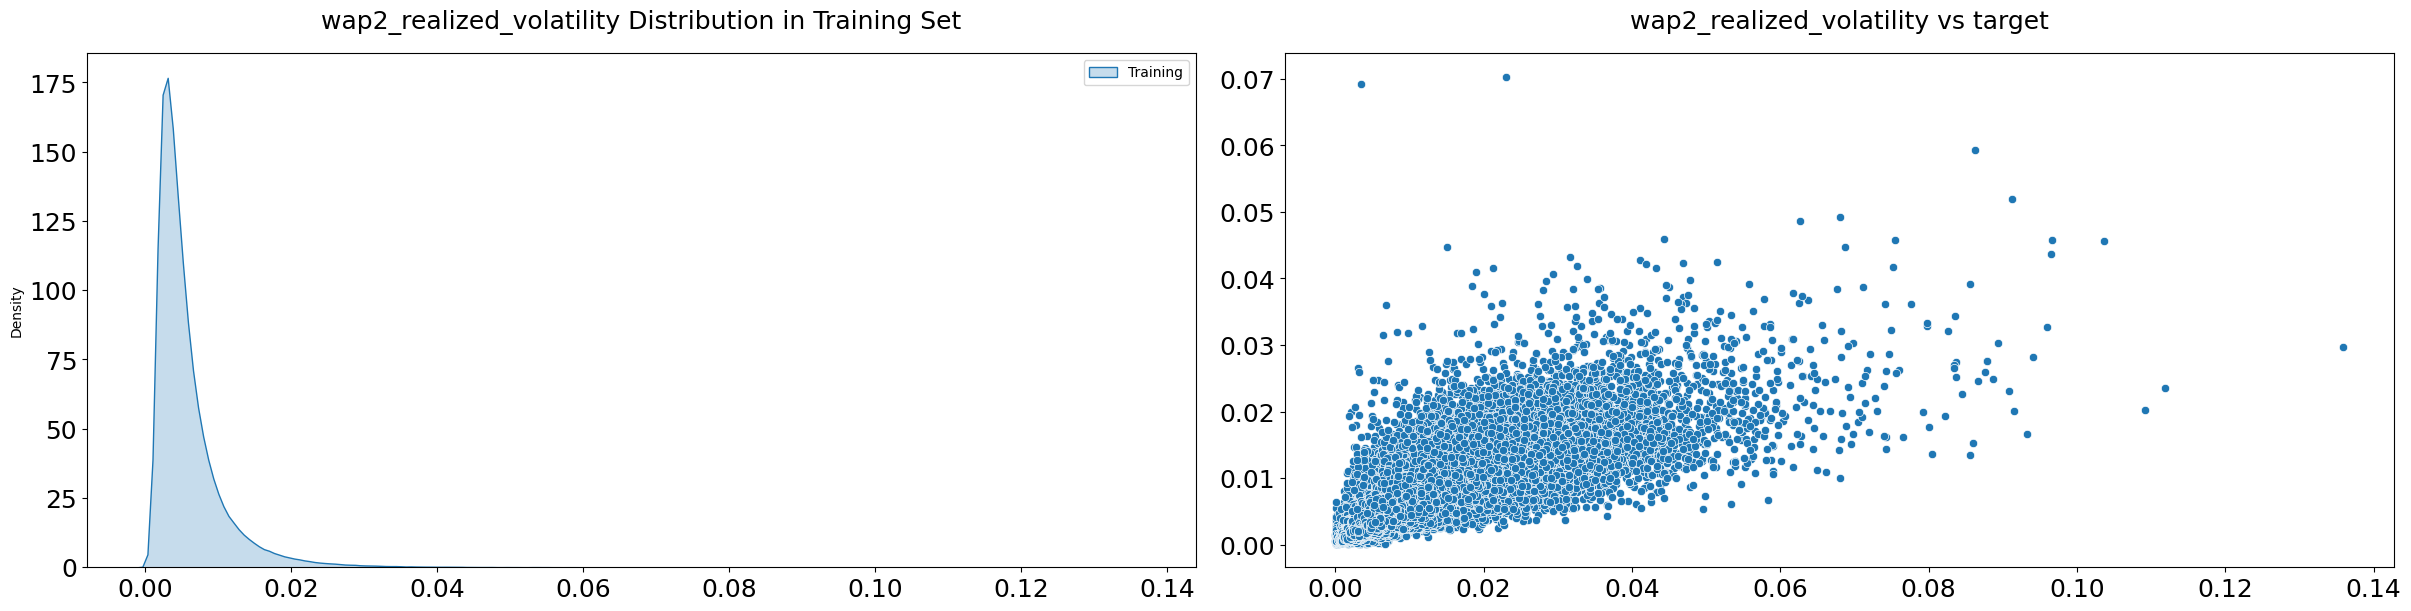

In [65]:
def visualize_continuous_feature(continuous_feature):
            
    print(f'{continuous_feature}\n{"-" * len(continuous_feature)}')

    print(f'Training Mean: {float(train[continuous_feature].mean()):.4}  - Training Median: {float(train[continuous_feature].median()):.4} - Training Std: {float(train[continuous_feature].std()):.4}')
    print(f'Training Min: {float(train[continuous_feature].min()):.4}  - Training Max: {float(train[continuous_feature].max()):.4}')
    print(f'Training Skew: {float(train[continuous_feature].skew()):.4}  - Training Kurtosis: {float(train[continuous_feature].kurtosis()):.4}')

    fig, axes = plt.subplots(ncols=2, figsize=(24, 6), dpi=100, constrained_layout=True)
    title_size = 18
    label_size = 18

    sns.kdeplot(train[continuous_feature], label='Training', fill=True, ax=axes[0])
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', labelsize=label_size)
    axes[0].tick_params(axis='y', labelsize=label_size)
    axes[0].legend()
    axes[0].set_title(f'{continuous_feature} Distribution in Training Set', size=title_size, pad=title_size)
    
    sns.scatterplot(x=train[continuous_feature], y=train['target'], ax=axes[1])
    axes[1].set_title(f'{continuous_feature} vs target', size=title_size, pad=title_size)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    axes[1].tick_params(axis='x', labelsize=label_size)
    axes[1].tick_params(axis='y', labelsize=label_size)
    
    plt.show()
    
    
for continuous_feature in train.columns[6:]:
    visualize_continuous_feature(continuous_feature)


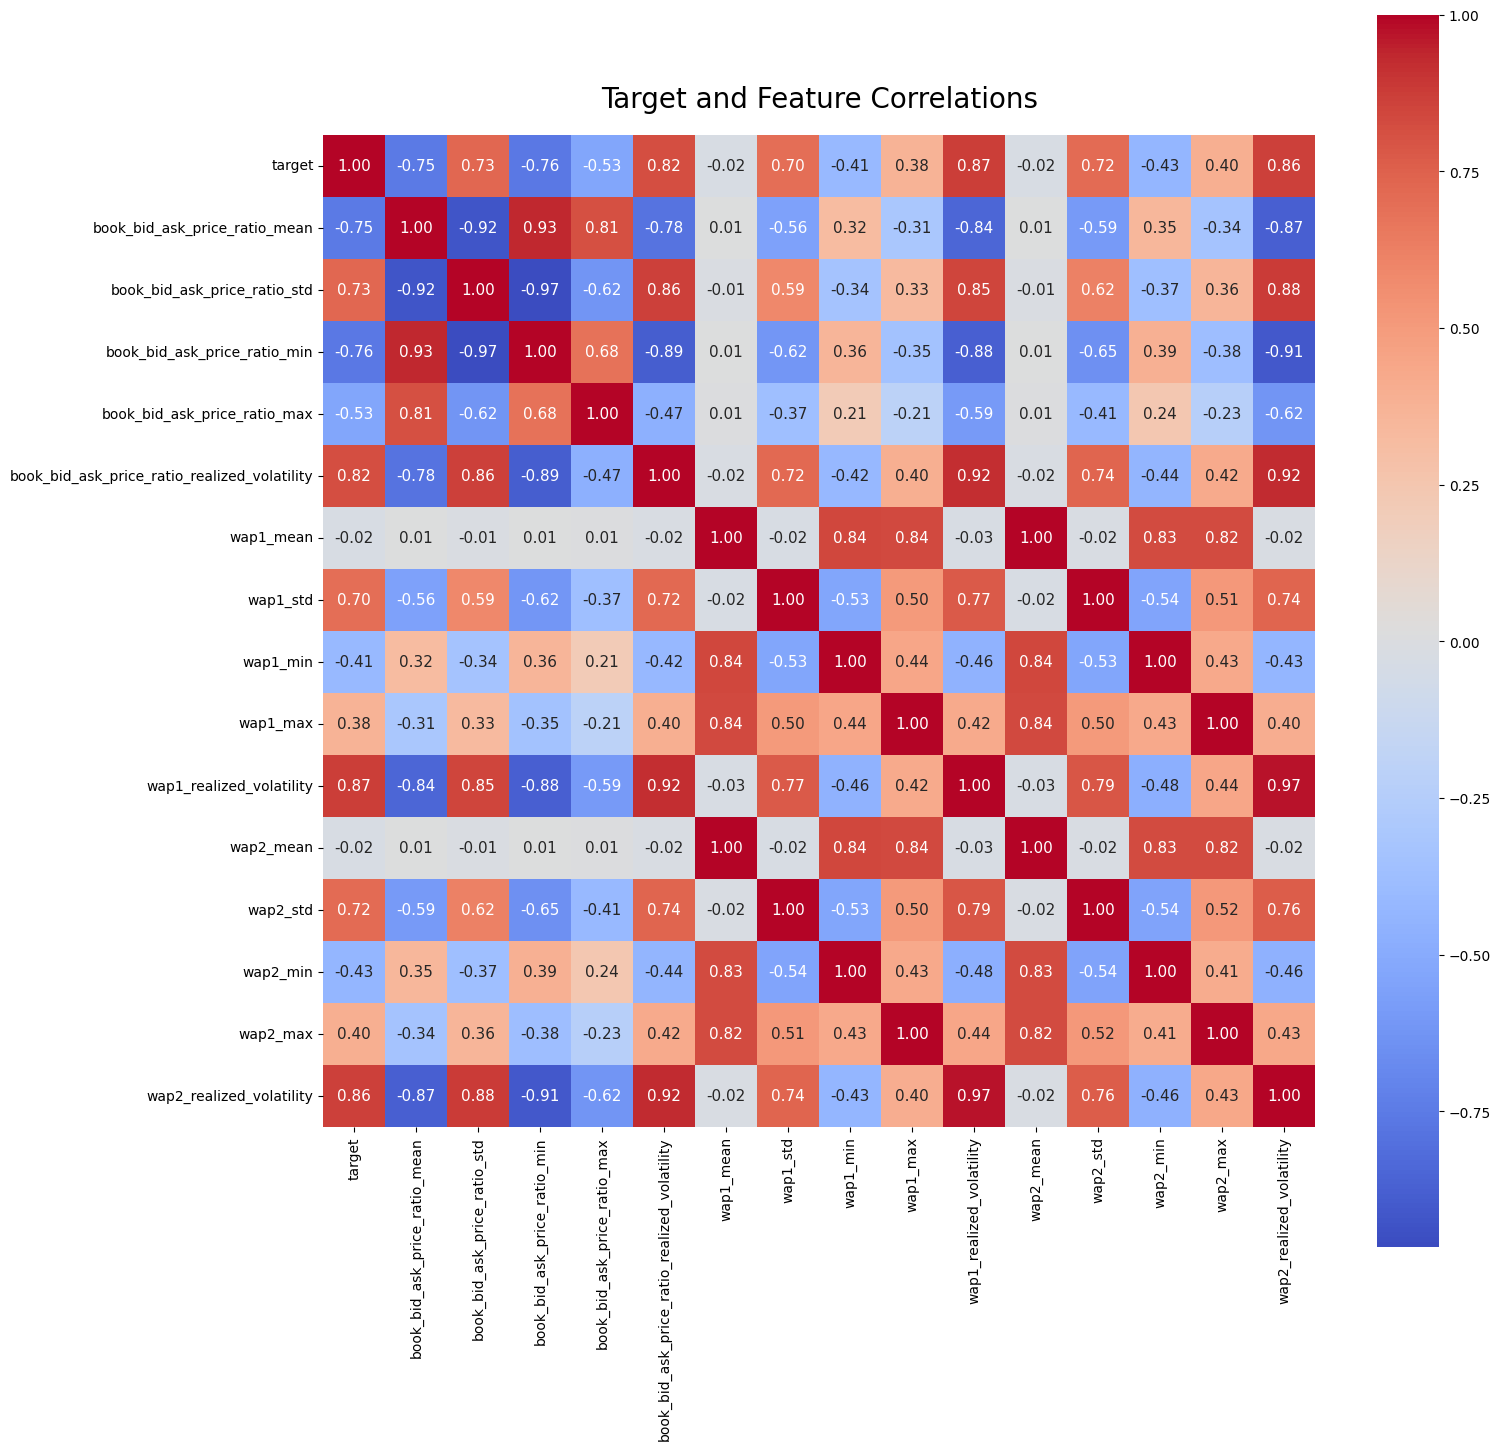

In [66]:
fig = plt.figure(figsize=(16, 16), dpi=100)
sns.heatmap(
    train[['target'] + train.columns[6:].tolist()].corr(),
    annot=True,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 11},
    fmt='.2f'
)
plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.tick_params(axis='y', labelsize=10, rotation=0)
plt.title('Target and Feature Correlations', size=20, pad=20)
plt.show()

From the correlation map, we can see the most correlated features with target are wap1_realized_volatility, wap2_reallized_volatility and Book_bid_ask_price_ratio_realized_volatility.

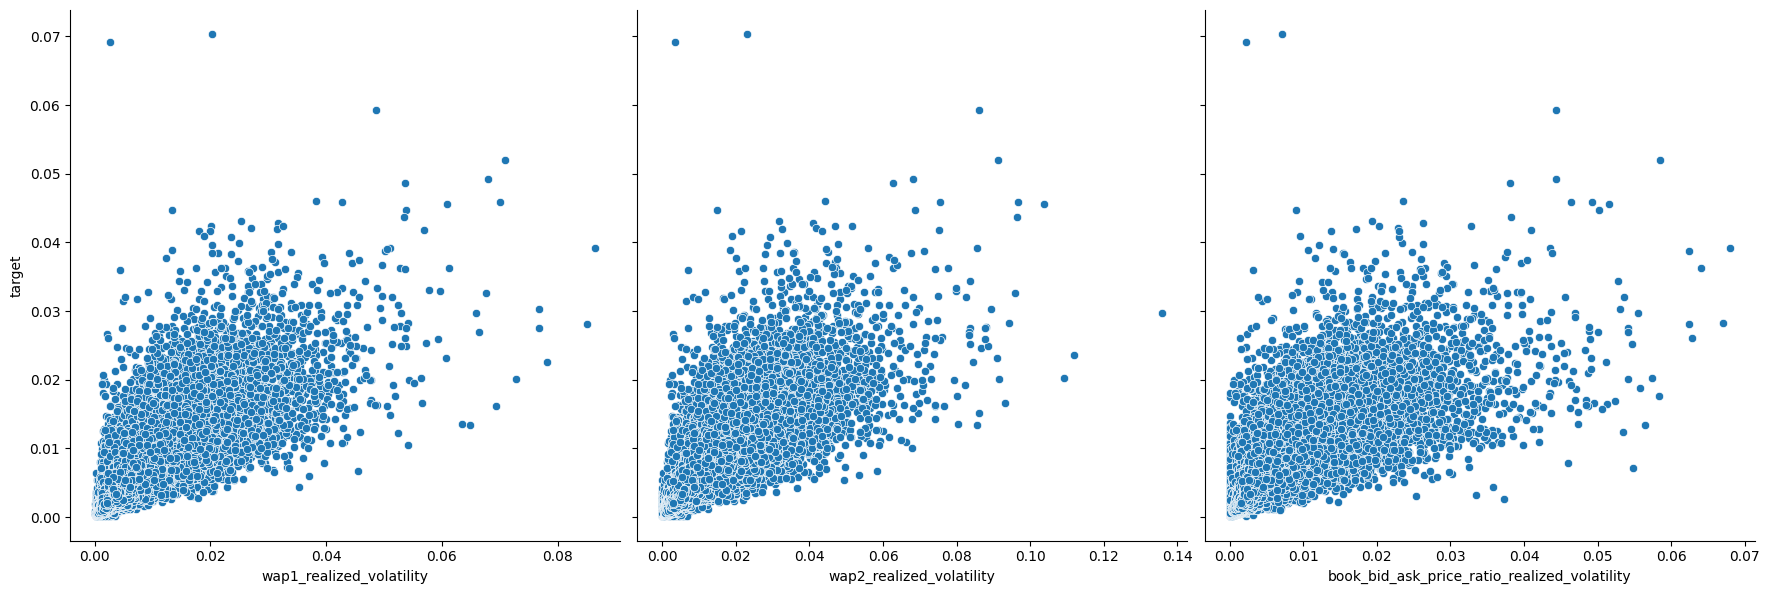

In [67]:
sns.pairplot(data = train,
                x_vars = ['wap1_realized_volatility', 'wap2_realized_volatility', 'book_bid_ask_price_ratio_realized_volatility'],
                y_vars = ['target'],
                height = 6)

plt.show()

### Linear regression with selected three features

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

realized_volatility_price_rmspe = root_mean_squared_percentage_error(train['target'], train['realized_volatility_from_price'])
print(f'Realized Volatility from price RMPSE: {realized_volatility_price_rmspe:.6}')

Realized Volatility from price RMPSE: 0.380267


In [69]:
def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

potential_features = ['wap1_realized_volatility', 'wap2_realized_volatility', 'book_bid_ask_price_ratio_realized_volatility']
all_models = ['baseline']
all_models.extend(powerset(potential_features))
all_models

['baseline',
 ['wap1_realized_volatility'],
 ['wap2_realized_volatility'],
 ['wap1_realized_volatility', 'wap2_realized_volatility'],
 ['book_bid_ask_price_ratio_realized_volatility'],
 ['wap1_realized_volatility', 'book_bid_ask_price_ratio_realized_volatility'],
 ['wap2_realized_volatility', 'book_bid_ask_price_ratio_realized_volatility'],
 ['wap1_realized_volatility',
  'wap2_realized_volatility',
  'book_bid_ask_price_ratio_realized_volatility']]

In [70]:
rmspes = np.zeros((len(all_models), 5))

kfold = KFold(5,
             random_state = 614,
             shuffle=True)

j = 0
for train_index, test_index in kfold.split(train):
    vo_tt = train.iloc[train_index]
    vo_ho = train.iloc[test_index]
    
    i = 0
    for model in all_models:
        if model == "baseline":
            rmspes[i, j] = root_mean_squared_percentage_error(vo_ho['target'], vo_ho['realized_volatility_from_price'])
        else:
            if len(model) == 1:
                reg = LinearRegression(copy_X = True)
                
                reg.fit(vo_tt[model].values.reshape(-1,1),
                           vo_tt.target)
                
                pred = reg.predict(vo_ho[model].values.reshape(-1,1))
                
                rmspes[i,j] = root_mean_squared_percentage_error(vo_ho.target, pred)
            else:
                reg = LinearRegression(copy_X = True)
                
                reg.fit(vo_tt[model].values,
                           vo_tt.target)
                
                pred = reg.predict(vo_ho[model].values)
                
                rmspes[i,j] =  root_mean_squared_percentage_error(vo_ho.target, pred)
        i = i + 1
    j = j + 1

In [71]:
rmspes

array([[0.37526414, 0.38423503, 0.37711012, 0.37980913, 0.38482059],
       [0.34851736, 0.35792237, 0.34584428, 0.35383327, 0.3653241 ],
       [0.37255988, 0.38270996, 0.37470463, 0.38499629, 0.40829649],
       [0.34426262, 0.35445021, 0.34332135, 0.35221069, 0.36688435],
       [0.48981364, 0.49184387, 0.48621592, 0.49115005, 0.50175537],
       [0.34948748, 0.35803828, 0.34655181, 0.35437444, 0.36586573],
       [0.37248537, 0.38084428, 0.37343921, 0.38254815, 0.40379774],
       [0.34470516, 0.35452226, 0.34354405, 0.3523063 , 0.36686713]])

In [72]:
np.min(np.mean(rmspes, axis=1))

0.3522258426889009

### KNN predition

In [73]:
from sklearn.neighbors import KNeighborsRegressor

In [74]:
ks = [5, 10, 15, 20, 25, 30, 45, 50]

knn_rmspes = np.zeros((len(ks), 5))

j = 0
for train_index, test_index in kfold.split(train):
    vo_tt = train.iloc[train_index]
    vo_ho = train.iloc[test_index]
    
    for i,k in enumerate(ks):
        knn = KNeighborsRegressor(k)
        
        knn.fit(vo_tt[['wap1_realized_volatility', 'wap2_realized_volatility', 'book_bid_ask_price_ratio_realized_volatility']],
                   vo_tt.target)
        
        pred = knn.predict(vo_ho[['wap1_realized_volatility', 'wap2_realized_volatility', 'book_bid_ask_price_ratio_realized_volatility']])
        
        knn_rmspes[i,j] = root_mean_squared_percentage_error(vo_ho.target, pred)
    j = j + 1

In [75]:
ks[np.argmin(np.mean(np.sqrt(knn_rmspes), axis=1))]


50

In [76]:
np.mean(knn_rmspes, axis=1)[0]

0.3332808543531581

### Use XGBoost


In [87]:
import xgboost
from sklearn.model_selection import GridSearchCV

In [85]:
train.columns


Index(['stock_id', 'time_id', 'target', 'realized_volatility_from_wap1',
       'realized_volatility_from_wap2', 'realized_volatility_from_price',
       'book_bid_ask_price_ratio_mean', 'book_bid_ask_price_ratio_std',
       'book_bid_ask_price_ratio_min', 'book_bid_ask_price_ratio_max',
       'book_bid_ask_price_ratio_realized_volatility', 'wap1_mean', 'wap1_std',
       'wap1_min', 'wap1_max', 'wap1_realized_volatility', 'wap2_mean',
       'wap2_std', 'wap2_min', 'wap2_max', 'wap2_realized_volatility'],
      dtype='object')

In [88]:
xgb_reg = xgboost.XGBRegressor()
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": np.arange(0,100,10),
              "learning_rate": [0.01, 0.1, 1]}
features = ['stock_id', 'time_id', 'target', 'realized_volatility_from_wap1',
       'realized_volatility_from_wap2', 'realized_volatility_from_price',
       'book_bid_ask_price_ratio_mean', 'book_bid_ask_price_ratio_std',
       'book_bid_ask_price_ratio_min', 'book_bid_ask_price_ratio_max',
       'book_bid_ask_price_ratio_realized_volatility', 'wap1_mean', 'wap1_std',
       'wap1_min', 'wap1_max', 'wap1_realized_volatility', 'wap2_mean',
       'wap2_std', 'wap2_min', 'wap2_max', 'wap2_realized_volatility']
search = GridSearchCV(xgb_reg, param_grid, cv=5).fit(train[features], train['target'])
print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


In [89]:
### Create an XGBRegressor object
### learning_rate=0.1, max_depth=4, n_estimators=50
xgb_reg = xgboost.XGBRegressor(learning_rate=0.1,
                                   max_depth=4,
                                   n_estimators=50)

## fit it
xgb_reg.fit(train[features], train['target'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [90]:
root_mean_squared_percentage_error(train['target'], xgb_reg.predict(train[features]))

0.028043865670235948

## Stocks cluster

In [78]:
stock_features = [] 

for realized_volatility in ['target', 'realized_volatility_from_wap1', 'realized_volatility_from_wap2', 'realized_volatility_from_price']:
    for agg in ['mean', 'std', 'min', 'max']:
        train[f'stock_{realized_volatility}_{agg}'] = train.groupby('stock_id')[realized_volatility].transform(agg)
        stock_features.append(f'stock_{realized_volatility}_{agg}')
        
df_stocks = train.groupby('stock_id')[stock_features].first().reset_index()
train.drop(columns=stock_features, inplace=True)


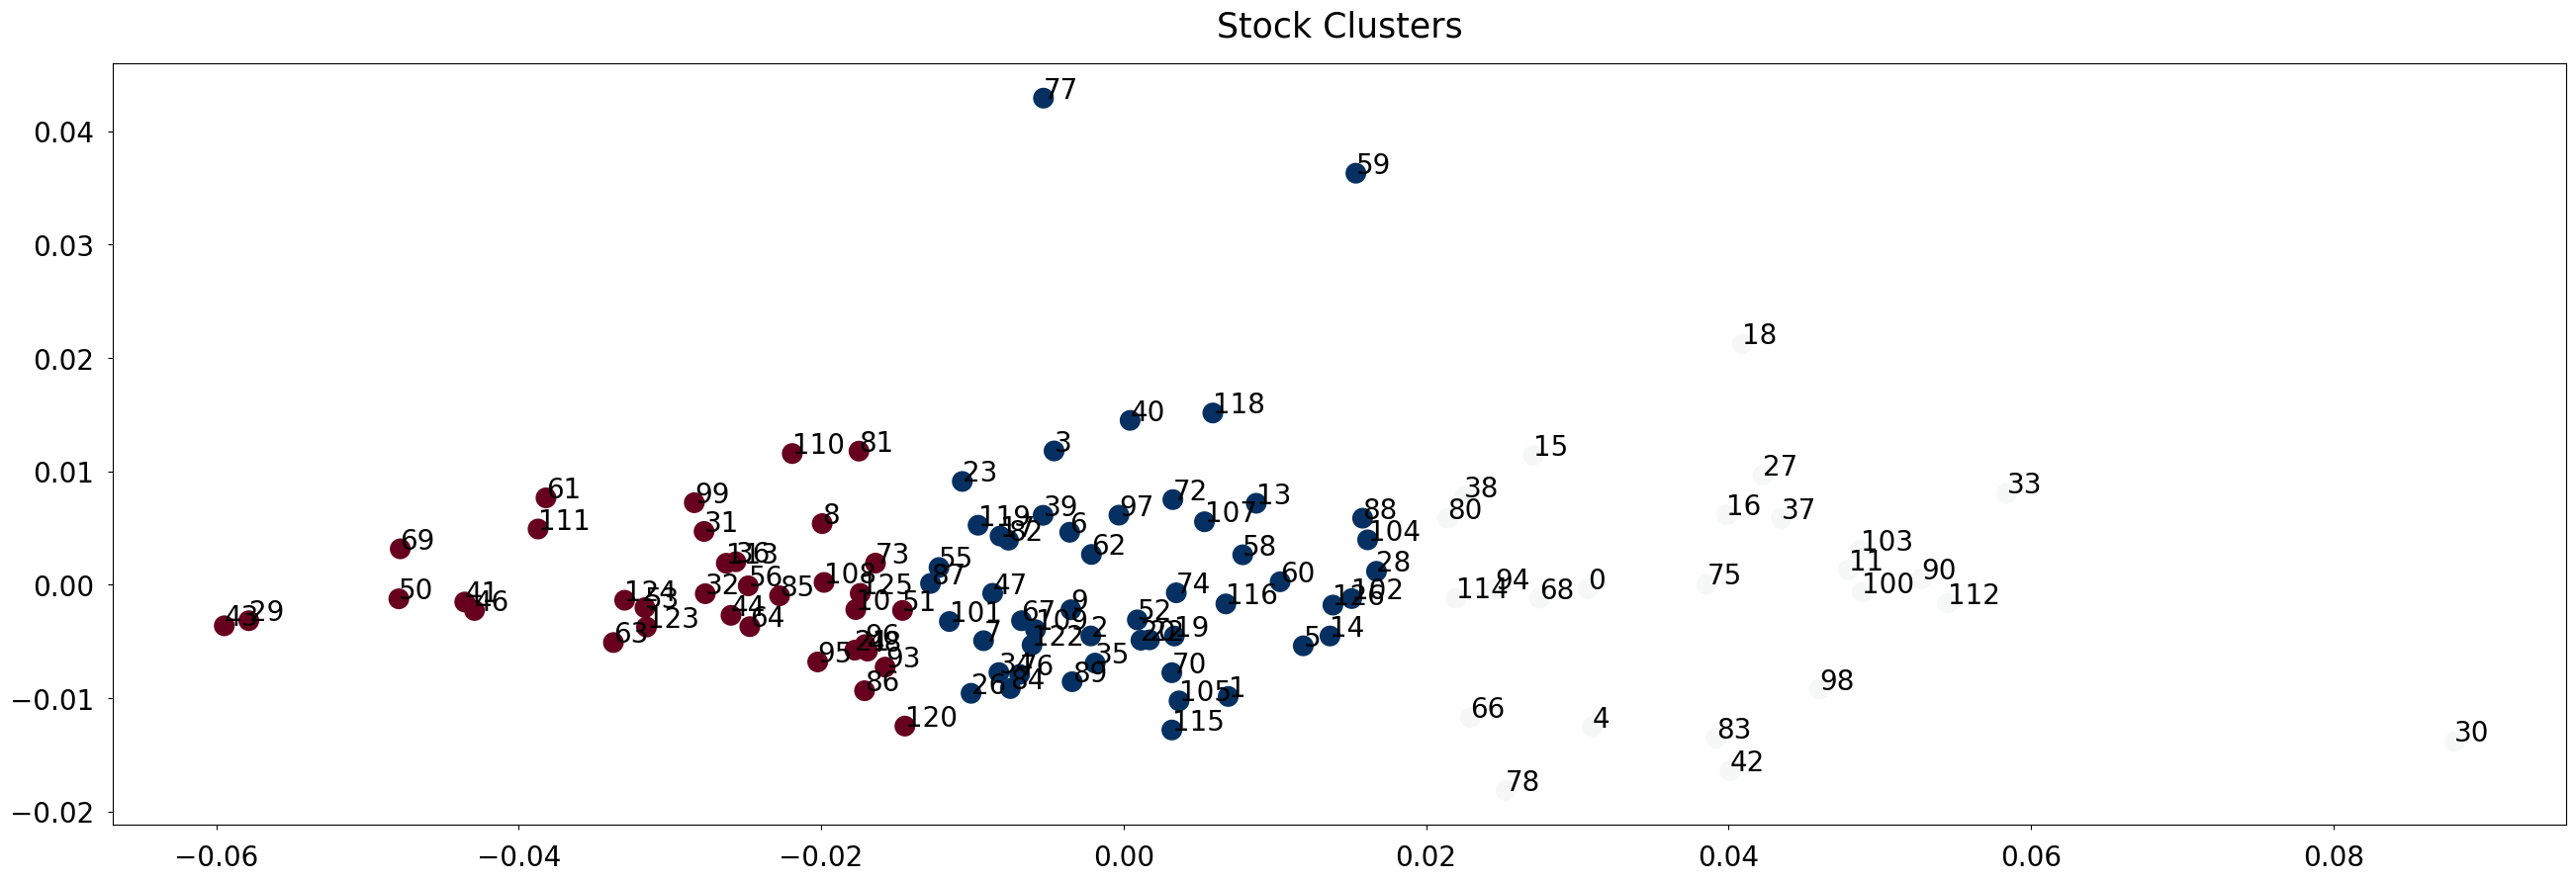

In [79]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_stocks[stock_features])

pca = PCA(n_components=2)
stocks_2d = pca.fit_transform(df_stocks[stock_features])

fig, ax = plt.subplots(figsize=(32, 10))
ax.scatter(stocks_2d[:, 0], stocks_2d[:, 1], s=200, c=kmeans.labels_, cmap='RdBu')
for idx, stock_id in enumerate(df_stocks['stock_id'].values):
    ax.annotate(stock_id, (stocks_2d[idx, 0], stocks_2d[idx, 1]), fontsize=20)
    
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Stock Clusters', size=25, pad=20)

plt.show()

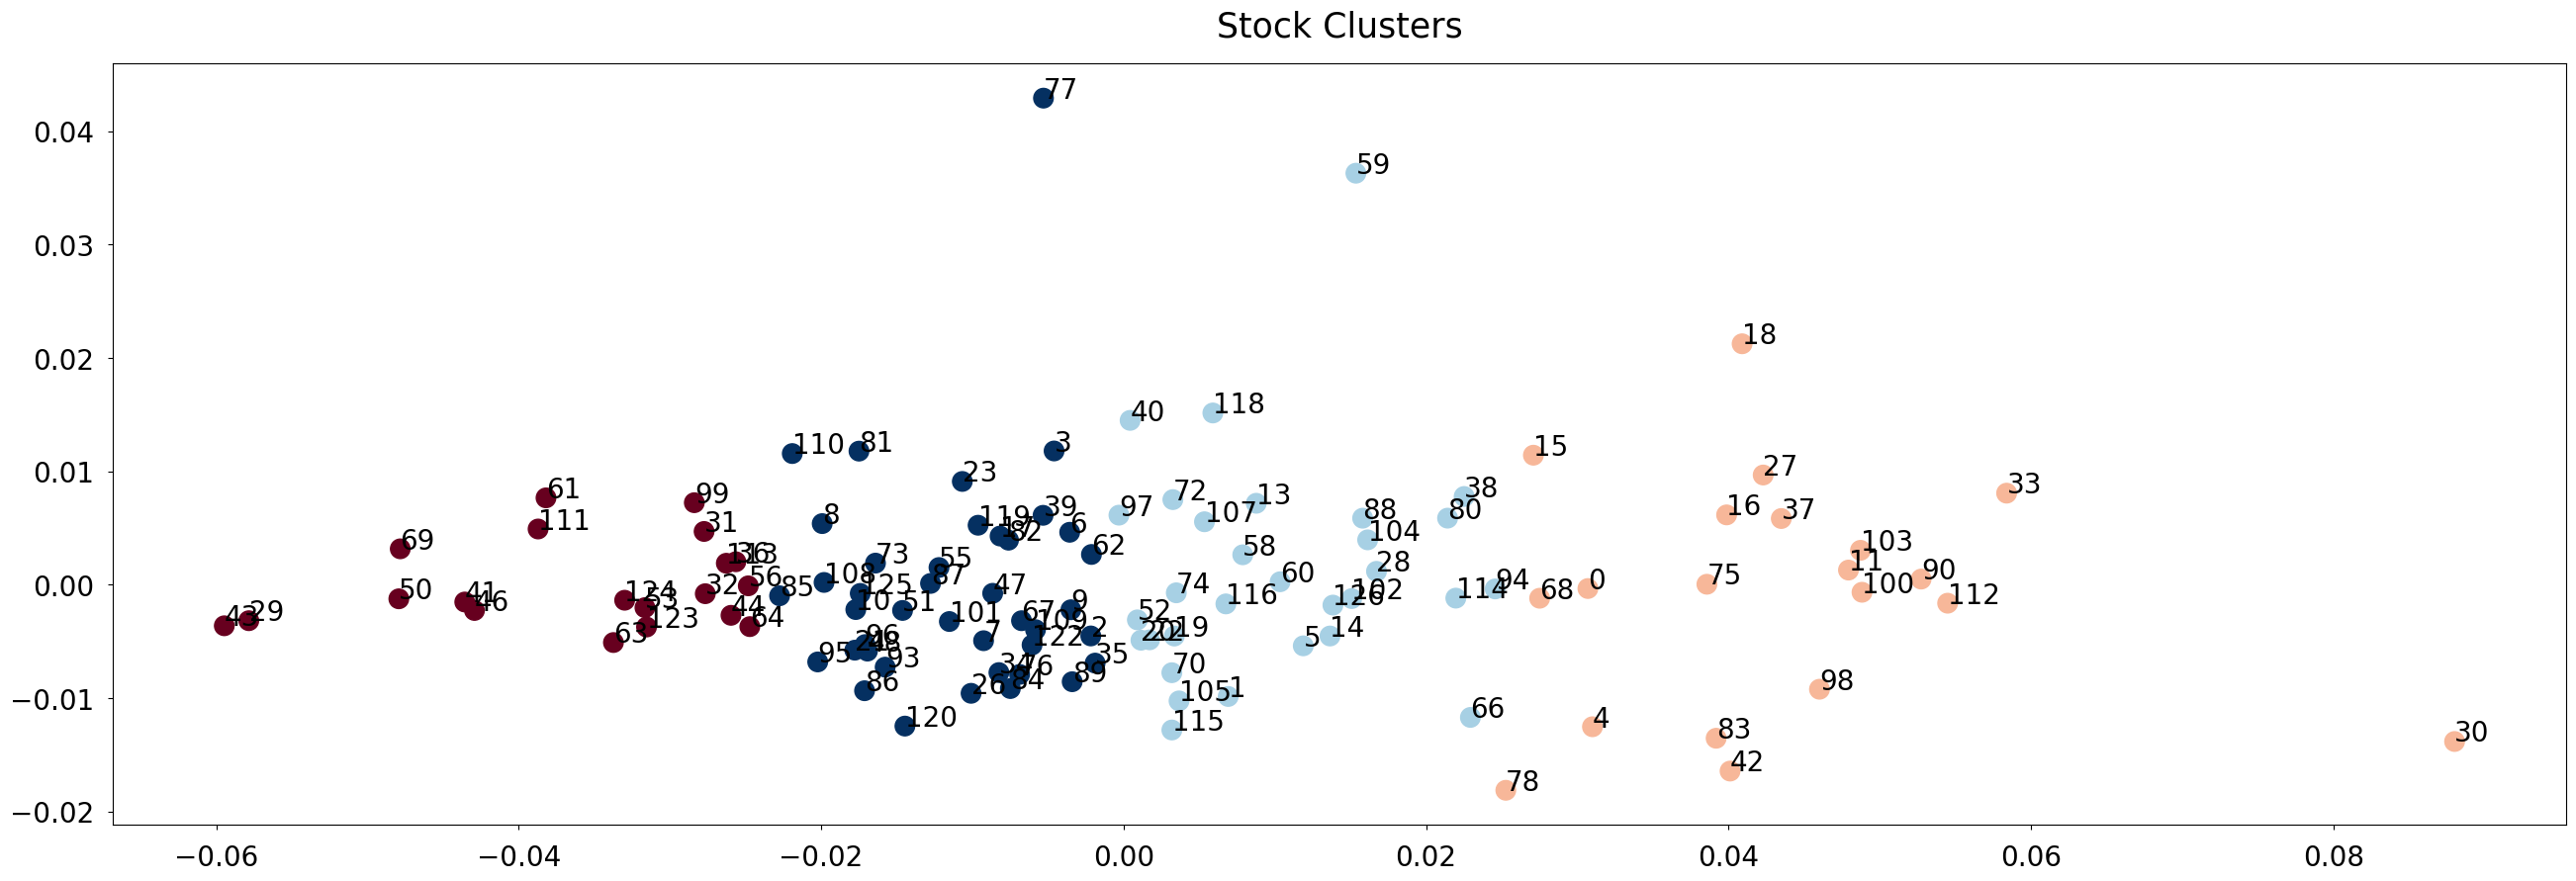

In [80]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(df_stocks[stock_features])

pca = PCA(n_components=2)
stocks_2d = pca.fit_transform(df_stocks[stock_features])

fig, ax = plt.subplots(figsize=(32, 10))
ax.scatter(stocks_2d[:, 0], stocks_2d[:, 1], s=200, c=kmeans.labels_, cmap='RdBu')
for idx, stock_id in enumerate(df_stocks['stock_id'].values):
    ax.annotate(stock_id, (stocks_2d[idx, 0], stocks_2d[idx, 1]), fontsize=20)
    
ax.tick_params(axis='x', labelsize=20, pad=10)
ax.tick_params(axis='y', labelsize=20, pad=10)
ax.set_title('Stock Clusters', size=25, pad=20)

plt.show()

In [81]:
kmeans.labels_, len(kmeans.labels_)

(array([1, 2, 3, 3, 1, 2, 3, 3, 3, 3, 3, 1, 2, 2, 1, 1, 3, 1, 2, 2, 3, 2,
        3, 3, 1, 2, 0, 1, 0, 0, 1, 3, 3, 0, 1, 2, 3, 2, 0, 1, 0, 0, 0, 3,
        3, 0, 3, 2, 0, 3, 0, 2, 2, 2, 0, 3, 0, 0, 2, 3, 1, 0, 2, 2, 3, 2,
        1, 3, 3, 1, 2, 3, 3, 1, 3, 3, 3, 3, 2, 3, 1, 3, 2, 3, 3, 2, 1, 0,
        1, 3, 2, 1, 2, 2, 2, 3, 3, 3, 0, 1, 0, 2, 2, 2, 2, 3, 3, 3, 0, 0,
        3, 2], dtype=int32),
 112)